# Incoherent-Excitation in Monomers
## Calculations for the paper: *sanity checks, convergence & analysis*

Aiming to answer the questions:
- What does the non-RWA do that the naive, secular and non-secular don't?
- In which regimes can you expect the naive, secular and non-secular to work? Is the naive ever of interest?

### Contents:
Items in **bold** are to be included in the paper.

** Preliminary things: **
- Imports and default parameters
- **[a] Convergence checking of overdamped spectral densities with respect to $\omega_0$ to find parameters over which we're sure the spectral density *looks* overdamped**
    
- Checking that cheap secular approximation ($i=m, j=n$) is equivalent to full secular approx. ($e_{ij}=e_{mn}$). Investigate what is going on inside the map and what the $e_{ij}=e_{mn}$ terms actually are.

**Phonons only:**

- Convergence of RC theory dynamics wrt. N for use in comparing RC to exact solutions and for the subsequent calculations.

- Validity of RC theory: comparison to exact solution to ensure that the phonon part is accurate in isolation.



**EM bath included:**

- Convergence of full model with respect to N: how does including optical driving change truncation?
- **$\omega_{RC}$ dependence of instantaneous decay rates of initial population states to other population states: which theories allow which transitions?**
- **Convergence of overdamped steady-states wrt $\omega_0$: does an OD SD as defined by [a] yield convergence in vibronic and electronic decay rates?**
- **$\alpha_{ph}$ dependence of instantaneous population-population decay rates: does manifold displacement induce the physical changes which are to be expected?**
- $T_{EM}$ dependence of instantaneous population-population decay rates: do any theories predict non-linear temperature dependence?
- $T_{EM}$ and $T_{ph}$ dependence of instantaneous population-population decay rates: do any theories predict non-linear temperature dependence?
- Steady-state population of vibronic states: $\alpha_{ph}$ dependence.
- **Dynamics of vibronic/electronic population states (diagonal density matrix elements). This is important as it shows the different spontaneous emission rates due to the phonon manifold being taken into account.**
- Vibronic coherence dynamics: TLS-RC initialised in diagonal population states **maybe, to discuss which terms are not taken into account in the non-secular and secular cases.**
- Vibronic coherence and population transition rates: TLS-RC initialised in off-diagonal states (non-secular transitions)
- Attempt at emission spectra using Jake's efficient method
### Conclusions
The different optical maps predict different rates 

Things that the naive approach misses:
- It predicts non-zero decay rates to higher lying vibronic states at zero T
- It does not account for the displacement dependence of decay rates between excited and ground manifolds.
- It does not allow coherences to couple to other coherences on the same manifold: probably because it cannot *see* these states/coherences and thinks that such interactions are disallowed by the Hamiltonian symmetry.

Things that the non-secular approach misses:
- It predicts non-zero decay rates to higher lying vibronic states at zero T

In [2]:
import time

from qutip import ket, mesolve, qeye, tensor, thermal_dm, destroy, steadystate
import qutip as qt
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi

import UD_liouv as RC
import driving_liouv as EM
import ME_checking as check
import exact_IB as exact
import scipy as sp

import phonon_weak_coupling as WC
from utils import J_overdamped, beta_f, J_underdamped, J_minimal_hard, J_multipolar

reload(RC)
reload(EM)
reload(check)
reload(exact)
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
plt.rcParams['axes.facecolor'] = 'white'

Things to do in these notes:
- Convergence of RC theory with respect to N for increasing alpha:
    - a) ~~Overdamped~~
    - b) ~~Low and high-frequency under-damped~~
- ~~Are all my overdamped parameters working correctly? Is $w_0 = \epsilon$ sufficient?~~
- ~~I need to check that the exact solution gives me what I want: At which coupling strengths, mode frequencies, temperatures is the RC method valid?~~ ~~How about with underdamped modes?~~
- ~~Look at vibronic/electronic eigenstate populations across windows of validity.~~
- ~~Look at decay rates to various vibronic states when starting in various vibronic states~~
- ~~check steadystate convergence with respect to $\omega_{RC}$ including optical driving at high T.~~
- check dynamics error with respect to $\omega_{RC}$ as well for low and high T.

Thus, does the ambiguity of $\omega_{RC}$ pose a major problem for incoherent excitation? *WHAT IS THE CORRECT APPROACH?!?!*
The non-RWA approach accounts for the fact that the environment plays a part in the transitions between eigenstates and does so in a way which preserves energy conservation, whilst also not discarding terms which are slowly oscillating.

- is it possible to find a variable which determines the validity of the RWA? : inversely proportional to $\alpha_{RC}$ (maybe this is only incidentally important as it's probably the population of the vibronic levels and whether the terms are near resonance).

For 02/02/2018. Write up the story so far:
- The phonon SD sharpness, coupling strength, temperature (and optical temperature) dependence of the validity of the quantum optical approximations.
- The ambiguity of $\omega_{RC}$ for overdamped spectral densities, what this means for vibronic and electronic dynamics. i.e.: electronic behaviour converges with $\omega_{RC}$ much faster than the vibronic for naive and full. **which is the best approach and why?**



In [4]:
# Things that will always be true
ev_to_inv_cm = 8065.5
inv_ps_to_inv_cm = 5.309
G = ket([0])
E = ket([1])
sigma = G*E.dag() # Definition of a sigma_- operator.
J_EM = J_multipolar#EM.J_minimal
# Things that are true by default but are subject to overriding
## ~~ Parameters ~~

eps = 0.1*8065.5 # TLS splitting
#eps = 2.*1519.3 # ps
T_EM = 6000. # Optical bath temperature
#H_S = eps*E*E.dag()
#alpha_EM = 0.3 # System-bath strength (optical)
Gamma_EM = 0.1*5.309 #bare decay of electronic transition from inv. ps to in inv. cm
#Gamma_EM = 6.582E-7*1519.3
T_ph = 300. # Phonon bath temperature
overdamped = True
phonon_only = True
#fig1wc = 53.*0.188

''' RC stuff '''
N = 15
#w0 = 200.*0.188
Gamma = 60. # Width of distribution
alpha_ph = 3*eps # Ind.-Boson frame coupling
beta = beta_f(T_ph)#1/(0.695*T_ph)
wc = 1*53. # Ind.-Boson frame phonon cutoff freq
shift = 0.5*np.pi*alpha_ph
w0 = eps+50 #-100 # underdamped SD parameter omega_0
optical_cutoff = 20000.
if overdamped:
        Gamma = (w0**2)/wc
n_RC = EM.Occupation(w0, T_ph)
#initial_sys = G*G.dag()
#initial_sys = E*E.dag()
#initial_sys = 0.5*(G+E)*(E.dag()+G.dag())
initial_sys = 0.5*(E+G)*(E+G).dag()

rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
#print (rho_0*tensor(qeye(2), destroy(N).dag()*destroy(N))).tr()

# Expectation values and time increments needed to calculate the dynamics
expects_wc = [G*G.dag(), E*G.dag()]
expects = [tensor(G*G.dag(), qeye(N)), tensor(E*G.dag(), qeye(N)), 
           tensor(E*E.dag(), qeye(N)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
           tensor(qeye(2), destroy(N).dag()+destroy(N))]
nTimeSteps = 250
timelist = np.linspace(0, 0.07, nTimeSteps)


def ground_and_excited_states(states):
    ground_list = []
    excited_list = []
    concat_list = [ground_list, excited_list]
    for i in range(len(states)): #
        is_ground = sum(states[i])[0][0].real == 1.
        if is_ground:
            ground_list.append(i)
        else:
            excited_list.append(i)
    return ground_list, excited_list
def initialise_TLS(init_sys, init_RC, states, w0, T_ph):
    ground_list, excited_list = ground_and_excited_states(states)
    concat_list = [ground_list, excited_list]
    N = states[1].shape[0]/2
    if type(init_sys) == tuple:
        #coherence state
        if type(init_RC) == tuple:
            # take in a 2-tuple to initialise in coherence state.
            print init_sys, init_RC
            rho_left = states[concat_list[init_sys[0]][init_RC[0]]]
            rho_right = states[concat_list[init_sys[1]][init_RC[1]]].dag()
            init_rho = rho_left*rho_right
        else:
            raise ValueError
    elif init_sys == 0:
        # population state
        init_rho = states[ground_list[init_RC]]*states[ground_list[init_RC]].dag()
    elif init_sys==1:
        init_rho = states[excited_list[init_RC]]*states[excited_list[init_RC]].dag()
    elif init_sys==2:
        Therm = qt.thermal_dm( N, EM.Occupation(w0, T_ph))
        init_rho = qt.tensor(E*E.dag(), Therm)
        # if in neither ground or excited
        # for the minute, do nothing. This'll be fixed below.
    else:
        # finally, if not in either G or E, initialise as thermal
        num = (-H_RC*beta_f(T_ph)).expm()
        init_rho =  num/num.tr()
    return init_rho
def plot_spectral_density():
    return

## Convergence of spectral densities and dynamics

Firstly, with what values of $\omega_0$ does the overdamped limit of underdamped SD converge?

We need to know what is a suitable value to choose for $\omega_{RC}$ in order for the spectral density to look like a converged  


In [5]:

alpha_ph = 1*eps
nsteps = 1000
w = np.linspace(0., 3*eps, nsteps)
w0_i = 1.2*eps
w0_f = w0_i+2.5*eps
# total error is naturally a function of nsteps
total_error = np.sqrt(sum((J_underdamped(
                    w, 1*eps, w0_i**2/wc, w0_i)-J_overdamped(w, 1*eps, wc)**2)))
print "Average SD error per step: {}".format(total_error/nsteps)

opts = qt.Options(nsteps=5000)

Gamma_i = w0_i**2/wc

L_RC, H_RC, A_EM_, A_nrwa_, Z, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma_i, w0_i, alpha_ph, N)
DATA_sc_i =  np.array(mesolve(H_RC, rho_0, timelist, [L_RC], expects, progress_bar=True).expect[1])

Gamma_f = w0_f**2/wc
L_RC, H_RC, A_EM_, A_nrwa_, Z, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma_f, w0_f, alpha_ph, N)
DATA_sc_f =  np.array(mesolve(H_RC, rho_0, timelist, [L_RC], expects, progress_bar=True, options=opts).expect[1])

total_error_dyn = np.sqrt(abs(sum(DATA_sc_i-DATA_sc_f)**2))
print "Average (approx.) error in each timestep: {}".format(total_error_dyn/float(nTimeSteps))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in sqrt


Average SD error per step: nan
w_RC=967.86 | TLS splitting = 806.55 | RC-res. coupling=2.91 | TLS-RC coupling=1107.34 | Gamma_RC=17674.58 | alpha_ph=806.55 | N=15 |
10.0%. Run time:   0.78s. Est. time left: 00:00:00:06
20.0%. Run time:   1.83s. Est. time left: 00:00:00:07
30.0%. Run time:   2.65s. Est. time left: 00:00:00:06
40.0%. Run time:   3.47s. Est. time left: 00:00:00:05
50.0%. Run time:   4.32s. Est. time left: 00:00:00:04
60.0%. Run time:   5.15s. Est. time left: 00:00:00:03
70.0%. Run time:   5.98s. Est. time left: 00:00:00:02
80.0%. Run time:   6.80s. Est. time left: 00:00:00:01
90.0%. Run time:   7.64s. Est. time left: 00:00:00:00
Total run time:   8.42s
w_RC=2984.235 | TLS splitting = 806.55 | RC-res. coupling=8.96 | TLS-RC coupling=1944.43 | Gamma_RC=168031.29 | alpha_ph=806.55 | N=15 |
10.0%. Run time:   7.50s. Est. time left: 00:00:01:07


KeyboardInterrupt: 

THings seem to converge fairly well where $\omega_0>\epsilon$. The greater $\omega_0$ is, the longer the calculations take but (generally) fewer states are needed.

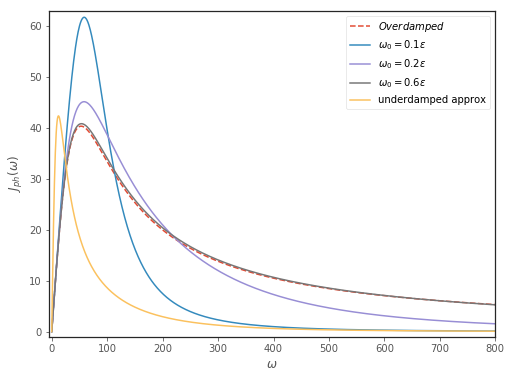

In [285]:
nsteps = 1000
wc = 53.
w = np.linspace(0., 1*eps, nsteps)
plt.figure(figsize=(8,6))
plt.plot(w, J_overdamped(w, 0.1*eps, wc), label='$Overdamped$', linestyle='dashed')
plt.plot(w, J_underdamped(w, 0.1*eps, (0.1*eps)**2/wc, (0.1*eps)), label='$\omega_0=0.1\epsilon$')
plt.plot(w, J_underdamped(w, 0.1*eps, (0.2*eps)**2/wc, (0.2*eps)), label='$\omega_0=0.2\epsilon$')
plt.plot(w, J_underdamped(w, 0.1*eps, (0.6*eps)**2/wc, (0.6*eps)), label='$\omega_0=0.6\epsilon$')
#plt.plot(w, J_underdamped(w, 0.1*eps, (1.5*eps)**2/wc, (1.5*eps)), label='$\omega_0=1.5\epsilon$')
plt.ylabel("$J_{ph}(\omega)$")
plt.xlabel("$\omega$")
plt.xlim(-5,800)
plt.ylim(-1,63)
plt.legend()
plt.savefig("Images/spectralDensities.pdf")
plt.show()

In [7]:
from driving_liouv import Occupation
from qutip import spre, spost, sprepost
reload(RC)
def L_full_secular(H_vib, A, eps, Gamma, T, J, time_units='cm', silent=False):
    '''
    Initially assuming that the vibronic eigenstructure has no
    degeneracy and the secular approximation has been made
    '''
    ti = time.time()
    d = H_vib.shape[0]
    L = 0
    eVals, eVecs = H_vib.eigenstates()
    A_dag = A.dag()
    terms = 0
    ground_list = []
    excited_list = []
    for i in range(len(eVals)):
        is_ground = sum(eVecs[i])[0][0].real == 1.
        if is_ground:
            ground_list.append(i)
        else:
            excited_list.append(i)
        
    for l in range(int(d)):
        for m in range(int(d)):
            for p in range(int(d)):
                for q in range(int(d)):
                    secular_freq = (eVals[l]-eVals[m]) - (eVals[p]-eVals[q])
                    if abs(secular_freq) <1E-10:
                        
                        terms+=1
                        A_lm = A.matrix_element(eVecs[l].dag(), eVecs[m])
                        A_lm_star = A_dag.matrix_element(eVecs[m].dag(), eVecs[l])
                        A_pq = A.matrix_element(eVecs[p].dag(), eVecs[q])
                        A_pq_star = A_dag.matrix_element(eVecs[q].dag(), eVecs[p])
                        coeff_1 = A_lm*A_pq_star
                        coeff_2 = A_lm_star*A_pq
                        eps_pq = abs(eVals[p]-eVals[q])
                        Occ = Occupation(eps_pq, T, time_units)
                        r_up = np.pi*J(eps_pq, Gamma, eps)*Occ
                        r_down = np.pi*J(eps_pq, Gamma, eps)*(Occ+1)
                        LM = eVecs[l]*eVecs[m].dag()
                        ML = LM.dag()
                        PQ = eVecs[p]*eVecs[q].dag()
                        QP = PQ.dag()
                        """
                        if abs(secular_freq) !=0:
                            print (abs(secular_freq), r_up, A_lm, A_lm_star, 
                                   A_pq, A_pq_star, r_down, l,m,p,q, m==q, l==p)
                        """
                        # until this point there are many terms which are allowed past the
                        # strict secular approximation above, where l!=p and m!=q.
                        if abs(r_up*coeff_1)>0:
                            L+= r_up*coeff_1*(spre(LM*QP)-sprepost(QP,LM))
                        if abs(r_up*coeff_2)>0:
                            L+= r_up*coeff_2*(spost(PQ*ML)- sprepost(ML,PQ))
                        if abs(r_down*coeff_1)>0:
                            L+= r_down*coeff_1*(spre(ML*PQ)-sprepost(PQ, ML))
                        if abs(r_down*coeff_2)>0:
                            L+= r_down*coeff_2*(spost(QP*LM)-sprepost(LM, QP))
                        if abs(r_up*coeff_1)+abs(r_up*coeff_2)+abs(r_down*coeff_1)+abs(r_down*coeff_2) >0:
                            # l, m, p, q is always ground, excited, ground, excited
                            # l, m always = p, q 
                            #print l in ground_list, m in ground_list, p in ground_list, q in ground_list
                            #print l==p, m==q
                            pass
    if not silent:
        print "It took ", time.time()-ti, " seconds to build the secular Liouvillian"
        print "Secular approximation kept {:0.2f}% of total ME terms. \n".format(100*float(terms)/(d*d*d*d))
    return -L
w0=eps*1.3
Gamma = (w0**2)/wc
L_RC, H_RC, A_EM_, A_nrwa_, Z, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, alpha_ph, 14)
L_test1 = L_full_secular(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)
L_test2 = EM.L_vib_lindblad(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)
ss1 = steadystate(H_RC, [L_RC+L_test1]).ptrace(0)
ss2 = steadystate(H_RC, [L_RC+L_test2]).ptrace(0)
print ss1, ss2
"""
L_RC, H_RC, A_EM_, A_nrwa_, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, alpha_ph, 20)
L_test1 = L_full_secular(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)
L_test2 = EM.L_vib_lindblad(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)

L_RC, H_RC, A_EM_, A_nrwa_, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, alpha_ph, 30)
L_test1 = L_full_secular(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)
L_test2 = EM.L_vib_lindblad(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)

L_RC, H_RC, A_EM_, A_nrwa_, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, alpha_ph, 40)
L_test1 = L_full_secular(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)
L_test2 = EM.L_vib_lindblad(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)
ss1 = steadystate(H_RC, [L_RC+L_test1]).ptrace(0)
ss2 = steadystate(H_RC, [L_RC+L_test2]).ptrace(0)
print ss1, ss2
"""

w_RC=1048.515 | TLS splitting = 806.55 | RC-res. coupling=3.15 | TLS-RC coupling=1152.56 | Gamma_RC=20743.09 | alpha_ph=806.55 | N=14 |
It took  6.42062807083  seconds to build the secular Liouvillian
Secular approximation kept 0.49% of total ME terms. 

It took  1.33334612846  seconds to build the vibronic Lindblad Liouvillian
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.37664021  0.        ]
 [ 0.          0.62335979]] Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.37664021  0.        ]
 [ 0.          0.62335979]]


"\nL_RC, H_RC, A_EM_, A_nrwa_, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, alpha_ph, 20)\nL_test1 = L_full_secular(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)\nL_test2 = EM.L_vib_lindblad(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)\n\nL_RC, H_RC, A_EM_, A_nrwa_, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, alpha_ph, 30)\nL_test1 = L_full_secular(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)\nL_test2 = EM.L_vib_lindblad(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)\n\nL_RC, H_RC, A_EM_, A_nrwa_, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, alpha_ph, 40)\nL_test1 = L_full_secular(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)\nL_test2 = EM.L_vib_lindblad(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)\nss1 = steadystate(H_RC, [L_RC+L_test1]).ptrace(0)\nss2

**So we can see that** the two approaches give the same results. This is because the terms which are discarded when there are resonances (but $l\neq p$ and $m\neq q$) are forbidden due to the symmetry of the system operator and the vibronic Hamiltonian. This occurs when the terms describe EM-field-induced transitions between vibronic states on the same manifold, which are forbidden. We can also see that the more complete version takes considerably longer, however, with higher N, proportionally fewer terms are kept after the secular approximation.

## Rigorous RWAs

In [32]:
def proper_rate_calc(eps=1000., T_ph=300., w0_prop=1., alpha_prop=3., 
                     Gamma_prop=0.1, T_EM=0., Gamma_EM_prop=0.005,init_RC=0,
                     silent=False, N=22):
    ti = time.time()
    
    Gamma, w0, alpha_ph, Gamma_EM = Gamma_prop*eps, w0_prop*eps, alpha_prop*eps/pi, Gamma_EM_prop*eps
    L_RC, H_RC, A_EM, A_nrwa, _, _, _, _ = RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, alpha_ph, 
                                                             N, silent=silent)
    # Three different approaches
    L_nrwa = EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM, silent=True)
    L_em_ns = EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J_EM, silent=True)
    L_esa = EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J_EM, silent=True)
    expects = [tensor(G*G.dag(), qeye(N))]
    opts = qt.Options(nsteps=1000)
    rho_0 = tensor(E*E.dag(), qt.fock_dm(N, n=init_RC))
    try: 
        timelist = np.linspace(0, 0.6, 250)
        DATA_full = mesolve(H_RC, rho_0, timelist, [L_RC+L_nrwa], 
                              expects, options=opts).expect[0].real
        assert DATA_full[-1]>0.5
    except:
        timelist = np.linspace(0, 1.0, 350)
        DATA_full = mesolve(H_RC, rho_0, timelist, [L_RC+L_nrwa], 
                              expects, options=opts).expect[0].real
        assert DATA_full[-1]>0.5
        DATA_ns = mesolve(H_RC, rho_0, timelist, [L_RC+L_em_ns], 
                              expects, options=opts).expect[0].real
        assert DATA_ns[-1]>0.5
        DATA_esa = mesolve(H_RC, rho_0, timelist, [L_RC+L_esa], 
                              expects, options=opts).expect[0].real
        assert DATA_esa[-1]>0.5
        data = [DATA_full, DATA_ns, DATA_esa]
        crossing_points = [0, 0, 0]
        for i in range(3):
            for dp in data[i]:
                if dp<0.5:
                    crossing_points[i]+=1
            assert crossing_points[i]<len(data[i])
        
    if not silent:
        print "Rates took {} seconds to calculate.".format(time.time()-ti)
    return crossing_points
print proper_rate_calc(w0_prop=0.1)
print proper_rate_calc(w0_prop=0.5)
print proper_rate_calc(w0_prop=1)

w_RC=100.0 | TLS splitting = 1000.0 | RC-res. coupling=0.16 | TLS-RC coupling=387.30 | Gamma_RC=100.00 | alpha_ph=954.93 | N=22 |
Rates took 28.0342891216 seconds to calculate.


UnboundLocalError: local variable 'crossing_points' referenced before assignment

w_RC=990.0 | TLS splitting = 1000.0 | RC-res. coupling=0.02 | TLS-RC coupling=881.78 | Gamma_RC=100.00 | alpha_ph=500.00 | N=25 |
Calculating non-RWA Liouvilliian took 2.58013916016 seconds.
It took  4.9647731781  seconds to build the Non-secular RWA Liouvillian
It took  13.546916008  seconds to build the vibronic Lindblad Liouvillian
10.0%. Run time:  19.04s. Est. time left: 00:00:02:51
20.0%. Run time:  38.31s. Est. time left: 00:00:02:33
30.0%. Run time:  59.07s. Est. time left: 00:00:02:17
40.0%. Run time:  80.71s. Est. time left: 00:00:02:01
50.0%. Run time: 100.56s. Est. time left: 00:00:01:40
60.0%. Run time: 120.34s. Est. time left: 00:00:01:20
70.0%. Run time: 140.23s. Est. time left: 00:00:01:00
80.0%. Run time: 160.58s. Est. time left: 00:00:00:40
90.0%. Run time: 181.06s. Est. time left: 00:00:00:20
Total run time: 201.17s
10.0%. Run time:   5.56s. Est. time left: 00:00:00:50
20.0%. Run time:  11.20s. Est. time left: 00:00:00:44
30.0%. Run time:  16.80s. Est. time left: 00:

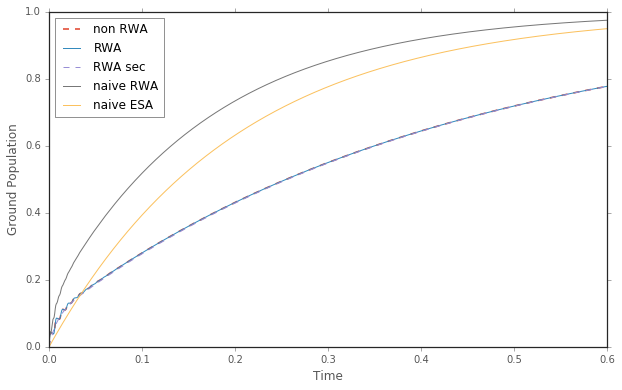

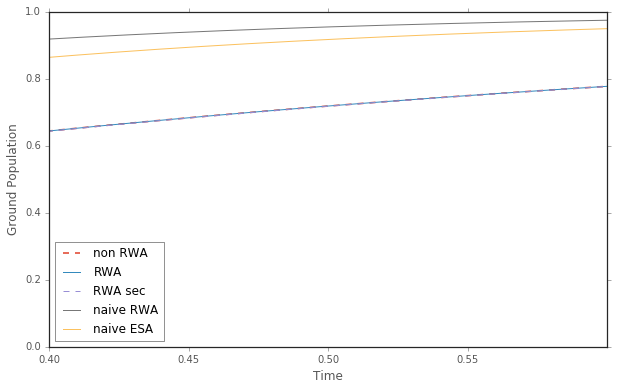

In [18]:

def RWA_system_ops(H_vib, S):
    S_plus = 0 #np.zeros(shape=H_vib.shape)
    S_minus = 0 #np.zeros(shape=H_vib.shape)
    S_0 = 0 #np.zeros(shape=H_vib.shape)
    eVals, eVecs = H_vib.eigenstates()
    
    for j, phi_j in enumerate(eVecs):
        for k, phi_k in enumerate(eVecs):
            S_jk = S.matrix_element(phi_j.dag(), phi_k)
            S_contrib = S_jk*phi_j*phi_k.dag()
            if eVals[j]>eVals[k]:
                S_plus += S_contrib
            elif eVals[j]<eVals[k]:
                S_minus += S_contrib
            else:
                S_0 += S_contrib
    assert S_plus == S_minus.dag()
    #if S_0 !=0:
    #    print "Some non-zero S_0 contribution!"
    return S_plus, S_minus, S_0
#print H_RC, A_nrwa_, eps, Gamma_EM
nTimeSteps = 1000
timelist = np.linspace(0, 0.60, nTimeSteps)
def dynamics_plotter(eps=1000., T_ph=300., w0_prop=0.1, alpha_prop=0.1, 
                     Gamma_prop=0.1, T_EM=0., Gamma_EM_prop=0.005):
    
    N = 25
    Gamma, w0, alpha_ph, Gamma_EM = Gamma_prop*eps, w0_prop*eps, alpha_prop*eps, Gamma_EM_prop*eps
    L_RC, H_RC, A_EM, A_nrwa, _, _, _, _ = RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, alpha_ph, N)

    S_plus, S_minus, S_0 = RWA_system_ops(H_RC, A_nrwa)
    L_nrwa = EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM)
    L_vib_ns = EM.L_nonsecular(H_RC, S_minus, eps, Gamma_EM, T_EM, J=J_EM).tidyup(atol=1E-9)
    L_vib_s = EM.L_vib_lindblad(H_RC, S_minus, eps, Gamma_EM, T_EM, J=J_EM).tidyup(atol=1E-9)
    L_em_ns = EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J_EM, silent=True).tidyup(atol=1E-9)
    L_em_s = EM.L_vib_lindblad(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J_EM, silent=True).tidyup(atol=1E-9)
    L_em = EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J_EM, silent=True)
    expects = [tensor(G*G.dag(), qeye(N)), tensor(E*G.dag()+G*E.dag(), qeye(N)), 
                   tensor(E*E.dag(), qeye(N)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
                   tensor(qeye(2), destroy(N).dag()+destroy(N))]
    rho_0 = tensor(E*E.dag(), thermal_dm(N, n_RC))
    #DATA_wc = mesolve(H_S, initial_sys, timelist, [L_wc], expects_wc, progress_bar=True)
    #print H_RC.eigenenergies()
    #print eps-0.5*np.pi*alpha, eps+w0, eps-0.5*np.pi*alpha+w0
    DATA_rig = mesolve(H_RC, rho_0, timelist, [L_RC+L_vib_ns], 
                          expects, options=qt.Options(nsteps=1000), progress_bar=True).expect[0].real
    DATA_nrwa = mesolve(H_RC, rho_0, timelist, [L_RC+L_nrwa], 
                          expects, options=qt.Options(nsteps=1000), progress_bar=True).expect[0].real
    DATA_rigsec = mesolve(H_RC, rho_0, timelist, [L_RC+L_vib_s], 
                          expects, options=qt.Options(nsteps=1000)).expect[0].real
    DATA_nonrig = mesolve(H_RC, rho_0, timelist, [L_RC+L_em_ns], 
                          expects, options=qt.Options(nsteps=1000)).expect[0].real
    DATA_ESA = mesolve(H_RC, rho_0, timelist, [L_RC+L_em], 
                          expects, options=qt.Options(nsteps=1000)).expect[0].real
    #DATA_nonrig_sec = mesolve(H_RC, rho_0, timelist, [L_RC+L_em_s], 
    #                      expects, options=qt.Options(nsteps=1000)).expect[0].real
    plt.figure(figsize=(10,6))
    plt.plot(timelist, DATA_nrwa, label='non RWA', ls='dashed', linewidth=1.6)
    plt.plot(timelist, DATA_rig, label='RWA', linewidth=1.)
    plt.plot(timelist, DATA_rigsec, label='RWA sec', ls='dashed',linewidth=1.0)
    plt.plot(timelist, DATA_nonrig, label='naive RWA')
    plt.plot(timelist, DATA_ESA, label='naive ESA')

    #plt.plot(timelist, DATA_nonrig, label='naive RWA sec', ls='dashed', linewidth=1.6)
    plt.legend(loc='best')
    plt.ylabel('Ground Population')
    plt.xlabel('Time')
    #plt.xlim(0.,0.05)
    plt.figure(figsize=(10,6))
    plt.plot(timelist, DATA_nrwa, label='non RWA', ls='dashed', linewidth=1.6)
    plt.plot(timelist, DATA_rig, label='RWA', linewidth=1.)
    plt.plot(timelist, DATA_rigsec, label='RWA sec', ls='dashed',linewidth=1.0)
    plt.plot(timelist, DATA_nonrig, label='naive RWA')
    plt.plot(timelist, DATA_ESA, label='naive ESA')
    #plt.plot(timelist, DATA_nonrig, label='naive RWA sec', ls='dashed', linewidth=1.6)
    plt.legend(loc='best')
    plt.xlim(timelist[-1]-0.2,timelist[-1])
    plt.ylabel('Ground Population')
    plt.xlabel('Time')
    plt.show()
    
dynamics_plotter(alpha_prop=0.5, w0_prop=0.99)


w_RC=500.0 | TLS splitting = 1000.0 | RC-res. coupling=0.03 | TLS-RC coupling=626.66 | Gamma_RC=100.00 | alpha_ph=500.00 | N=25 |
Calculating non-RWA Liouvilliian took 2.6409740448 seconds.
It took  5.1899960041  seconds to build the Non-secular RWA Liouvillian
It took  14.3026599884  seconds to build the vibronic Lindblad Liouvillian
10.0%. Run time:  10.60s. Est. time left: 00:00:01:35
20.0%. Run time:  21.29s. Est. time left: 00:00:01:25
30.0%. Run time:  31.89s. Est. time left: 00:00:01:14
40.0%. Run time:  42.58s. Est. time left: 00:00:01:03
50.0%. Run time:  53.22s. Est. time left: 00:00:00:53
60.0%. Run time:  64.98s. Est. time left: 00:00:00:43
70.0%. Run time:  76.65s. Est. time left: 00:00:00:32
80.0%. Run time:  87.44s. Est. time left: 00:00:00:21
90.0%. Run time:  98.39s. Est. time left: 00:00:00:10
Total run time: 109.98s
10.0%. Run time:   2.86s. Est. time left: 00:00:00:25
20.0%. Run time:   6.08s. Est. time left: 00:00:00:24
30.0%. Run time:   9.04s. Est. time left: 00:

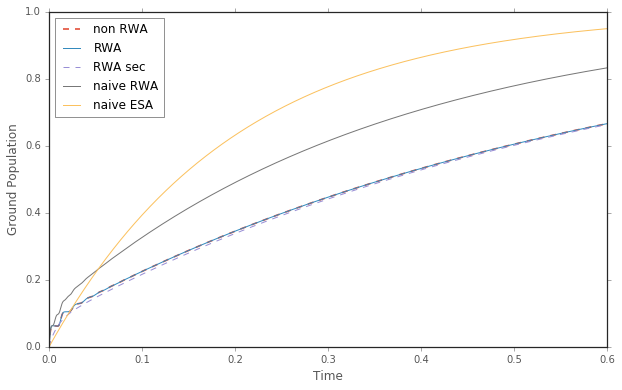

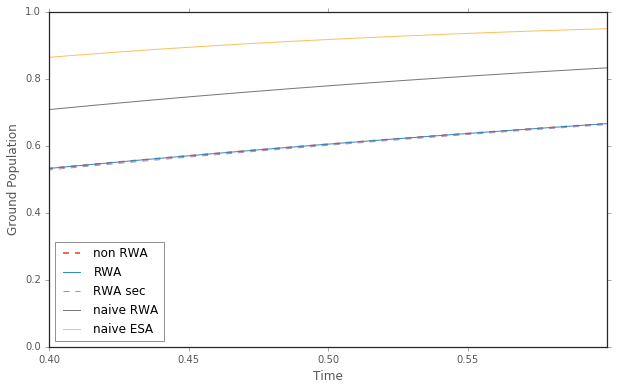

w_RC=500.0 | TLS splitting = 1000.0 | RC-res. coupling=0.06 | TLS-RC coupling=626.66 | Gamma_RC=200.00 | alpha_ph=500.00 | N=25 |
Calculating non-RWA Liouvilliian took 2.74170684814 seconds.
It took  5.1959540844  seconds to build the Non-secular RWA Liouvillian
It took  14.728497982  seconds to build the vibronic Lindblad Liouvillian
10.0%. Run time:  12.87s. Est. time left: 00:00:01:55
20.0%. Run time:  26.83s. Est. time left: 00:00:01:47
30.0%. Run time:  40.05s. Est. time left: 00:00:01:33
40.0%. Run time:  54.99s. Est. time left: 00:00:01:22
50.0%. Run time:  68.00s. Est. time left: 00:00:01:07
60.0%. Run time:  80.68s. Est. time left: 00:00:00:53
70.0%. Run time:  93.61s. Est. time left: 00:00:00:40
80.0%. Run time: 106.25s. Est. time left: 00:00:00:26
90.0%. Run time: 118.92s. Est. time left: 00:00:00:13
Total run time: 131.57s
10.0%. Run time:   3.19s. Est. time left: 00:00:00:28
20.0%. Run time:   6.42s. Est. time left: 00:00:00:25
30.0%. Run time:   9.61s. Est. time left: 00:

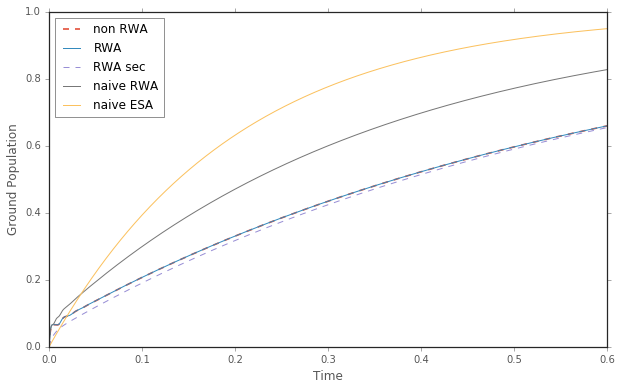

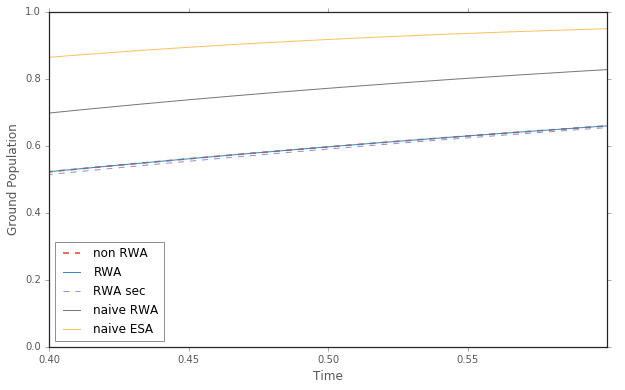

In [19]:
dynamics_plotter(alpha_prop=0.5, w0_prop=0.5)
dynamics_plotter(alpha_prop=0.5, w0_prop=0.5, Gamma_prop=0.2)

So as we can see above:
- The rigorous rotating wave approximation gives steady states consistent with the non-RWA, regardless of secular approximation.
- The rigorous non-secular equation gives dynamics which are very consistent with the full non-RWA.
- The rigorous secular dynamics do not give any population oscillations, since populations do not couple to coherences, but give the correct steadystates for this simple system.
- 

# Convergence of RC theory dynamics (wrt N)
For some fairly strong coupling, when do the calculations stop changing appreciably with increasing N?

alpha prop: 1.0, w0 prop: 1.5, eps: 806.55
N=20: converged to 	 ** Error:  4.26496788095e-08  ** Took: 35.8458151817s**


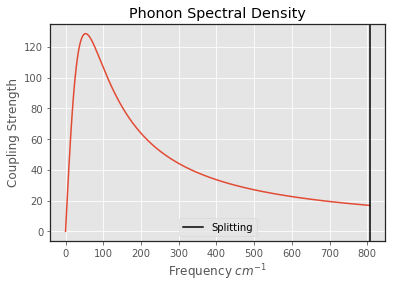

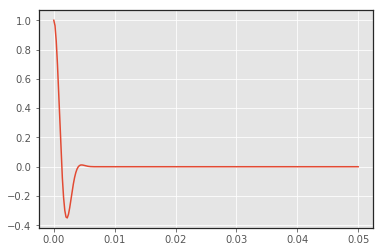

'\nconvergence_checker(1, 500./eps, 10., overdamped=False, threshold=10E-10)\nconvergence_checker(1., 1./14., 30., threshold=10E-8)\nconvergence_checker(1., 1./2, 30., threshold=10E-8)\n\n\nconvergence_checker(1., 1.5, 0, overdamped=True, threshold=10E-8)\nconvergence_checker(1, 0.1, 10., overdamped=True, threshold=10E-8)\n'

In [22]:

def integers(ni = 2, step=1):
    i = ni
    while True:
        i+=step
        yield i

eps = 0.1*8065.5

def convergence_checker(alpha_prop, w0_prop, Gamma_, overdamped=False, threshold=10E-8, T_ph=T_ph):
    nTimeSteps = 250
    timelist = np.linspace(0, 0.05, nTimeSteps)
    N_gen = integers()
    last_rc_sol = np.array([1])
    current_rc_sol = np.array([3])
    alpha_ph = eps*alpha_prop/np.pi
    w0 = eps*w0_prop
    if overdamped:
        Gamma_ = (w0**2)/wc
    w = np.linspace(0., eps, 1000)
    plt.figure()
    plt.plot(w, J_underdamped(w, alpha_ph, Gamma_, w0))
    plt.axvline(eps, label='Splitting',color='k')
    plt.ylabel("Coupling Strength")
    plt.xlabel(r"Frequency $cm^{-1}$")
    plt.title("Phonon Spectral Density")
    plt.legend()
    print "alpha prop: {}, w0 prop: {}, eps: {}". format(alpha_prop, w0_prop, eps)
    while sum(abs(last_rc_sol - current_rc_sol)**2) >threshold:
        
        N = N_gen.next()
        rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
        #print (rho_0*tensor(qeye(2), destroy(N).dag()*destroy(N))).tr()

        # Expectation values and time increments needed to calculate the dynamics
        expects_wc = [G*G.dag(), E*G.dag()]
        
        expects = [tensor(G*G.dag(), qeye(N)), tensor(E*G.dag()+G*E.dag(), qeye(N)), 
               tensor(E*E.dag(), qeye(N)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
               tensor(qeye(2), destroy(N).dag()+destroy(N))]
        ti = time.time()
        L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma_1= RC.RC_function_UD(
                                                    sigma, eps, T_ph, Gamma_, 
                                                    w0, alpha_ph, N, silent=True)
        DATA_sc =  np.array(mesolve(H_RC, rho_0, timelist, [L_RC], expects).expect[1])
        tf = time.time()
        last_rc_sol = np.array(current_rc_sol)
        current_rc_sol =  DATA_sc
    print 'N={}: converged to \t ** Error: '.format(N), sum(abs(
            last_rc_sol - current_rc_sol)**2), " ** Took: {}s**".format(tf-ti)
    plt.figure()
    plt.plot(timelist, DATA_sc)
    plt.show()
convergence_checker(1., 1.5, 0, overdamped=True, threshold=10E-8, T_ph=1000)
"""
convergence_checker(1, 500./eps, 10., overdamped=False, threshold=10E-10)
convergence_checker(1., 1./14., 30., threshold=10E-8)
convergence_checker(1., 1./2, 30., threshold=10E-8)


convergence_checker(1., 1.5, 0, overdamped=True, threshold=10E-8)
convergence_checker(1, 0.1, 10., overdamped=True, threshold=10E-8)
"""

Underdamped:
- $\alpha=\epsilon$, $\omega_0=\epsilon/14, \Gamma=30cm^{-1}$ : converges at N=27 in 2.73s
- $\alpha=\epsilon$, $\omega_0=\epsilon/2, \Gamma=30cm^{-1}$ : converges at N=23 in 2.40s

Overdamped:
- $\alpha=\epsilon$, $\omega_0=1.5\epsilon, \Gamma=12274cm^{-1}$ : converges at N=16 in 6.6s
- $\alpha=\epsilon$, $\omega_0=2\epsilon, \Gamma=27617cm^{-1}$ : converges at N=15 in 9.17s

where $\Gamma$ is the width of the Lorentzian spectral density.

## Comparison to exact solution

How well does the RC theory agree with exact?
- w_0 dependence
- alpha dependence

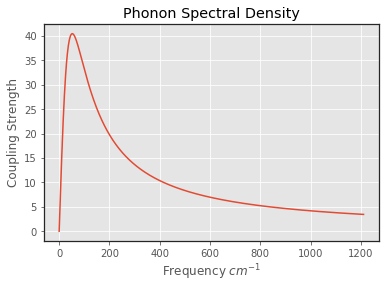

T_ph=30.0
w_RC= 887.205  TLS splitting = 806.55 RC-res. coupling= 2.71544348627  N= 15 TLS-RC coupling= 133.751186233 Gamma_RC=  15137.1675389 alpha_ph= 12.8366419351 beta= 0.0479616306954
eps: 806.55, alpha: 12.8366419351, w0: 887.205, Gamma: 15137.1675389, beta: 0.0479616306954
Exact solution 57.143 percent finished
Exact solution took 21.6539390087 to calculate.


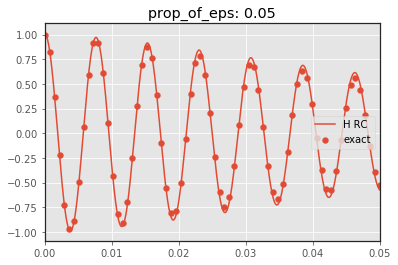

T_ph=30.0
w_RC= 887.205  TLS splitting = 806.55 RC-res. coupling= 2.71544348627  N= 15 TLS-RC coupling= 313.674335901 Gamma_RC=  15137.1675389 alpha_ph= 70.6015306429 beta= 0.0479616306954
eps: 806.55, alpha: 70.6015306429, w0: 887.205, Gamma: 15137.1675389, beta: 0.0479616306954
Exact solution 57.143 percent finished
Exact solution took 43.982175827 to calculate.


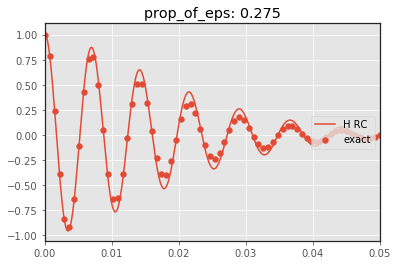

T_ph=30.0
w_RC= 887.205  TLS splitting = 806.55 RC-res. coupling= 2.71544348627  N= 15 TLS-RC coupling= 422.958388246 Gamma_RC=  15137.1675389 alpha_ph= 128.366419351 beta= 0.0479616306954
eps: 806.55, alpha: 128.366419351, w0: 887.205, Gamma: 15137.1675389, beta: 0.0479616306954
Exact solution 57.143 percent finished
Exact solution took 56.1151089668 to calculate.


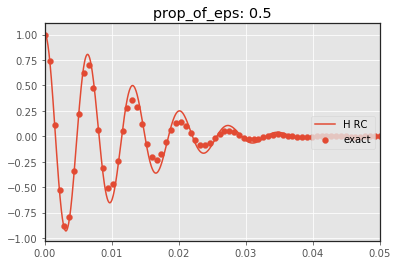

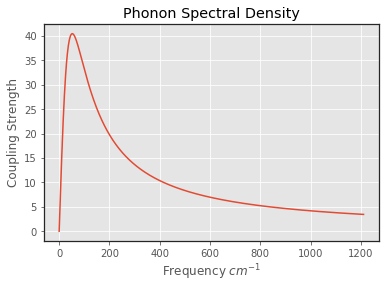

T_ph=300.0
w_RC= 887.205  TLS splitting = 806.55 RC-res. coupling= 2.71544348627  N= 15 TLS-RC coupling= 133.751186233 Gamma_RC=  15137.1675389 alpha_ph= 12.8366419351 beta= 0.00479616306954
eps: 806.55, alpha: 12.8366419351, w0: 887.205, Gamma: 15137.1675389, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 45.6962599754 to calculate.


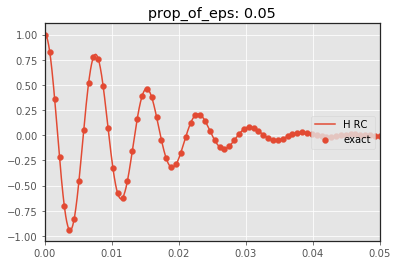

T_ph=300.0
w_RC= 887.205  TLS splitting = 806.55 RC-res. coupling= 2.71544348627  N= 15 TLS-RC coupling= 433.40337804 Gamma_RC=  15137.1675389 alpha_ph= 134.784740318 beta= 0.00479616306954
eps: 806.55, alpha: 134.784740318, w0: 887.205, Gamma: 15137.1675389, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 72.5484809875 to calculate.


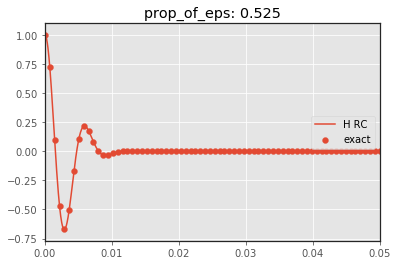

T_ph=300.0
w_RC= 887.205  TLS splitting = 806.55 RC-res. coupling= 2.71544348627  N= 15 TLS-RC coupling= 598.153488977 Gamma_RC=  15137.1675389 alpha_ph= 256.732838702 beta= 0.00479616306954
eps: 806.55, alpha: 256.732838702, w0: 887.205, Gamma: 15137.1675389, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 77.4660799503 to calculate.


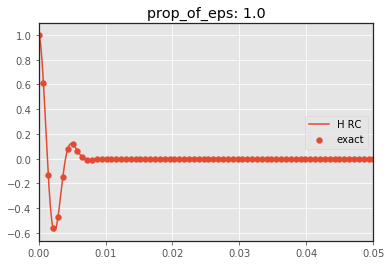

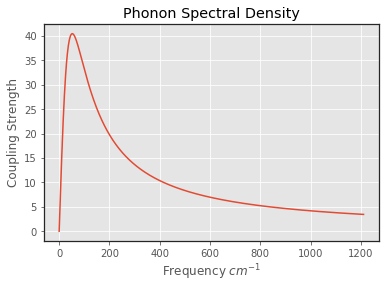

T_ph=80.0
w_RC= 887.205  TLS splitting = 806.55 RC-res. coupling= 2.71544348627  N= 25 TLS-RC coupling= 133.751186233 Gamma_RC=  15137.1675389 alpha_ph= 12.8366419351 beta= 0.0179856115108
eps: 806.55, alpha: 12.8366419351, w0: 887.205, Gamma: 15137.1675389, beta: 0.0179856115108
Exact solution 57.143 percent finished
Exact solution took 34.6186680794 to calculate.


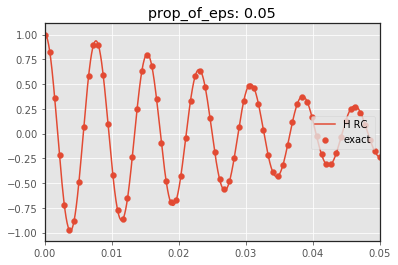

T_ph=80.0
w_RC= 887.205  TLS splitting = 806.55 RC-res. coupling= 2.71544348627  N= 25 TLS-RC coupling= 433.40337804 Gamma_RC=  15137.1675389 alpha_ph= 134.784740318 beta= 0.0179856115108
eps: 806.55, alpha: 134.784740318, w0: 887.205, Gamma: 15137.1675389, beta: 0.0179856115108
Exact solution 57.143 percent finished
Exact solution took 57.6825051308 to calculate.


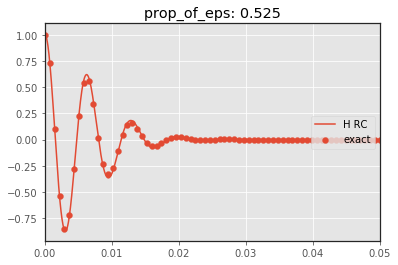

T_ph=80.0
w_RC= 887.205  TLS splitting = 806.55 RC-res. coupling= 2.71544348627  N= 25 TLS-RC coupling= 598.153488977 Gamma_RC=  15137.1675389 alpha_ph= 256.732838702 beta= 0.0179856115108
eps: 806.55, alpha: 256.732838702, w0: 887.205, Gamma: 15137.1675389, beta: 0.0179856115108
Exact solution 57.143 percent finished
Exact solution took 69.8443129063 to calculate.


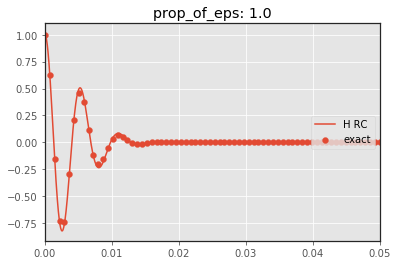

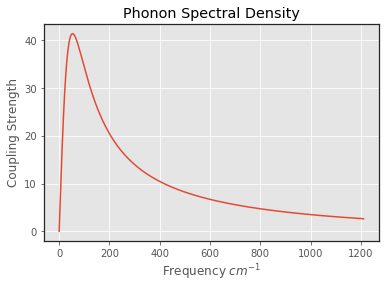

T_ph=300.0
w_RC= 322.62  TLS splitting = 806.55 RC-res. coupling= 0.987433995006  N= 28 TLS-RC coupling= 80.655 Gamma_RC=  2001.60893077 alpha_ph= 12.8366419351 beta= 0.00479616306954
eps: 806.55, alpha: 12.8366419351, w0: 322.62, Gamma: 2001.60893077, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 30.8012471199 to calculate.


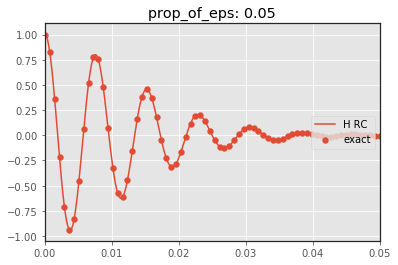

T_ph=300.0
w_RC= 322.62  TLS splitting = 806.55 RC-res. coupling= 0.987433995006  N= 28 TLS-RC coupling= 261.352070515 Gamma_RC=  2001.60893077 alpha_ph= 134.784740318 beta= 0.00479616306954
eps: 806.55, alpha: 134.784740318, w0: 322.62, Gamma: 2001.60893077, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 45.4999370575 to calculate.


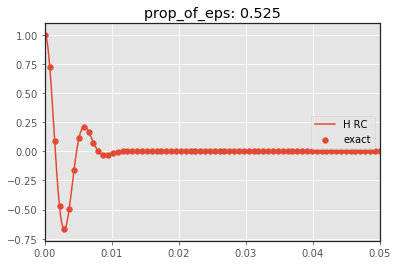

T_ph=300.0
w_RC= 322.62  TLS splitting = 806.55 RC-res. coupling= 0.987433995006  N= 28 TLS-RC coupling= 360.70012545 Gamma_RC=  2001.60893077 alpha_ph= 256.732838702 beta= 0.00479616306954
eps: 806.55, alpha: 256.732838702, w0: 322.62, Gamma: 2001.60893077, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 64.6587760448 to calculate.


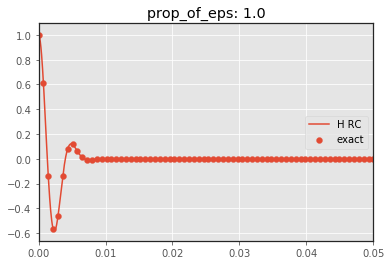

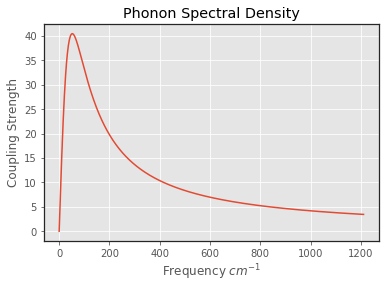

T_ph=1000.0
w_RC= 887.205  TLS splitting = 806.55 RC-res. coupling= 2.71544348627  N= 26 TLS-RC coupling= 133.751186233 Gamma_RC=  15137.1675389 alpha_ph= 12.8366419351 beta= 0.00143884892086
eps: 806.55, alpha: 12.8366419351, w0: 887.205, Gamma: 15137.1675389, beta: 0.00143884892086
Exact solution 57.143 percent finished
Exact solution took 41.5432770252 to calculate.


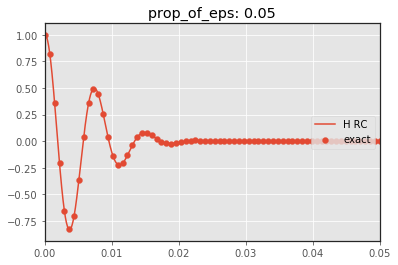

T_ph=1000.0
w_RC= 887.205  TLS splitting = 806.55 RC-res. coupling= 2.71544348627  N= 26 TLS-RC coupling= 433.40337804 Gamma_RC=  15137.1675389 alpha_ph= 134.784740318 beta= 0.00143884892086
eps: 806.55, alpha: 134.784740318, w0: 887.205, Gamma: 15137.1675389, beta: 0.00143884892086


KeyboardInterrupt: 

In [29]:
reload(RC)
reload(EM)
reload(check)
reload(exact)

w0 = 0.4*500
Gamma = (w0**2)/53.
#exact.plot_integrand(beta_f(300), 50., Gamma, w0)

def exact_comparison_alpha(eps, w0_prop, Gamma_, N=3, overdamped=False, T_ph=300., upper_alpha=1.):
    timelist_exact = np.linspace(0, 0.05, 70)
    timelist = np.linspace(0, 0.05, 1000)
    w0 = eps*w0_prop
    n_RC = EM.Occupation(w0, T_ph)
    if overdamped:
        Gamma_ = (w0**2)/wc
    w = np.linspace(0., eps*1.5, 1000)
    plt.figure()
    alpha_ph = 0.1*eps
    plt.plot(w, J_underdamped(w, alpha_ph, Gamma_, w0))
    plt.ylabel("Coupling Strength")
    plt.xlabel(r"Frequency $cm^{-1}$")
    plt.title("Phonon Spectral Density")
    plt.legend()
    plt.show()
    
    exact_sol = []
    rc_sol = []
    prop_of_eps = np.linspace(0.05, upper_alpha, 3)
    for prop in prop_of_eps:
        # how well
        alpha = prop*eps/pi
        beta = beta_f(T_ph)#1/(0.695*T_ph)
        ti = time.time()
        
        print "T_ph={}".format(T_ph)
        #print "Exact solution took {} seconds.".format(time.time()-ti)
        expects = [tensor(G*G.dag(), qeye(N)), tensor(E*G.dag()+G*E.dag(), qeye(N)), 
               tensor(E*E.dag(), qeye(N)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
               tensor(qeye(2), destroy(N).dag()+destroy(N))]
        rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
        #DATA_wc = mesolve(H_S, initial_sys, timelist, [L_wc], expects_wc, progress_bar=True)
        L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma= RC.RC_function_UD(sigma, eps, 
                                                                       T_ph, Gamma_, 
                                                                       w0, alpha, N)
        #print H_RC.eigenenergies()
        #print eps-0.5*np.pi*alpha, eps+w0, eps-0.5*np.pi*alpha+w0
        try:
            DATA_sc = mesolve(H_RC, rho_0, timelist, [L_RC], 
                              expects, options=qt.Options(nsteps=1000)).expect[1].real
        except:
            DATA_sc = mesolve(H_RC, rho_0, timelist, [L_RC], 
                              expects, options=qt.Options(nsteps=15000)).expect[1].real
        rho_01 = np.array(exact.exact_dynamics(eps, alpha, wc, 
                                               w0, Gamma_, beta, initial_sys, 
                                               timelist_exact, overdamped=overdamped))
        #exact_sol.append(rho_01.real)
        #rc_sol.append(DATA_sc.real)
        plt.figure()
        plt.title("prop_of_eps: {}".format(prop))
        plt.scatter(timelist_exact, rho_01, label="exact", linewidth='0.3')
        plt.plot(timelist, DATA_sc, label="H RC")
        plt.xlim(0,timelist[-1])
        # Everything is oscillating at the shifted frequency
        #plt.plot(timelist, 0.5*np.exp((-50.-1j*(eps-shift))*timelist)) 
        sigmaX_values = [[], []]
        with open("DATA/alpha_epsilon_underdamped.dat", "r") as f:
            data = f.read()
            for row in data.split('\n'):
                row = row.split('\t')
                sigmaX_values[0].append(row[0])
                sigmaX_values[1].append(row[1])
        #plt.plot(sigmaX_values[0], sigmaX_values[1], label='Ahsan RC')
        plt.legend(loc='right')
        plt.show()

eps= 0.1*8065.5
exact_comparison_alpha(eps, 1.1, 0, N=15,T_ph=30., overdamped=True, upper_alpha=0.5)
exact_comparison_alpha(eps, 1.1, 0, N=15, overdamped=True)
exact_comparison_alpha(eps, 1.1, 0, N=25,T_ph=80., overdamped=True)
exact_comparison_alpha(eps, 0.4, 0, N=28,T_ph=300., overdamped=True)
exact_comparison_alpha(eps, 1.1, 0, N=26,T_ph=1000., overdamped=True)



UNDERDAMPED SDs


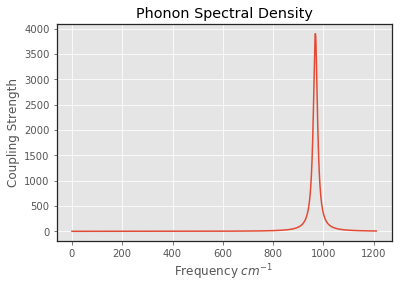

T_ph=300.0
w_RC= 967.86  TLS splitting = 806.55 RC-res. coupling= 0.00328880092352  N= 25 TLS-RC coupling= 139.698557884 Gamma_RC=  20 alpha_ph= 12.8366419351 beta= 0.00479616306954
eps: 806.55, alpha: 12.8366419351, w0: 967.86, Gamma: 20, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 29.3668971062 to calculate.


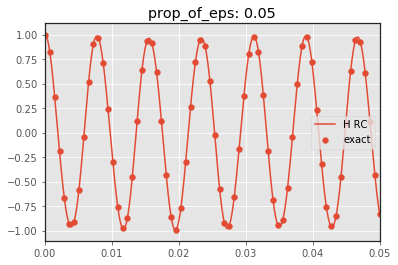

T_ph=300.0
w_RC= 967.86  TLS splitting = 806.55 RC-res. coupling= 0.00328880092352  N= 25 TLS-RC coupling= 452.675064795 Gamma_RC=  20 alpha_ph= 134.784740318 beta= 0.00479616306954
eps: 806.55, alpha: 134.784740318, w0: 967.86, Gamma: 20, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 42.0425100327 to calculate.


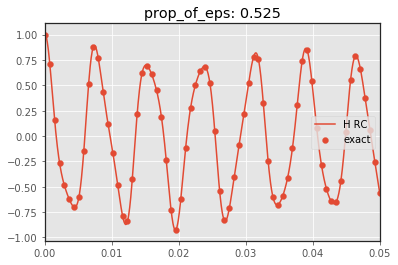

T_ph=300.0
w_RC= 967.86  TLS splitting = 806.55 RC-res. coupling= 0.00328880092352  N= 25 TLS-RC coupling= 624.750943577 Gamma_RC=  20 alpha_ph= 256.732838702 beta= 0.00479616306954
eps: 806.55, alpha: 256.732838702, w0: 967.86, Gamma: 20, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 42.6923639774 to calculate.


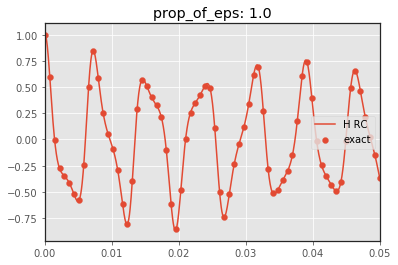

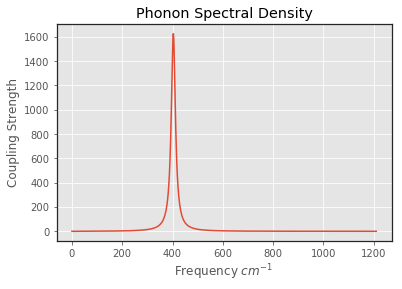

T_ph=300.0
w_RC= 403.275  TLS splitting = 806.55 RC-res. coupling= 0.00789312221645  N= 25 TLS-RC coupling= 90.1750313626 Gamma_RC=  20 alpha_ph= 12.8366419351 beta= 0.00479616306954
eps: 806.55, alpha: 12.8366419351, w0: 403.275, Gamma: 20, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 14.6072218418 to calculate.


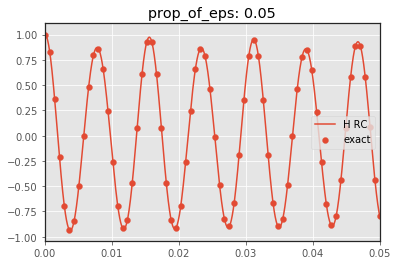

T_ph=300.0
w_RC= 403.275  TLS splitting = 806.55 RC-res. coupling= 0.00789312221645  N= 25 TLS-RC coupling= 292.200497866 Gamma_RC=  20 alpha_ph= 134.784740318 beta= 0.00479616306954
eps: 806.55, alpha: 134.784740318, w0: 403.275, Gamma: 20, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 31.1704580784 to calculate.


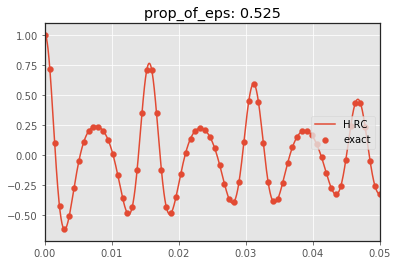

T_ph=300.0
w_RC= 403.275  TLS splitting = 806.55 RC-res. coupling= 0.00789312221645  N= 25 TLS-RC coupling= 403.275 Gamma_RC=  20 alpha_ph= 256.732838702 beta= 0.00479616306954
eps: 806.55, alpha: 256.732838702, w0: 403.275, Gamma: 20, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 27.8523929119 to calculate.


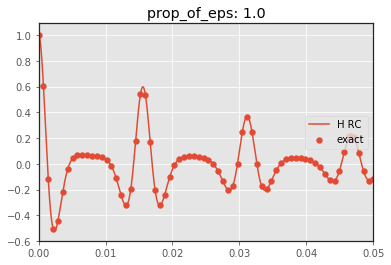

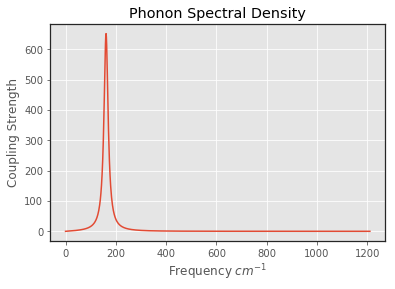

T_ph=300.0
w_RC= 161.31  TLS splitting = 806.55 RC-res. coupling= 0.0197328055411  N= 27 TLS-RC coupling= 57.0316974366 Gamma_RC=  20 alpha_ph= 12.8366419351 beta= 0.00479616306954
eps: 806.55, alpha: 12.8366419351, w0: 161.31, Gamma: 20, beta: 0.00479616306954
Exact solution 57.143 percent finished
Exact solution took 12.9920699596 to calculate.


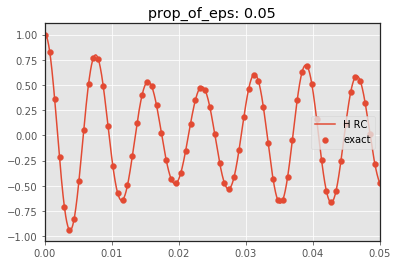

T_ph=300.0
w_RC= 161.31  TLS splitting = 806.55 RC-res. coupling= 0.0197328055411  N= 27 TLS-RC coupling= 184.803821338 Gamma_RC=  20 alpha_ph= 134.784740318 beta= 0.00479616306954
eps: 806.55, alpha: 134.784740318, w0: 161.31, Gamma: 20, beta: 0.00479616306954


KeyboardInterrupt: 

In [30]:
print "UNDERDAMPED SDs"
#exact_comparison_alpha(eps, 0.4, ((0.4*eps)**2)/wc, N=25,T_ph=300., overdamped=False)
exact_comparison_alpha(eps, 1.2, 20, N=25, overdamped=False)
exact_comparison_alpha(eps, 1./2., 20, N=25, overdamped=False)
exact_comparison_alpha(eps, 1./5., 20, N=27, overdamped=False)
exact_comparison_alpha(eps, 1./20., 20, N=33, overdamped=False, upper_alpha=2.)
#exact_comparison_alpha(eps, 1., 10., N=33, overdamped=False, upper_alpha=2.)

So we can see that for broad overdamped environments the RC method works extremely well in all of the above regimes: including strongly coupled underdamped modes. The only time it really fails is with strongly-coupled, low-temperature environments.

In [ ]:
exact_comparison_alpha(eps, 53./eps, 53., N=26,T_ph=300., overdamped=False, upper_alpha=2.)
exact_comparison_alpha(eps, 53./eps, 0, N=26,T_ph=300., overdamped=True, upper_alpha=2.)


## Convergence of optical driving code: wrt N

Now we will check steadystate convergence with respect to N including optical driving.

In [31]:
w0 = eps*1.1
wc = 52.
Gamma = (w0**2)/wc

def driving_convergence_N(alpha_prop, w0_prop, Gamma_, T_EM=6000., T_ph=300., overdamped=False):
    e0_population = [[],[],[]]
    g1_population = [[],[],[]]
    excited_population = [[],[],[]]
    labels = ['nrwa', 'non-sec', 'naive']
    alpha_ph = eps*alpha_prop
    shift = 0.5*np.pi*alpha_ph
    w0 = eps*w0_prop
    if overdamped:
        Gamma_ = (w0**2)/wc
    #w = np.linspace(0., eps, 1000)
    #plt.figure()
    #plt.plot(w, J_underdamped(w, alpha_ph, Gamma_, w0))
    #plt.axvline(eps-shift, label='Splitting',color='k')
    #plt.ylabel("Coupling Strength")
    #plt.xlabel(r"Frequency $cm^{-1}$")
    #plt.title("Phonon Spectral Density")
    #plt.legend()
    #plt.show()
    n_RC = EM.Occupation(w0, T_ph)
    N_values = range(3,23)
    for n in N_values:
        rho_0 = tensor(initial_sys, thermal_dm(n, n_RC))
        #print (rho_0*tensor(qeye(2), destroy(N).dag()*destroy(N))).tr()
        excited_state = tensor(E*E.dag(), qt.qeye(n))
        # Expectation values and time increments needed to calculate the dynamics
        expects = [tensor(G*G.dag(), qeye(n)), tensor(E*G.dag(), qeye(n)), 
               tensor(E*E.dag(), qeye(n)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
               tensor(qeye(2), destroy(n).dag()+destroy(n))]
        ti = time.time()
        L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma_1= RC.RC_function_UD(
                                                    sigma, eps, T_ph, Gamma_, 
                                                    w0, alpha_ph, n, silent=True)
        evals, states = H_RC.eigenstates()
        ground_list = []
        excited_list = []
        for i in range(len(evals)):
            is_ground = sum(states[i])[0][0].real == 1.
            if is_ground:
                ground_list.append(i)
            else:
                excited_list.append(i)
        
        L= [EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM, silent=True), 
            EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J_EM, silent=True),
            EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J_EM, silent=True)]
        
        for j, L_EM in enumerate(L):
            ss = steadystate(H_RC, [L_RC+L_EM])
            state = states[excited_list[1]]
            e0_population[j].append(ss.matrix_element(state.dag(), state))
            state = states[ground_list[1]]
            g1_population[j].append(ss.matrix_element(state.dag(), state))
            excited_population[j].append((ss*excited_state).tr())
        tf = time.time()
        if n%5==0:
            print " ** Steady states took: {}s. {}% finished**".format(tf-ti, 100*n/float(len(N_values)))
    plt.figure()
    for i in range(len(e0_population)):
        plt.ylabel('e-0 population')
        plt.xlabel('N')
        plt.plot(N_values, e0_population[i], label=labels[i])
        plt.legend()
    plt.figure()
    for i in range(len(g1_population)):
        plt.ylabel('g-1 population')
        plt.xlabel('N')
        plt.plot(N_values, g1_population[i], label=labels[i])
        plt.legend()
    plt.figure()
    for i in range(len(excited_population)):
        plt.ylabel('e population')
        plt.xlabel('N')
        plt.plot(N_values, excited_population[i], label=labels[i])
        plt.legend()
    plt.show()


Low frequency underdamped
 ** Steady states took: 0.971544981003s. 25.0% finished**
 ** Steady states took: 1.31808805466s. 50.0% finished**
 ** Steady states took: 1.98672509193s. 75.0% finished**
 ** Steady states took: 3.77307415009s. 100.0% finished**


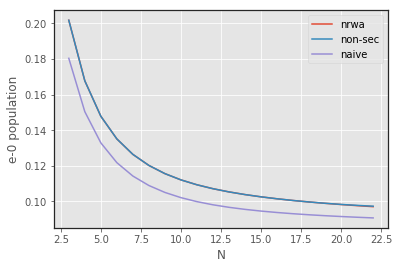

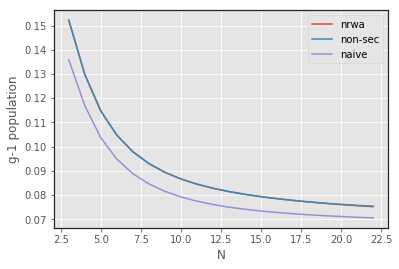

medium frequency underdamped
 ** Steady states took: 0.25606584549s. 25.0% finished**
 ** Steady states took: 0.878252029419s. 50.0% finished**
 ** Steady states took: 1.94690084457s. 75.0% finished**
 ** Steady states took: 6.08903694153s. 100.0% finished**


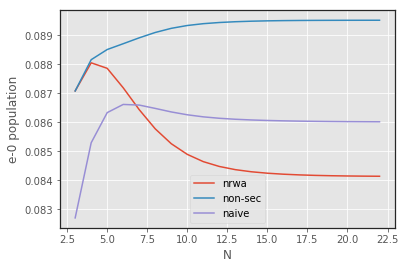

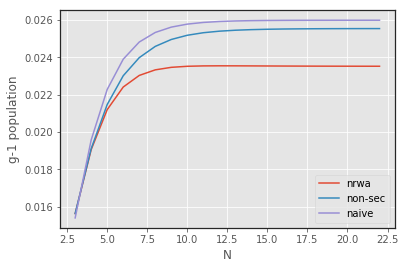

Overdamped: $\omega_0=\epsilon$
 ** Steady states took: 0.320301055908s. 25.0% finished**
 ** Steady states took: 0.85133600235s. 50.0% finished**
 ** Steady states took: 2.64687609673s. 75.0% finished**
 ** Steady states took: 5.11688899994s. 100.0% finished**


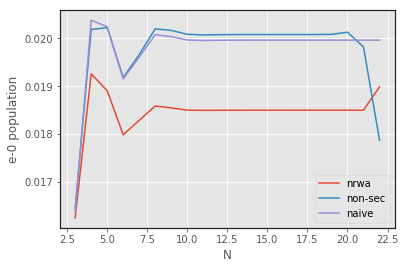

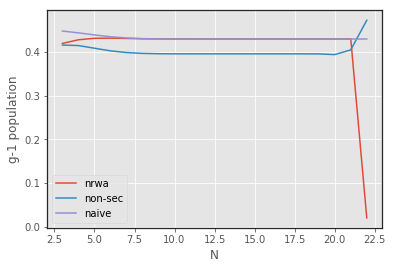

Overdamped: $\omega_0=1.5\epsilon$
 ** Steady states took: 0.242336988449s. 25.0% finished**
 ** Steady states took: 1.21051692963s. 50.0% finished**
 ** Steady states took: 1.9255168438s. 75.0% finished**
 ** Steady states took: 5.18718099594s. 100.0% finished**


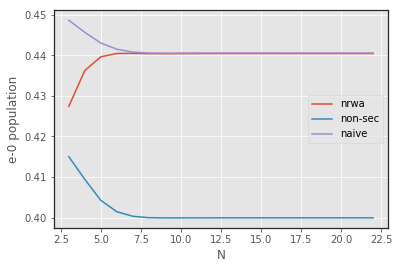

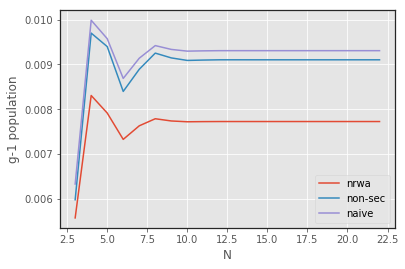

In [46]:
print "Low frequency underdamped"
driving_convergence_N(1., 1./14., 30.)
print "medium frequency underdamped"
driving_convergence_N(1., 1./2, 30.)
print "Overdamped: $\omega_0=\epsilon$"
driving_convergence_N(1., 1., 0, overdamped=True)
print "Overdamped: $\omega_0=1.5\epsilon$"
driving_convergence_N(1., 1.5, 0, overdamped=True)

 ** Steady states took: 0.241711139679s. 25.0% finished**
 ** Steady states took: 0.8636739254s. 50.0% finished**
 ** Steady states took: 1.9770898819s. 75.0% finished**
 ** Steady states took: 3.91309809685s. 100.0% finished**


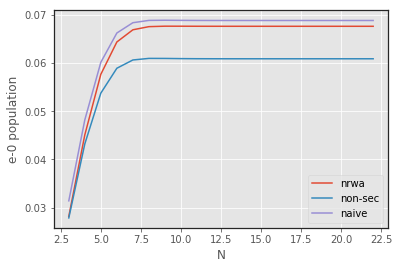

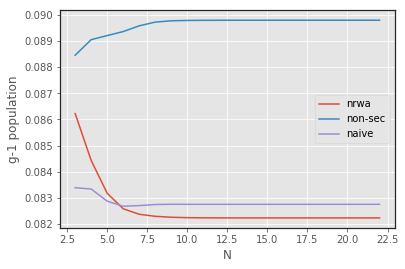

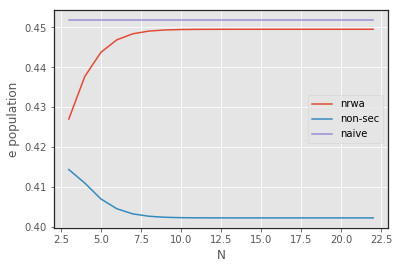

 ** Steady states took: 0.267405986786s. 25.0% finished**
 ** Steady states took: 0.884179115295s. 50.0% finished**
 ** Steady states took: 2.22018790245s. 75.0% finished**
 ** Steady states took: 4.76777482033s. 100.0% finished**


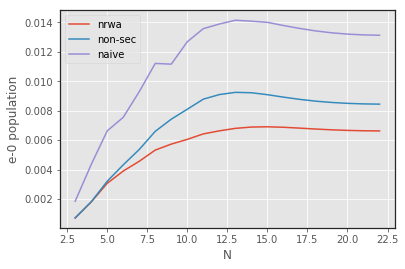

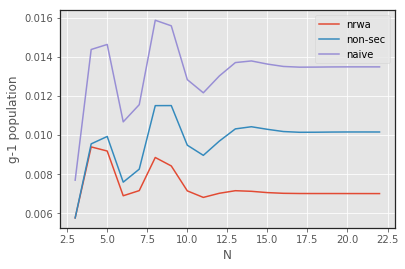

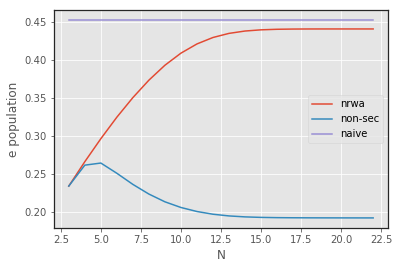

In [32]:
driving_convergence_N(1., 1.5, 0, T_EM=6000., T_ph=1000.,overdamped=True)
driving_convergence_N(5., 1.5, 0, T_EM=6000., T_ph=300.,overdamped=True)

Above, we can see that the overdamped steadystates are very unstable when $\omega_0 = \epsilon$, due to many degeneracies/near-degeneracies in the spectrum. Things are more stable when choosing $\omega_0 = 1.1\epsilon$ for example, and steady states converge by about N=12 for strong coupling. For low frequency and underdamped, things converge more slowly.

## instantaneous decay rates: $\omega_{RC}$ dependence
Check convergence of decay rates with w0. With $\omega_0>\epsilon$ we hope to see the decay rates converge.

In [81]:
from qutip import vector_to_operator, operator_to_vector, basis


def decay_rate_wRC_dependence(eps, T_ph, alpha_ph, Gamma, T_EM=0., overdamped=True, nvib=3):
    omega_0_props = np.linspace(0.01, 4., 50)
    omega_0 = omega_0_props*eps
    
    #displacements = alpha_ph/w0
    N = 19
    
    decay_wrt_wRC = [[],[],[],[]]
    labels = ['g-0',  'g-1', 'g-2','ground']
    count = 1
    for w0 in omega_0:
        if count%5 == 0:
            print "{}% complete.".format((100.*count)/len(omega_0_props))
        count+=1
        if overdamped:
            Gamma = (w0**2)/wc
        else:
            pass
        
        if w0 > eps*0.3:
            N = 14
        L_RC, H, A_EM, A_nrwa, wRC, kappa, Gamma_1 = RC.RC_function_UD(
                                            sigma, eps, T_ph, Gamma, w0, 
                                            alpha_ph, N , silent=True)
        print Gamma
    # given some Liouvillian, find the instantaneous decay rates
    # from e-0 to the ground manifold eigenstates, for several
    # oscillator displacements
    # - need to find the first eigenstate in the excited manifold
        evals, states = H.eigenstates()
        ground_list = []
        excited_list = []
        for i in range(len(evals)):
            is_ground = sum(states[i])[0][0].real == 1.
            if is_ground:
                ground_list.append(i)
            else:
                excited_list.append(i)
        excited_ket = states[excited_list[0]]
        
        #initial_ket = tensor(basis(2,1), basis(N,0))
        excited_rho = excited_ket*excited_ket.dag()
        S_plus, S_minus, S_0 = RWA_system_ops(H_RC, A_nrwa)
        L= [EM.L_non_rwa(H, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM, silent=True), 
            EM.L_nonsecular(H, A_EM, eps, Gamma_EM, T_EM, J=J_EM, silent=True),
            EM.L_nonsecular(H, S_minus, eps, Gamma_EM, T_EM, J=J_EM, silent=True),
            EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J_EM, silent=True)]
        for i_, L_EM in enumerate(L):
            decay_rates = [] # not really decay rates but population at short times
            for j in range(nvib-1):
                ground_ket = tensor(basis(2,0), basis(N,j))
                #print states[ground_list][j].dag()*target_ket
                #target_rho = operator_to_vector(target_ket*target_ket.dag())
                L_rho0_prod = vector_to_operator(L_EM*operator_to_vector(excited_ket*excited_ket.dag()))
                rate = L_rho0_prod.matrix_element(ground_ket.dag(), ground_ket)
                decay_rates.append(rate)
            #print states[ground_list][j].dag()*target_ket
            #target_rho = operator_to_vector(target_ket*target_ket.dag())
            L_rho0_prod = vector_to_operator(L_EM*operator_to_vector(excited_ket*excited_ket.dag()))
            rate = L_rho0_prod.ptrace(0).matrix_element(basis(2,0).dag(), basis(2,0))
            decay_rates.append(rate)
            if len(decay_rates)!=nvib:
                print ground_list
            decay_wrt_wRC[i_].append(decay_rates)
    for level in range(nvib): 
        plt.figure()
        plt.title(labels[level])
        plt.plot(omega_0_props, np.array(decay_wrt_wRC[0]).T[level], label='full')
        plt.plot(omega_0_props, np.array(decay_wrt_wRC[1]).T[level], label='naive RWA', linestyle='dashed')
        plt.plot(omega_0_props, np.array(decay_wrt_wRC[2]).T[level], label='RWA', linestyle='dotted')
        plt.plot(omega_0_props, np.array(decay_wrt_wRC[3]).T[level], label='additive')
        plt.legend()
        plt.xlabel(r'Oscillator Frequency (units of $\epsilon$)')
        plt.ylabel('Rate to {}'.format(labels[level]))
    plt.show()
    return omega_0_props, decay_wrt_wRC
    #for i, alpha in enumerate(alpha_ph):
    #    plt.plot(decay_wrt_alpha[i])


In [82]:
omega_0_props, decay_wrt_wRC = decay_rate_wRC_dependence(eps, 300., eps*0.1, 8., overdamped=True, nvib=4)

ValueError: too many values to unpack

10.0% complete.
20.0% complete.
30.0% complete.
40.0% complete.
50.0% complete.
60.0% complete.
70.0% complete.
80.0% complete.
90.0% complete.
100.0% complete.


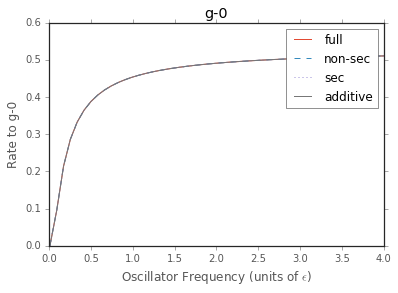

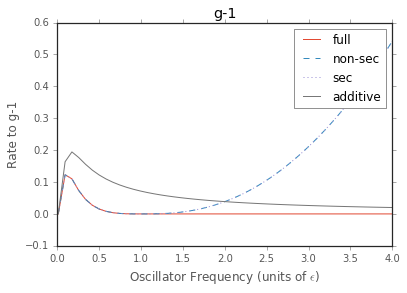

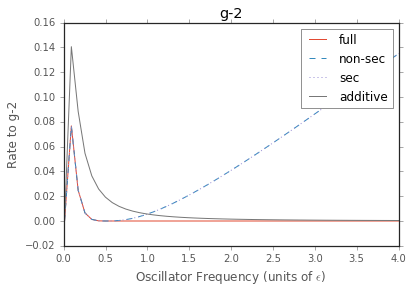

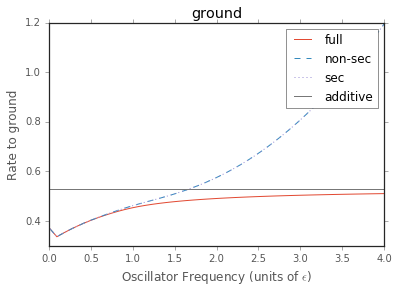

In [40]:
omega_0_props, decay_wrt_wRC = decay_rate_wRC_dependence(eps, 300., eps*0.1, 8., overdamped=False, nvib=4)

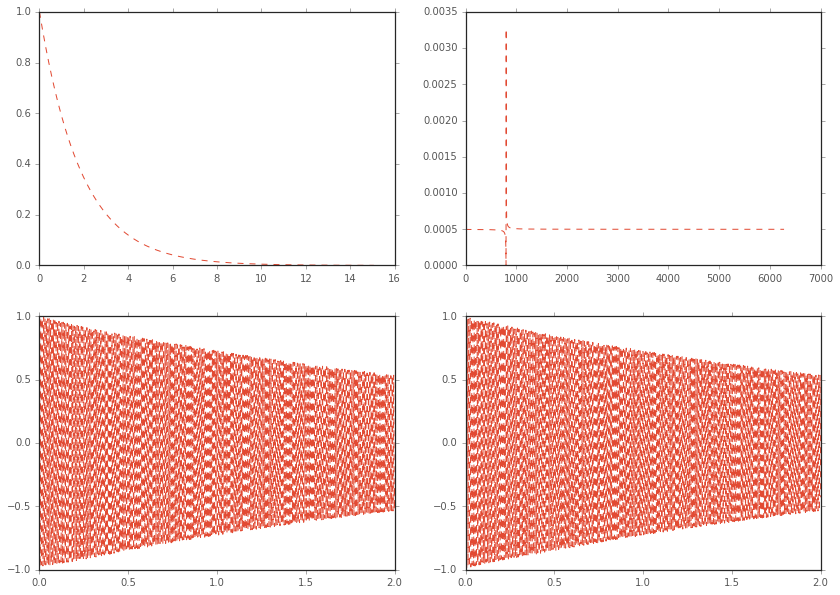

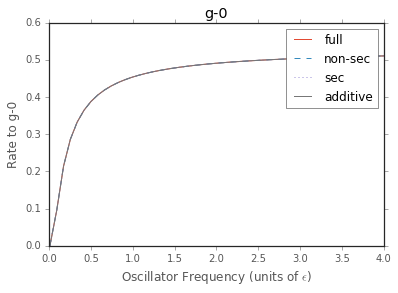

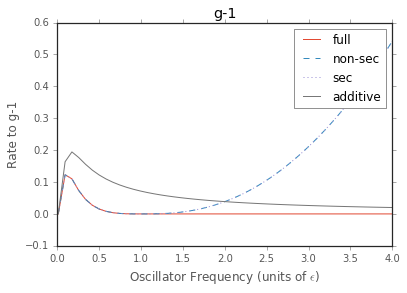

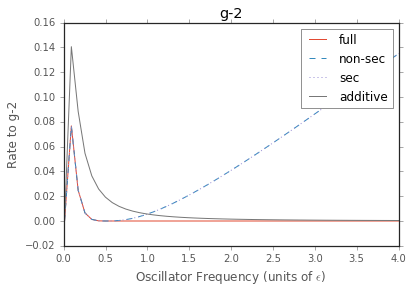

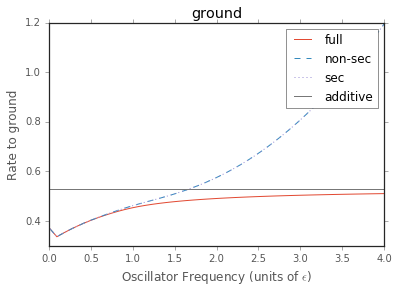

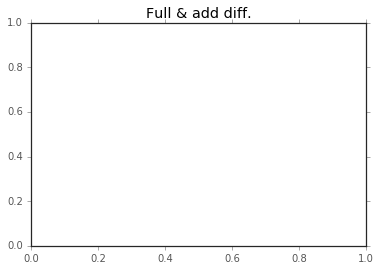

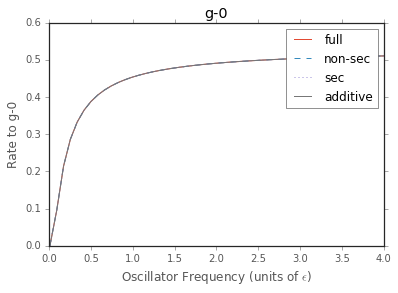

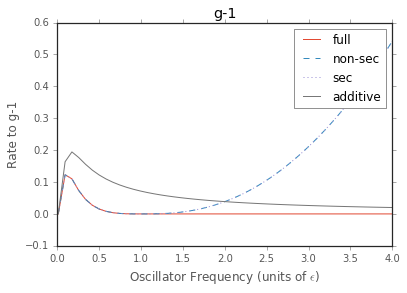

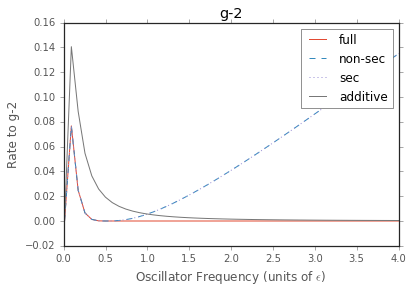

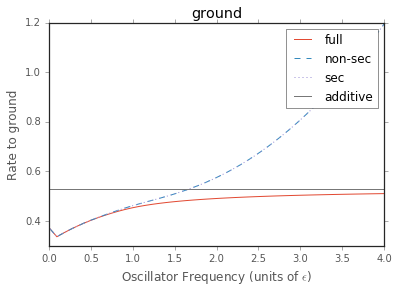

In [28]:
plt.show()

## Steadystate convergence: $\omega_{RC}$ dependence
Now convergence of steadystates with respect to $\omega_{RC}$, since although the rates for lowest lying states (particularly for naive) are not converged well into $\omega_{RC}>\epsilon$, this may not affect the steady states. If so at high T, it might not at low T.

In [287]:
w0 = eps*1.1
wc = 52.
Gamma = (w0**2)/wc

def driving_convergence_wRC(eps, alpha_prop, T_EM=6000., T_ph=300., 
                            overdamped=False, min_w0_prop=0.01,
                            max_w0_prop=4., Gamma=20.):
    omega_0_props = np.linspace(min_w0_prop, int(max_w0_prop*0.2), 25)
    omega_0 = omega_0_props*eps
    #displacements = alpha_ph/w0
    N = 20
    count = 1
    data = []
    labels = ['nrwa', 'non-sec','sec', 'naive']
    
    alpha_ph = eps*alpha_prop/pi
    shift = 0.5*np.pi*alpha_ph

    for w0 in omega_0:
        
        if overdamped:
            Gamma = w0**2/wc
            if w0 > eps*0.2:
                N = 18#25
            if w0 > eps*0.7:
                N=14#14
        else:
            Gamma = Gamma
            if w0 <0.6*eps:
                N=35

        
        n_RC = EM.Occupation(w0, T_ph)
        rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
        #print (rho_0*tensor(qeye(2), destroy(N).dag()*destroy(N))).tr()

        # Expectation values and time increments needed to calculate the dynamics
        expects = [tensor(G*G.dag(), qeye(N)), tensor(E*G.dag(), qeye(N)), 
               tensor(E*E.dag(), qeye(N)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
               tensor(qeye(2), destroy(N).dag()+destroy(N))]
        ti = time.time()
        L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma_1= RC.RC_function_UD(
                                                    sigma, eps, T_ph, Gamma, 
                                                    w0, alpha_ph, N, silent=True)
        evals, states = H_RC.eigenstates()
        ground_list = []
        excited_list = []
        for i in range(len(evals)): #
            is_ground = sum(states[i])[0][0].real == 1.
            if is_ground:
                ground_list.append(i)
            else:
                excited_list.append(i)
        L= [EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM, silent=True), 
            EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J_EM, silent=True),
            EM.L_vib_lindblad(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J_EM, silent=True),
            EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J_EM, silent=True)]
        obs_states = [states[i] for i in [excited_list[0],excited_list[1],
                                          ground_list[0],ground_list[1],
                                          ground_list[2]]]
        d1 = []
        for j, L_EM in enumerate(L):
            ss = steadystate(H_RC, [L_RC+L_EM])
            d2 = []
            for i, state in enumerate(obs_states):    
                d2.append(ss.matrix_element(state.dag(), state).real)
            d2.append((ss.ptrace(0)).matrix_element(G.dag(), G))
            d1.append(d2)
        data.append(d1)
        tf = time.time()
        if count ==1 or count%5==0:
            print "{:0.2f}% finished".format((float(count)/len(omega_0))*100)
            print " ** The previous steady state took: {}s**".format(tf-ti)
        count+=1
        
    data = np.array(data).transpose((1,2,0))
    vib_states = ['e-0', 'e-1', 'g-0', 'g-1','g-2','ground']
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', figsize=(14,8))
    axes = [eval("ax{}".format(i)) for i in range(1,7)]    
    for j, title in enumerate(vib_states):
        for i in range(len(data)):
            axes[j].set_title(title)
            axes[j].plot(omega_0_props, data[i][j], label=labels[i])
            axes[j].set(xlabel=r'Oscillator frequency (units of $\epsilon$)', 
                                                       ylabel="Population")
    plt.tight_layout(pad=0.3, w_pad=0.3, h_pad=1.0)
    plt.legend()
    plt.show()
    
"""    
#driving_convergence_wRC(eps, 0.3, T_EM=0., overdamped=True)
driving_convergence_wRC(eps, 0.3, T_EM=6000., max_w0_prop=1.1, overdamped=True)
driving_convergence_wRC(eps, 0.3, T_EM=6000., min_w0_prop=1, overdamped=True)
driving_convergence_wRC(eps, 0.3, T_EM=6000., min_w0_prop=1, overdamped=True)
#driving_convergence_wRC(eps, 0.1, T_EM=6000., overdamped=True)"""

'    \n#driving_convergence_wRC(eps, 0.3, T_EM=0., overdamped=True)\ndriving_convergence_wRC(eps, 0.3, T_EM=6000., max_w0_prop=1.1, overdamped=True)\ndriving_convergence_wRC(eps, 0.3, T_EM=6000., min_w0_prop=1, overdamped=True)\ndriving_convergence_wRC(eps, 0.3, T_EM=6000., min_w0_prop=1, overdamped=True)\n#driving_convergence_wRC(eps, 0.1, T_EM=6000., overdamped=True)'

2.50% finished
 ** The previous steady state took: 23.5599780083s**
12.50% finished
 ** The previous steady state took: 19.8979408741s**
25.00% finished
 ** The previous steady state took: 6.62671017647s**
37.50% finished
 ** The previous steady state took: 4.93780016899s**
50.00% finished
 ** The previous steady state took: 4.72128391266s**
62.50% finished
 ** The previous steady state took: 5.37771081924s**
75.00% finished
 ** The previous steady state took: 2.86412596703s**
87.50% finished
 ** The previous steady state took: 2.68648195267s**
100.00% finished
 ** The previous steady state took: 2.83890295029s**


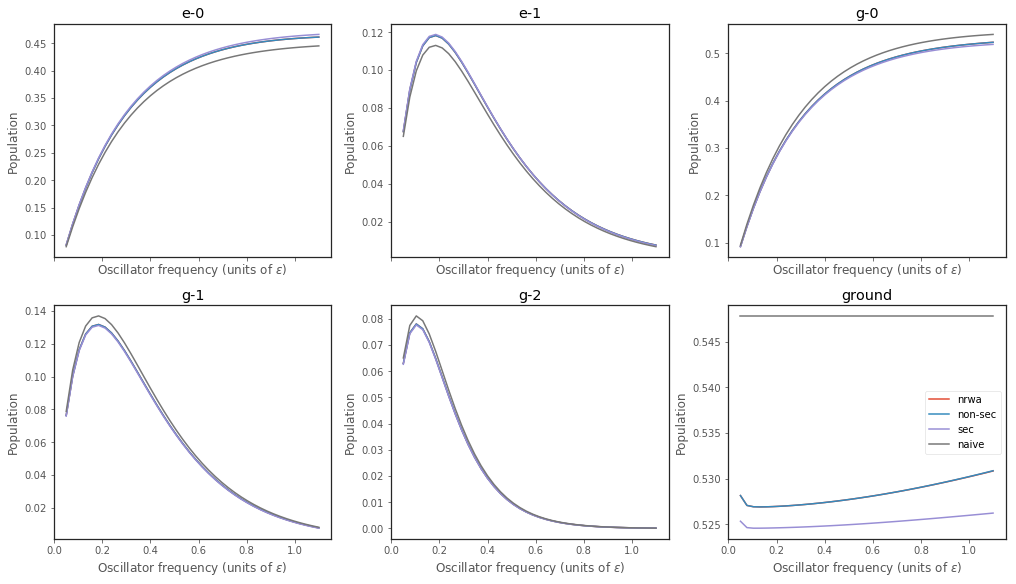

In [290]:
driving_convergence_wRC(eps, 0.05, T_EM=6000., min_w0_prop=0.05, max_w0_prop=1.1, overdamped=True)
#driving_convergence_wRC(eps, 0.1, T_EM=6000., min_w0_prop=1., overdamped=True)

2.50% finished
 ** The previous steady state took: 25.2777619362s**
12.50% finished
 ** The previous steady state took: 20.3855309486s**
25.00% finished
 ** The previous steady state took: 11.952064991s**
37.50% finished
 ** The previous steady state took: 11.571130991s**
50.00% finished
 ** The previous steady state took: 11.0197031498s**
62.50% finished
 ** The previous steady state took: 10.7185781002s**
75.00% finished
 ** The previous steady state took: 2.6208281517s**
87.50% finished
 ** The previous steady state took: 2.59813690186s**
100.00% finished
 ** The previous steady state took: 2.5952231884s**


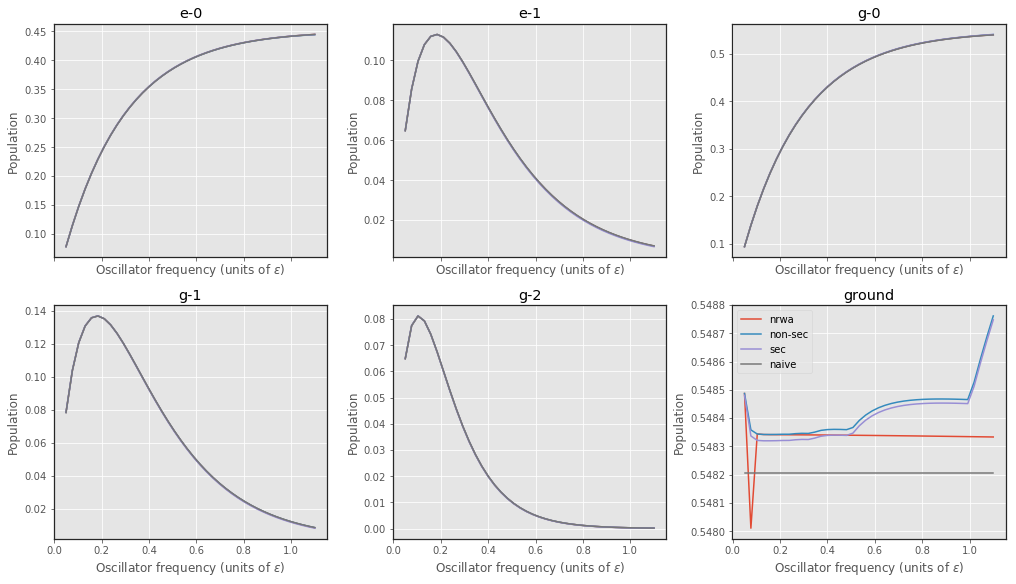

2.50% finished
 ** The previous steady state took: 2.58641719818s**
12.50% finished
 ** The previous steady state took: 2.67041492462s**
25.00% finished
 ** The previous steady state took: 2.65892386436s**
37.50% finished
 ** The previous steady state took: 2.88586401939s**
50.00% finished
 ** The previous steady state took: 2.58265995979s**
62.50% finished
 ** The previous steady state took: 2.73073601723s**
75.00% finished
 ** The previous steady state took: 2.68893003464s**
87.50% finished
 ** The previous steady state took: 2.61070990562s**
100.00% finished
 ** The previous steady state took: 2.59876203537s**


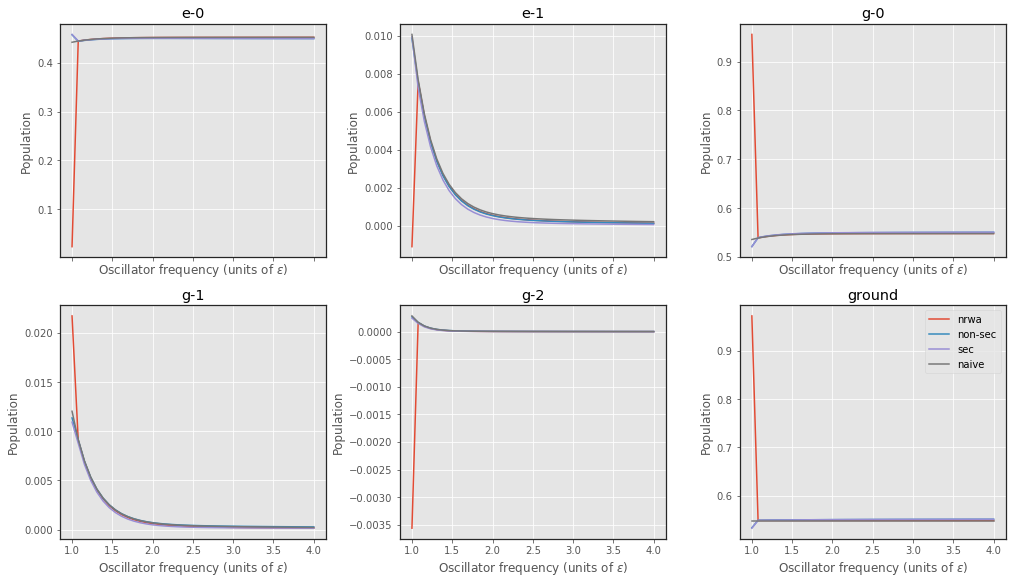

In [7]:
driving_convergence_wRC(eps, 0.05, T_EM=6000., min_w0_prop=0.05, max_w0_prop=1.1, overdamped=True)
driving_convergence_wRC(eps, 0.05, T_EM=6000., min_w0_prop=1., overdamped=True)

So we can see that the non-secular theory predicts steadystates which are very sensitive to $\omega_{RC}$, even when it is the same scale as $\epsilon$. This is counterintuitive since this is regime in which the specifics of the RC itself should not be so important (no longer single-mode like). This could be to do with the unphysical and non-thermodynamically stable processes that it allows. Although the phenomenological Lindblad theory has these processes as well, this is only incidental as the actual dissipator cannot see the vibronic levels at all, in actuality the only thing that matters about the Naive environment is the temperature and decay rate. The NS can see these levels but just deals with them inconsistently.

Now, underdamped spectral densities.

2.50% finished
 ** The previous steady state took: 63.5824260712s**
12.50% finished
 ** The previous steady state took: 49.8272049427s**
25.00% finished
 ** The previous steady state took: 47.1074240208s**
37.50% finished
 ** The previous steady state took: 43.1171729565s**
50.00% finished
 ** The previous steady state took: 40.4904649258s**
62.50% finished
 ** The previous steady state took: 39.7976698875s**
75.00% finished
 ** The previous steady state took: 36.7653059959s**
87.50% finished
 ** The previous steady state took: 35.8073070049s**
100.00% finished
 ** The previous steady state took: 33.3959269524s**


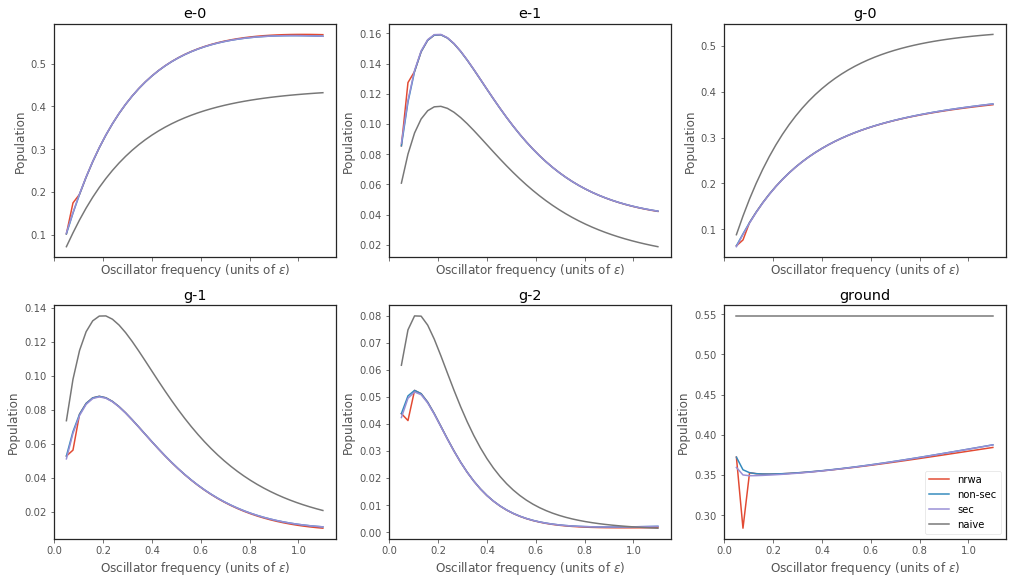

2.50% finished
 ** The previous steady state took: 18.5826611519s**
12.50% finished
 ** The previous steady state took: 18.4151861668s**
25.00% finished
 ** The previous steady state took: 17.6486270428s**
37.50% finished
 ** The previous steady state took: 25.889056921s**
50.00% finished
 ** The previous steady state took: 16.5955400467s**
62.50% finished
 ** The previous steady state took: 15.9295020103s**
75.00% finished
 ** The previous steady state took: 15.9528510571s**
87.50% finished
 ** The previous steady state took: 15.5125789642s**
100.00% finished
 ** The previous steady state took: 15.6823818684s**


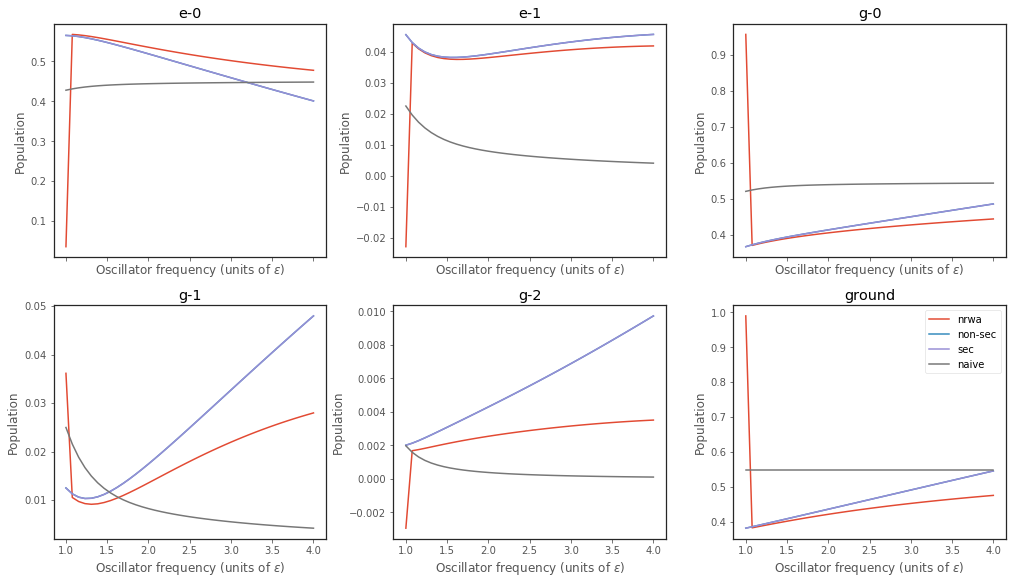

In [292]:
#
driving_convergence_wRC(eps, 0.5, T_EM=6000., min_w0_prop=0.05, max_w0_prop=1.1, overdamped=False)
driving_convergence_wRC(eps, 0.5, T_EM=6000., min_w0_prop=1., overdamped=False)

We can see that the electronic steady states converge very quickly with $\omega_0$ for the non-RWA (they're constant for naive). For the non-secular however, the steady-states do not converge and they are very sensitive to small changes in $\omega_0$. This is very similar behaviour as the overdamped case.

## Instantaneous Decay rates: coupling strength dependence

Now we will look at decay rates at short times and $T_{EM}=0$ from the $|e,0\rangle \to |g,k\rangle$ states.

In [91]:
from qutip import vector_to_operator, operator_to_vector, basis


def decay_rate_alpha( eps, T_ph, w0_prop=1., Gamma=8., overdamped=True, nvib=5, 
                                T_EM=0., init_sys=1, init_RC=0, final_sys=0):
    alpha_props = np.linspace(0.001,1.5,20)
    alpha_ph = alpha_props*eps
    w0 = w0_prop*eps
    N = 15
    if overdamped:
        Gamma = w0**2/wc
        if (w0/eps)<0.2:
            N=15
    else:
        N=15
    decay_wrt_alpha = [[],[],[],[]]
    count = 1
    for alpha_ in alpha_ph:
        
        L_RC, H, A_EM, A_nrwa, Z, wRC, kappa, Gamma_1 = RC.RC_function_UD(sigma, eps, T_ph, 
                                                                       Gamma, w0, alpha_, 
                                                                       N, silent=True)
    # given some Liouvillian, find the instantaneous decay rates
    # from e-0 to the ground manifold eigenstates, for several
    # oscillator displacements
    # - need to find the first eigenstate in the excited manifold
        evals, states = H.eigenstates()
        ground_list = []
        excited_list = []
        for i in range(len(evals)): #
            is_ground = sum(states[i])[0][0].real == 1.
            if is_ground:
                ground_list.append(i)
            else:
                excited_list.append(i)
        excited_ket = states[excited_list[0]]
        if init_sys == 0:
            init_ket = states[ground_list[init_RC]]
            init_rho = init_ket*init_ket.dag()
        elif init_sys==1:
            init_ket = states[excited_list[init_RC]]
            init_rho = init_ket*init_ket.dag()
        else:
            num = (-H*beta_f(T_ph)).expm()
            init_rho =  num/num.tr()
        if final_sys == 0:
            labels = ['g-0',  'g-1', 'g-2','g-3', 'g-4', 'ground']
            final_elec = G
        else:
            labels = ['e-0',  'e-1', 'e-2','e-3', 'e-4', 'excited']
            final_elec = E
        S_plus, S_minus, S_0 = RWA_system_ops(H_RC, A_nrwa)
        L= [EM.L_non_rwa(H, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM, silent=True), 
            EM.L_nonsecular(H, A_EM, eps, Gamma_EM, T_EM, J=J_EM, silent=True),
            EM.L_nonsecular(H, S_minus, eps, Gamma_EM, T_EM, J=J_EM, silent=True),
            EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J_EM, silent=True)]
        for i_, L_EM in enumerate(L):
            decay_rates = []
            for j in range(nvib):
                final_ket = tensor(basis(2,final_sys), basis(N,j))
                #print states[ground_list][j].dag()*target_ket
                #target_rho = operator_to_vector(target_ket*target_ket.dag())
                L_rho0_prod = vector_to_operator(L_EM*operator_to_vector(init_rho))
                rate = L_rho0_prod.matrix_element(final_ket.dag(), final_ket)
                decay_rates.append(rate)
            L_rho0_prod = vector_to_operator(L_EM*operator_to_vector(init_rho))
            rate = L_rho0_prod.ptrace(0).matrix_element(final_elec.dag(), final_elec)
            decay_rates.append(rate)
            decay_wrt_alpha[i_].append(decay_rates)
        if count ==1 or count%5==0:
            print "{:0.2f}% finished".format((float(count)/len(alpha_ph))*100)
        count+=1
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', figsize=(14,8))
    axes = [eval("ax{}".format(i)) for i in range(1,7)]
    for i in range(nvib): # each vibronic level of interest
        axes[i].set_title(labels[i])
        axes[i].plot(alpha_props,np.array(decay_wrt_alpha[0]).T[i], label='non-RWA', linewidth=1.2)
        axes[i].plot(alpha_props,np.array(decay_wrt_alpha[1]).T[i], label='naive RWA', linestyle='dashed')
        axes[i].plot(alpha_props,np.array(decay_wrt_alpha[2]).T[i], label='RWA', linewidth=1.2)
        axes[i].plot(alpha_props,np.array(decay_wrt_alpha[3]).T[i], label='additive')
        axes[i].set(xlabel=r"Coupling strength (units of $\epsilon$)", 
               ylabel="Decay rate")
    axes[-1].set_title(labels[-1])
    axes[-1].plot(alpha_props,np.array(decay_wrt_alpha[0]).T[-1], label='non-RWA', linewidth=1.2)
    axes[-1].plot(alpha_props,np.array(decay_wrt_alpha[1]).T[-1], label='naive RWA', linestyle='dashed')
    axes[-1].plot(alpha_props,np.array(decay_wrt_alpha[2]).T[-1], label='RWA', linewidth=1.2)
    axes[-1].plot(alpha_props,np.array(decay_wrt_alpha[3]).T[-1], label='additive')
    axes[-1].set(xlabel=r"Coupling strength (units of $\epsilon$)", 
           ylabel="Decay rate")
    #axes[-1].set_ylim(0,1)
    plt.tight_layout(pad=0.3, w_pad=0.3, h_pad=1.0)
    plt.legend()
    plt.show()
    return alpha_ph, decay_wrt_alpha
    #for i, alpha in enumerate(alpha_ph):
    #    plt.plot(decay_wrt_alpha[i])



5.00% finished
25.00% finished
50.00% finished
75.00% finished
100.00% finished


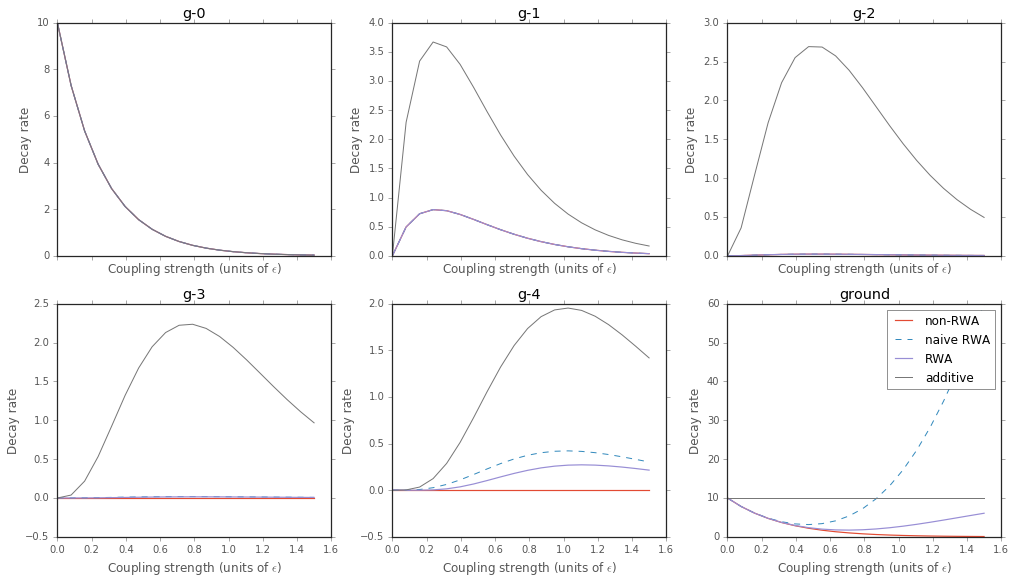

In [99]:
alphas, decay_wrt_alpha = decay_rate_alpha(1000, 300, w0_prop=0.4, T_EM=0., overdamped=False,
                                                   init_sys=1, init_RC=0, final_sys=0)

5.00% finished
25.00% finished
50.00% finished
75.00% finished
100.00% finished


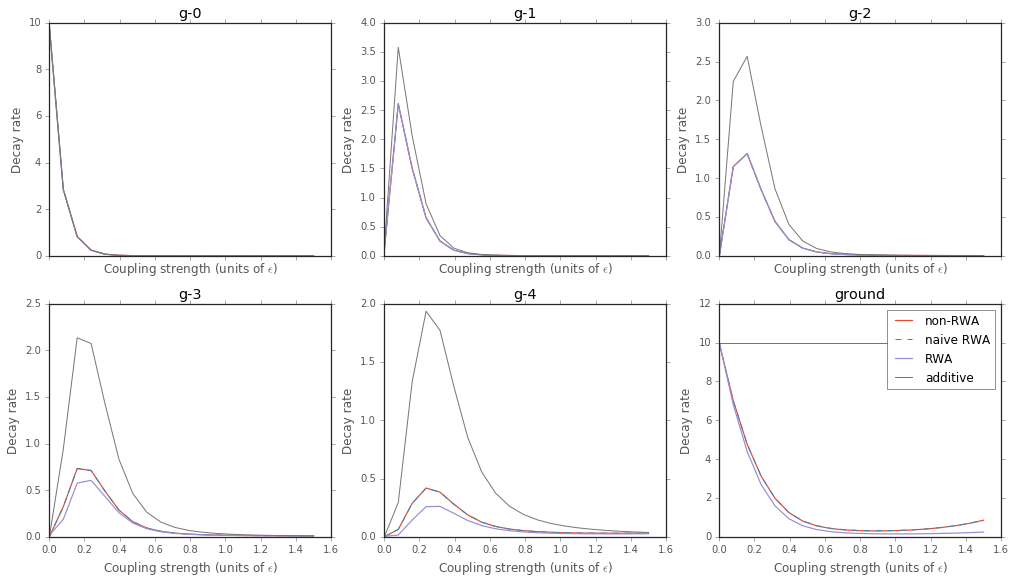

In [100]:
alphas, decay_wrt_alpha = decay_rate_alpha(1000, 300, w0_prop=0.1, T_EM=0., overdamped=False,
                                                   init_sys=1, init_RC=0, final_sys=0)

1000.0 300.0
5.00% finished
25.00% finished
50.00% finished
75.00% finished
100.00% finished


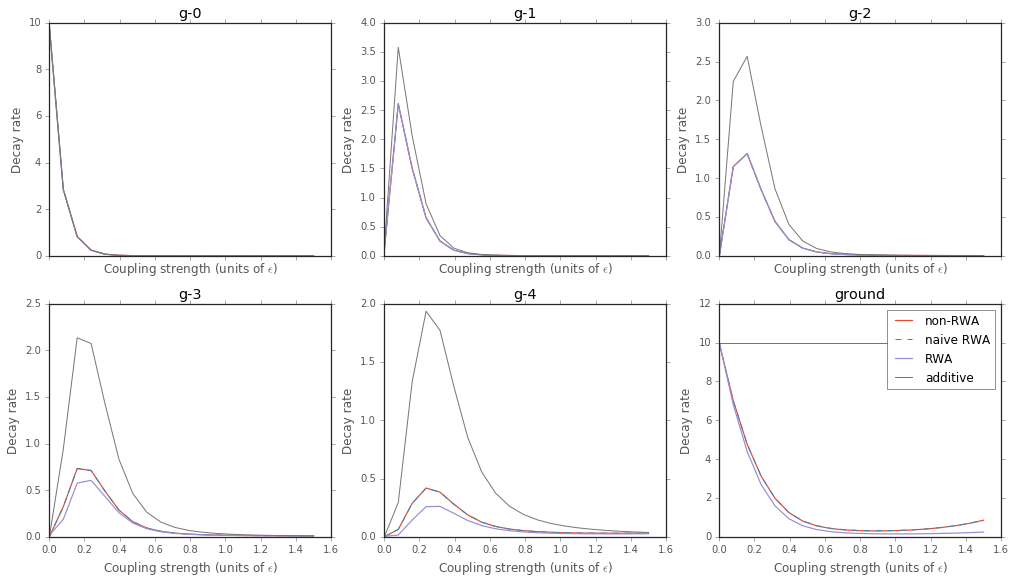

In [101]:
print eps, T_ph
alphas, decay_wrt_alpha = decay_rate_alpha(eps, T_ph, w0_prop=0.1, T_EM=0., overdamped=False,
                                                   init_sys=1, init_RC=0, final_sys=0)

5.00% finished
25.00% finished
50.00% finished
75.00% finished
100.00% finished


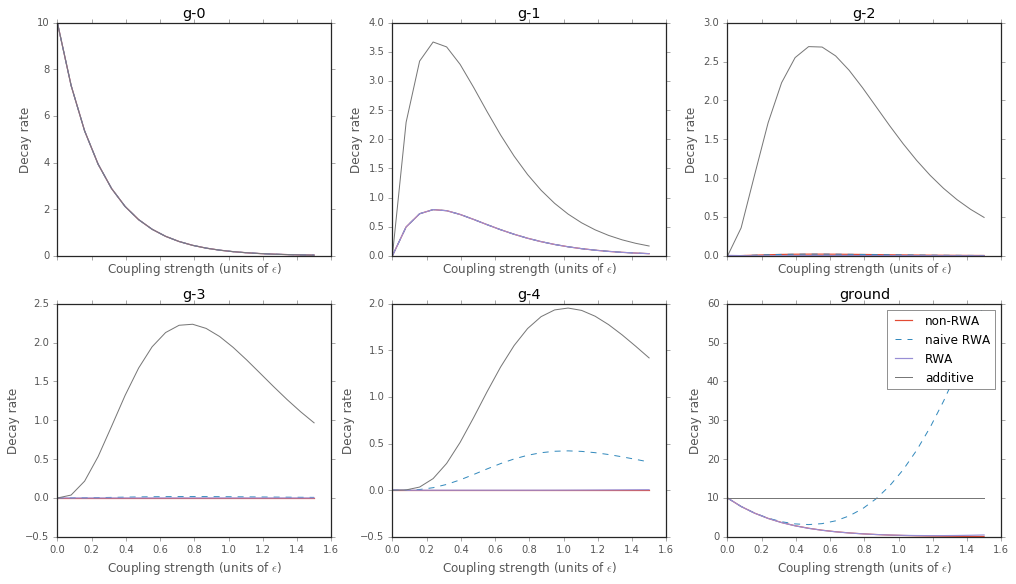

In [93]:
alphas, decay_wrt_alpha = decay_rate_alpha(eps, T_ph, w0_prop=0.4, T_EM=0., overdamped=False,
                                                   init_sys=1, init_RC=0, final_sys=0)

In [59]:
alphas, decay_wrt_alpha = decay_rate_alpha(eps, T_ph, w0_prop=14., T_EM=0., overdamped=False,
                                                   init_sys=1, init_RC=0, final_sys=0)

5.00% finished
25.00% finished
50.00% finished


KeyboardInterrupt: 

10.00% finished
50.00% finished
100.00% finished


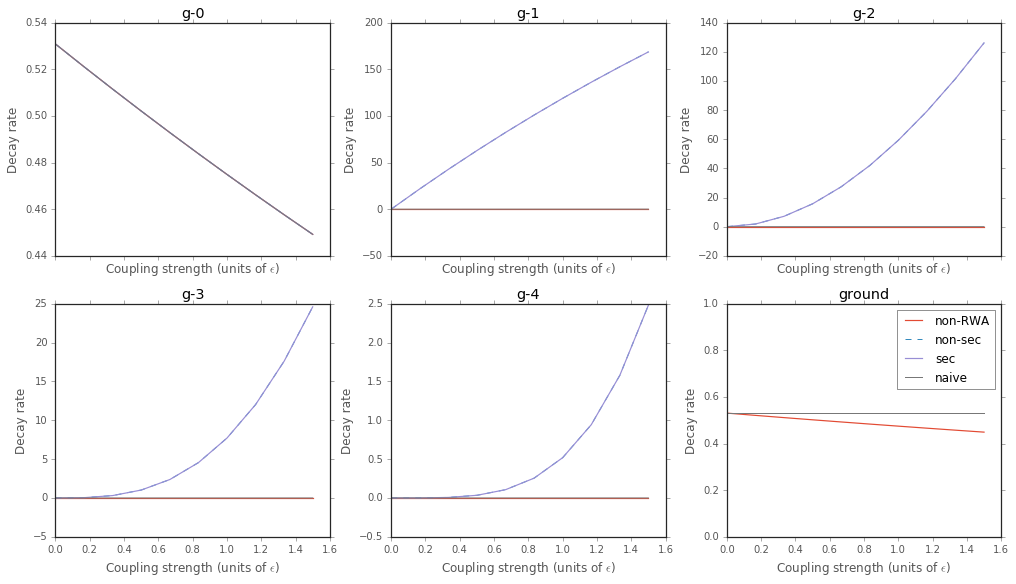

10.00% finished
50.00% finished
100.00% finished


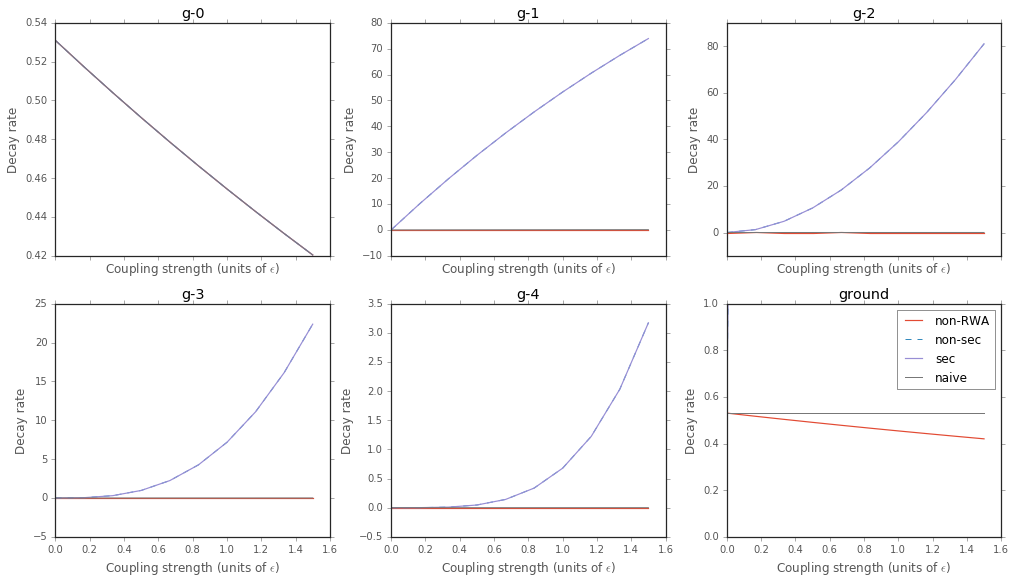

10.00% finished
50.00% finished
100.00% finished


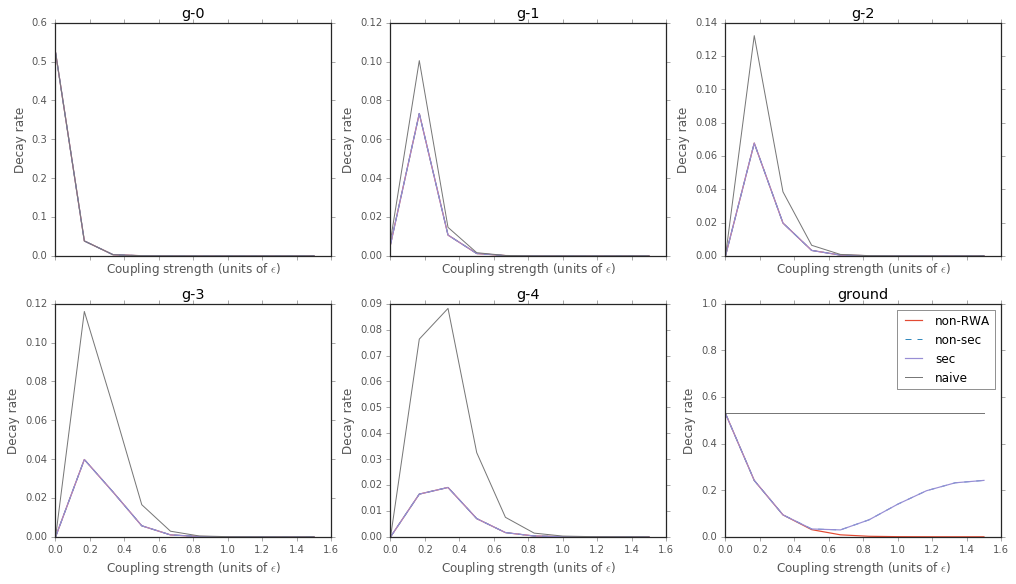

'\nalphas, decay_wrt_alpha = decay_rate_alpha(eps, T_ph, eps*1.1,\n                                                    init_sys=1, init_RC=0, final_sys=1)\nalphas, decay_wrt_alpha = decay_rate_alpha(eps, T_ph, eps*1.1, T_EM=0.,\n                                                    init_sys=3, init_RC=0, final_sys=0) # initially thermal\nalphas, decay_wrt_alpha = decay_rate_alpha(eps, T_ph, eps*1.1,\n                                                    init_sys=3, init_RC=0, final_sys=1) # initially thermal\n'

In [10]:
alphas, decay_wrt_alpha = decay_rate_alpha(eps, T_ph, eps*14.1, T_EM=0.,
                                                   init_sys=1, init_RC=0, final_sys=0)
alphas, decay_wrt_alpha = decay_rate_alpha(eps, T_ph, eps*10.1, T_EM=0.,
                                                   init_sys=1, init_RC=0, final_sys=0)
alphas, decay_wrt_alpha = decay_rate_alpha(eps, T_ph, eps*0.1, T_EM=0.,
                                                   init_sys=1, init_RC=0, final_sys=0)


#alphas, decay_wrt_alpha = decay_rate_alpha(eps, T_ph, eps*1.1, T_EM=0.,
#                                                    init_sys=1, init_RC=0, final_sys=0)
"""
alphas, decay_wrt_alpha = decay_rate_alpha(eps, T_ph, eps*1.1,
                                                    init_sys=1, init_RC=0, final_sys=1)
alphas, decay_wrt_alpha = decay_rate_alpha(eps, T_ph, eps*1.1, T_EM=0.,
                                                    init_sys=3, init_RC=0, final_sys=0) # initially thermal
alphas, decay_wrt_alpha = decay_rate_alpha(eps, T_ph, eps*1.1,
                                                    init_sys=3, init_RC=0, final_sys=1) # initially thermal
"""

#decay_rate_plotter(H_RC, L_ns)
#decay_rate_plotter(H_RC, L_n)

IT seems that:
- I can't see any decay rates from $|e,0\rangle \to |g,k\rangle$ with $\langle g,k|L_{EM}\rho(0) |e,0\rangle$ in non-RWA. If the system starts in a higher-lying vibrational state though, it decays to lower lying ground vibrational states in a similar manner to the non-secular theory. It's as if only certain transitions are allowed electronically and some vibrationally, so when these states are populated via the latter process they decay in a similar fashion to the non-secular theory. This absolutely makes sense from an energetic point of view as the RC frequency is greater than the system splitting, so if ground vibrational quantum number > excited vib. then this is a higher lying state and so cannot be populated at zero EM temperature.
- Using my method of defining the rates $|e,0\rangle \to |g,k\rangle$ with $\langle g,k|L_{EM}\rho(0) |g,k\rangle$ I only see non-zero decay rates for non-RWA case for $n=0$. As alpha increases the decay to $|g,0\rangle$ decreases to zero (should be exponential overlap no?) by none of the other decay pathways open up as well. This would make it thermodynamically unstable, localising an population in the excited state (quantum zeno?).
- With $T_{EM}=0$ and $\rho(0)=|g, n\rangle$ there are rates going to the excited state for non-RWA. This doesn't make any sense as these states cannot be thermally populated.

Need to: 
- find which method is definitely correct. Speak to Ahsan.
- Calculate using Ahsan's derivation of the non-RWA master equation.

## Instantaneous decay rates: EM temperature dependence 

The rates will be independent of phonon temperature as they only depend on TLS_RC eigenstates which do not contain information about $T_ph$.

w0: 2400.0, eps: 800.0, alpha_ph: 80.0


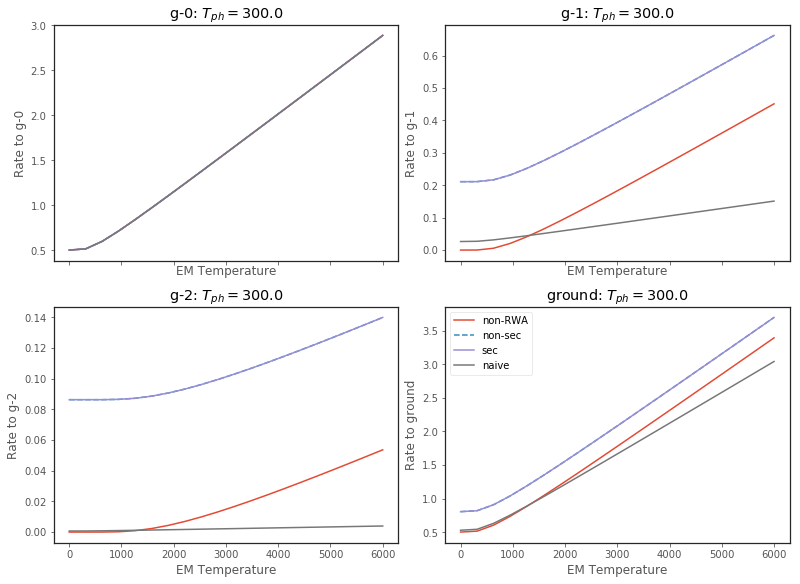

w0: 2400.0, eps: 800.0, alpha_ph: 160.0


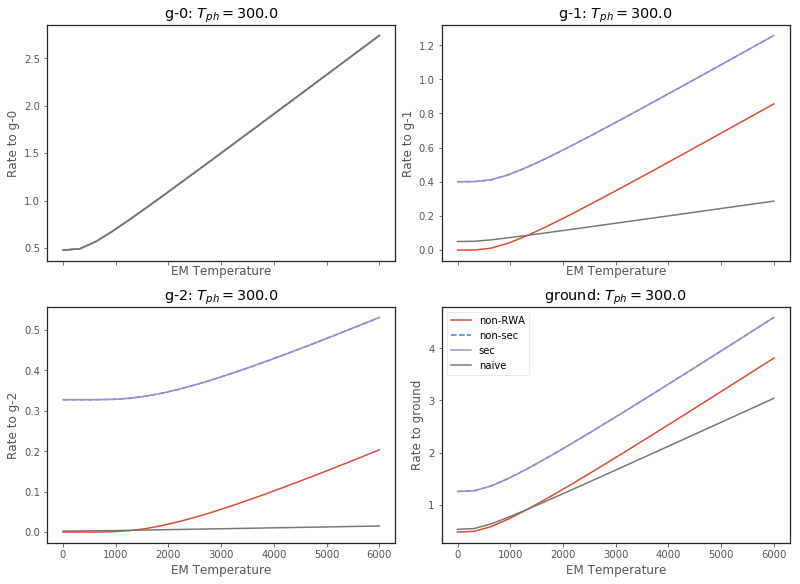

In [297]:
from qutip import vector_to_operator, operator_to_vector, basis


def decay_rate_wrt_T(eps, alpha_ph, w0, overdamped=True):
    nvib=4
    T_array = np.linspace(0,6000,20)
    N = 5
    if overdamped:
        Gamma_ = w0**2/wc
    else:
        Gamma_ = 60.
        N = 24
    decay_wrt_T = [[],[],[],[]]
    labels = ['g-0',  'g-1', 'g-2','ground','g-3', 'g-4', 'g-5']
    I = qt.qeye(N)
    for T in T_array:
        L_RC, H, A_EM, A_nrwa, wRC, kappa, Gamma_1 = RC.RC_function_UD(sigma, eps, 300., Gamma_,
                                                                       w0, alpha_ph, N, silent=True)
    # given some Liouvillian, find the instantaneous decay rates
    # from e-0 to the ground manifold eigenstates, for several
    # oscillator displacements
    # - need to find the first eigenstate in the excited manifold
        evals, states = H.eigenstates()
        ground_list = []
        excited_list = []
        for i in range(len(evals)): #
            is_ground = sum(states[i])[0][0].real == 1.
            if is_ground:
                ground_list.append(i)
            else:
                excited_list.append(i)
        excited_ket = states[excited_list[0]]
        
        #initial_ket = tensor(basis(2,1), basis(N,0))
        excited_rho = excited_ket*excited_ket.dag()
        
        L= [EM.L_non_rwa(H, A_nrwa, eps, Gamma_EM, T, J=J_EM, silent=True), 
            EM.L_nonsecular(H, A_EM, eps, Gamma_EM, T, J=J_EM, silent=True),
            EM.L_vib_lindblad(H, A_EM, eps, Gamma_EM, T, J=J_EM, silent=True),
            EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T, J=J_EM, silent=True)]
        for i_, L_EM in enumerate(L):
            decay_rates = [] # not really decay rates but population at short times
            for j in range(nvib-1):
                ground_ket = tensor(basis(2,0), basis(N,j))
                #print states[ground_list][j].dag()*target_ket
                #target_rho = operator_to_vector(target_ket*target_ket.dag())
                L_rho0_prod = vector_to_operator(L_EM*operator_to_vector(excited_ket*excited_ket.dag()))
                rate = L_rho0_prod.matrix_element(ground_ket.dag(), ground_ket)
                decay_rates.append(rate)
            L_rho0_prod = vector_to_operator(L_EM*operator_to_vector(excited_ket*excited_ket.dag()))
            rate = (L_rho0_prod*tensor(G*G.dag(), I)).tr()
            decay_rates.append(rate)
            if len(decay_rates)!=nvib:
                print ground_list
            decay_wrt_T[i_].append(decay_rates)
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', figsize=(11,8))
    axes = [eval("ax{}".format(i)) for i in range(1,5)]
    print "w0: {}, eps: {}, alpha_ph: {}".format(w0, eps, alpha_ph)
    for level in range(nvib):
        axes[level].set_title(labels[level]+r": $T_{ph}=$"+"{:0.1f}".format(T_ph))
        axes[level].plot(T_array,np.array(decay_wrt_T[0]).T[level], label='non-RWA')
        axes[level].plot(T_array,np.array(decay_wrt_T[1]).T[level], label='non-sec', linestyle='dashed')
        axes[level].plot(T_array,np.array(decay_wrt_T[2]).T[level], label='sec')
        axes[level].plot(T_array,np.array(decay_wrt_T[3]).T[level], label='naive')
        axes[level].set(xlabel='EM Temperature', ylabel='Rate to {}'.format(labels[level]))
    plt.tight_layout(pad=0.3, w_pad=0.3, h_pad=1.0)
    plt.legend()
    plt.show()
    return T_array, decay_wrt_T
    #for i, alpha in enumerate(alpha_ph):
    #    plt.plot(decay_wrt_alpha[i])

#_, _ = decay_rate_wrt_T(eps, 0.1*eps, eps*0.3)
#_, _ = decay_rate_wrt_T(eps, 0.1*eps, eps*0.9)
_, _ = decay_rate_wrt_T(eps, 0.1*eps, eps*3.0)
_, _ = decay_rate_wrt_T(eps, 0.2*eps, eps*3.0)
#decay_rate_plotter(H_RC, L_ns)
#decay_rate_plotter(H_RC, L_n)

# Steady state population: temperature dependence

In [298]:
def steadystatePop_temperature_dependence(alpha_prop,  eps, Gamma=0., w0_prop=1.5, 
                                            Gamma_EM=Gamma_EM, overdamped=True, N=14, 
                                            T_ph=True,  T_EM=False):
    alpha_ph = alpha_prop*eps
    if overdamped:
        w0 = w0_prop*eps
        Gamma = w0**2/wc
        if alpha_prop < 0.5:
            N = 14
        else:
            N= 18
    else:
        N=25
    plt.figure()
    G = ket([0])
    E = ket([1])
    sigma = G*E.dag() # Definition of a sigma_- operator.
    J = EM.J_minimal
    count = 1.

    data_nrwa  = [[],[],[],[],[],[],[]]
    data_ns    = [[],[],[],[],[],[],[]]
    data_s     = [[],[],[],[],[],[],[]]
    data_n     = [[],[],[],[],[],[],[]]
    labels = ['g-0',  'g-1', 'g-2','e-0','e-1', 'e-2'] 
    # This is true for specific Hamiltonian parameters
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    if T_ph:
        x_labels = r"$T_{ph} (K)$"
        
        if (type(T_EM)==int):
            T_ph_list, T_EM_list = np.linspace(40, 1000,25), [T_EM]*25
            print "T_EM = {}".format(T_EM)
        else:
            T_ph_list, T_EM_list = np.linspace(40, 1000,25), [6000.]*25
            print "T_EM = 6000"
        x_values = T_ph_list
    elif ((type(T_EM)==bool) and T_EM):
        x_labels = r"$T_{EM} (K)$"
        print "T_ph = {}".format(T_ph)
        if not T_ph:
            T_ph_list, T_EM_list = [300]*50, np.linspace(0, 1000,30)
        else:
            T_ph_list, T_EM_list = [T_ph]*50, np.linspace(0, 1000,30)
        x_values = T_EM_list
    Temperatures = zip(T_ph_list, T_EM_list)
    for T_ph, T_EM in Temperatures:
        
        if T_ph < 50:
            N = 14
        elif T_ph>500:
            N = 20
        #N = 4 # test
        I_RC = qt.qeye(N)
        if count ==1 or count%5==0:
            print "{:0.2f}% finished".format((count/len(x_values))*100)
        count+=1
        L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma= RC.RC_function_UD(sigma, eps, 
                                                                       T_ph, Gamma, 
                                                                       w0, alpha_ph, N,
                                                                       silent=True)
        evals, states = H_RC.eigenstates()
        ground_list = []
        excited_list = []
        for i in range(2*N): #
            is_ground = sum(states[i])[0][0].real == 1.
            if is_ground:
                ground_list.append(i)
            else:
                excited_list.append(i)
        lowest_6 = [s*s.dag() for s in states[ground_list[0:3] + excited_list[0:3]]]
        lowest_6.append(tensor(E*E.dag(), I_RC))
        #print len(excited_list), 'excited'
        # electromagnetic bath liouvillians
        L_nrwa = EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J, silent=True)
        L_ns = EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J, silent=True)
        L_s = EM.L_vib_lindblad(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J, silent=True)
        L_n = EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J, silent=True)
        for j, obs in enumerate(lowest_6):
            method = 'iterative-lgmres'
            data_nrwa[j].append((obs*steadystate(H_RC, [L_RC+L_nrwa])).tr())
            data_ns[j].append((obs*steadystate(H_RC, [L_RC+L_ns])).tr())
            data_s[j].append((obs*steadystate(H_RC, [L_RC+L_s])).tr())
            data_n[j].append((obs*steadystate(H_RC, [L_RC+L_n])).tr())
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', figsize=(14,8))
    axes = [eval("ax{}".format(i)) for i in range(1,7)]
    for i, lab in enumerate(labels):
        axes[i].set_title(lab)
        axes[i].plot(x_values, data_nrwa[i], label='nrwa')
        axes[i].plot(x_values, data_ns[i], label='ns', linestyle='dashed')
        axes[i].plot(x_values, data_s[i], label='s')
        axes[i].plot(x_values, data_n[i], label='n')
        #plt.grid()
        axes[i].set(xlabel=x_labels, 
               ylabel="Population")
        #axes[i].label_outer()
    plt.tight_layout(pad=0.3, w_pad=0.3, h_pad=1.0)
    plt.legend()
    plt.figure()
    plt.title("Excited state")
    plt.plot(x_values, data_nrwa[-1], label='nrwa')
    plt.plot(x_values, data_ns[-1], label='ns', linestyle='dashed')
    plt.plot(x_values, data_s[-1], label='s')
    plt.plot(x_values, data_n[-1], label='n')
    plt.legend()
    plt.ylabel("Population")
    plt.xlabel(x_labels)
    plt.show()

T_ph = False
3.33% finished


driving_liouv.py:34: RuntimeWarning: overflow encountered in exp
  if sp.exp(omega*beta)-1 ==0.:
driving_liouv.py:37: RuntimeWarning: overflow encountered in exp
  n = float(1./(sp.exp(omega*beta)-1))


16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished


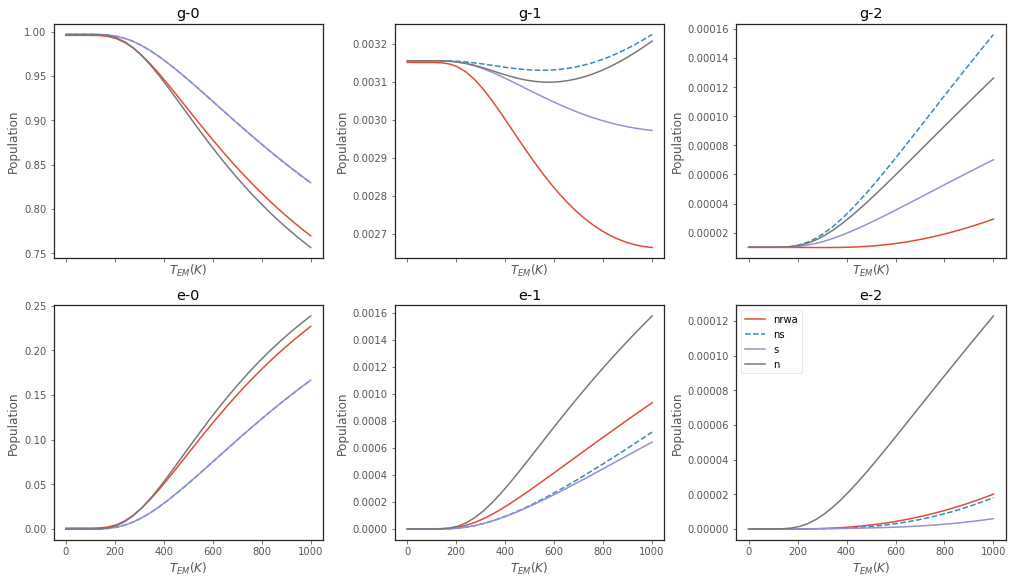

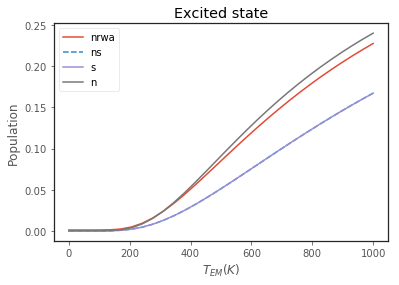

T_ph = False
3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished


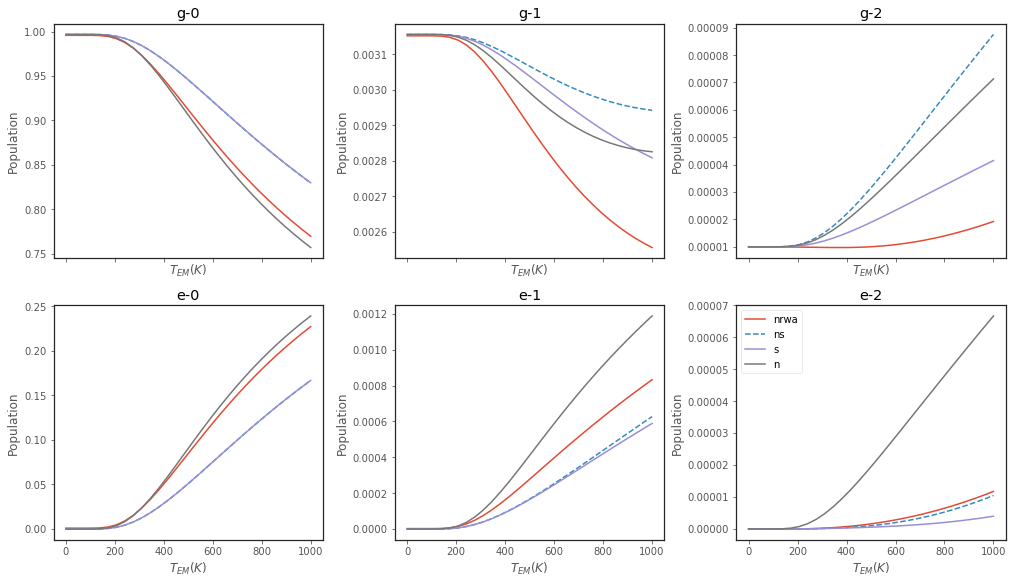

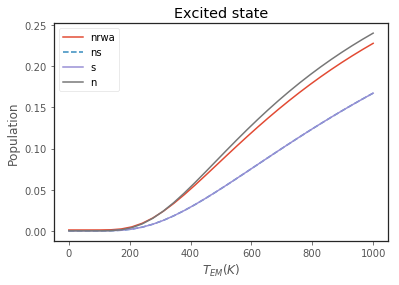

'\nsteadystatePop_temperature_dependence(0.3,  eps, overdamped=True, \n                                            T_ph=True,  T_EM=300.) # phonon temperature dependence\nsteadystatePop_temperature_dependence(0.3,  eps, overdamped=True, \n                                            T_ph=False,  T_EM=True) # EM temperature dependence\nsteadystatePop_temperature_dependence(0.1,  eps, overdamped=True,\n                                            T_ph=True,  T_EM=6000.) # phonon temperature dependence\nsteadystatePop_temperature_dependence(0.1,  eps, overdamped=True, \n                                            T_ph=False,  T_EM=True) # EM temperature dependence\n                                            '

In [299]:
steadystatePop_temperature_dependence(0.6,  eps, overdamped=True, 
                                            T_ph=False,  T_EM=True) # EM temperature dependence
wc = 100.
steadystatePop_temperature_dependence(0.6,  eps, overdamped=True, 
                                            T_ph=False,  T_EM=True) # EM temperature dependence
wc = 53.
"""
steadystatePop_temperature_dependence(0.3,  eps, overdamped=True, 
                                            T_ph=True,  T_EM=300.) # phonon temperature dependence
steadystatePop_temperature_dependence(0.3,  eps, overdamped=True, 
                                            T_ph=False,  T_EM=True) # EM temperature dependence
steadystatePop_temperature_dependence(0.1,  eps, overdamped=True,
                                            T_ph=True,  T_EM=6000.) # phonon temperature dependence
steadystatePop_temperature_dependence(0.1,  eps, overdamped=True, 
                                            T_ph=False,  T_EM=True) # EM temperature dependence
                                            """

## Steady-state population of vibronic states: phonon coupling dependence

In [302]:
def steadystatePop_coupling_dependence(prop_couplings, T_ph, eps,  w0_prop, Gamma=50., T_EM=6000., 
                                    Gamma_EM=Gamma_EM, overdamped=True, N=14):
    w0 = eps*w0_prop
    if overdamped:
        Gamma = w0**2/wc
    else:
        N=25
    plt.figure()
    G = ket([0])
    E = ket([1])
    sigma = G*E.dag() # Definition of a sigma_- operator.
    J = EM.J_minimal
    count = 1.

    data_nrwa  = [[],[],[],[],[],[],[]]
    data_ns    = [[],[],[],[],[],[],[]]
    data_s     = [[],[],[],[],[],[],[]]
    data_n     = [[],[],[],[],[],[],[]]
    labels = ['g-0',  'g-1', 'g-2','e-0','e-1', 'e-2'] 
    # This is true for specific Hamiltonian parameters
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    print "RC freq. prop = {}".format(w0/eps)
    for prop in prop_couplings:
        alpha_ph = prop*eps
        if prop < 0.5:
            N = 14
        I_RC = qt.qeye(N)
        if count ==1 or count%5==0:
            print "{:0.2f}% finished".format((count/len(prop_couplings))*100)
        count+=1
        L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma= RC.RC_function_UD(sigma, eps, 
                                                                       T_ph, Gamma, 
                                                                       w0, alpha_ph, N,
                                                                       silent=True)
        evals, states = H_RC.eigenstates()
        ground_list = []
        excited_list = []
        for i in range(2*N): #
            is_ground = sum(states[i])[0][0].real == 1.
            if is_ground:
                ground_list.append(i)
            else:
                excited_list.append(i)
        lowest_6 = [s*s.dag() for s in states[ground_list[0:3] + excited_list[0:3]]]
        lowest_6.append(tensor(E*E.dag(), I_RC))
        #print len(excited_list), 'excited'
        # electromagnetic bath liouvillians
        L_nrwa = EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J, silent=True)
        L_ns = EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J, silent=True)
        L_s = EM.L_vib_lindblad(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J, silent=True)
        L_n = EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J, silent=True)
        for j, obs in enumerate(lowest_6):
            method = 'iterative-lgmres'
            data_nrwa[j].append((obs*steadystate(H_RC, [L_RC+L_nrwa])).tr())
            data_ns[j].append((obs*steadystate(H_RC, [L_RC+L_ns])).tr())
            data_s[j].append((obs*steadystate(H_RC, [L_RC+L_s])).tr())
            data_n[j].append((obs*steadystate(H_RC, [L_RC+L_n])).tr())
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', figsize=(14,8))
    axes = [eval("ax{}".format(i)) for i in range(1,7)]
    for i, lab in enumerate(labels):
        axes[i].set_title(lab)
        axes[i].plot(prop_couplings, data_nrwa[i], label='nrwa')
        axes[i].plot(prop_couplings, data_ns[i], label='ns', linestyle='dashed')
        axes[i].plot(prop_couplings, data_s[i], label='s')
        axes[i].plot(prop_couplings, data_n[i], label='n')
        #plt.grid()
        axes[i].set(xlabel=r"Phonon Coupling Strength: units of $\epsilon$", 
               ylabel="Population")
        #axes[i].label_outer()
    plt.tight_layout(pad=0.3, w_pad=0.3, h_pad=1.0)
    plt.legend()
    plt.figure()
    plt.title("Excited state")
    plt.plot(prop_couplings, data_nrwa[-1], label='nrwa')
    plt.plot(prop_couplings, data_ns[-1], label='ns', linestyle='dashed')
    plt.plot(prop_couplings, data_s[-1], label='s')
    plt.plot(prop_couplings, data_n[-1], label='n')
    plt.legend()
    plt.ylabel("Population")
    plt.xlabel(r"Phonon Coupling Strength: units of $\epsilon$")
    plt.show()

In [304]:
couplings = np.linspace(0.001,1.5,30)
steadystatePop_coupling_dependence(couplings, T_ph, eps, Gamma=60., 
                                   w0_prop=0.1,  overdamped=False)
steadystatePop_coupling_dependence(couplings, T_ph, eps, 0.4,  overdamped=True)
steadystatePop_coupling_dependence(couplings, T_ph, eps,  0.9, overdamped=True)
steadystatePop_coupling_dependence(couplings, T_ph, eps, w0_prop=1.5, overdamped=True)
steadystatePop_coupling_dependence(couplings, T_ph, eps, w0_prop=3., overdamped=True)

RC freq. prop = $ 80.0
3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished


KeyboardInterrupt: 

In [ ]:
couplings = np.linspace(0.001,5.,40)
steadystatePop_coupling_dependence(couplings, T_ph, eps, w0_prop=1.5*eps, overdamped=True)

As w0 gets larger, the vibronic dynamics change drastically but the overall electronic levels do not.

# Dynamics of Vibronic States
Should be able to see the vibronic states being occupied, even if the rates are initially zero?

In [ ]:
def vibronic_state_dynamics(init_sys, init_RC, prop_coupling, eps, Gamma, w0, T_ph=300., T_EM=6000., 
                                    Gamma_EM=1., overdamped=True):
    # Start system+RC in adiabatic eigenstate and then time-evolve
    alpha_ph = prop_coupling*eps/np.pi

    if overdamped:
        w0 = eps*1.01
        Gamma = w0**2/wc
        N = 15
    else:
        N=24
    w = np.linspace(0., eps*1.5, 1000)
    plt.figure()
    plt.plot(w, J_underdamped(w, alpha_ph, Gamma, w0))
    plt.axvline(eps, label='Splitting',color='k')
    plt.ylabel("Coupling Strength")
    plt.xlabel(r"Frequency $cm^{-1}$")
    plt.title("Phonon Spectral Density")
    plt.legend()
    plt.show()
    G = ket([0])
    E = ket([1])
    
    sigma = G*E.dag() # Definition of a sigma_- operator.
    J = EM.J_minimal
    count = 1
    I_RC = qt.qeye(N)
    labels = ['g-0',  'g-1', 'g-2','e-0','e-1', 'e-2'] 
    # This is true for specific Hamiltonian parameters
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dyn_DATA = []
    
    L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma= RC.RC_function_UD(sigma, eps, 
                                                                   T_ph, Gamma, 
                                                                   w0, alpha_ph, N)
    evals, states = H_RC.eigenstates()
    ground_list = []
    excited_list = []
    concat_list = [ground_list, excited_list]
    for i in range(len(evals)): #
        is_ground = sum(states[i])[0][0].real == 1.
        if is_ground:
            ground_list.append(i)
        else:
            excited_list.append(i)
    # work out how to initialise system rho
    index_list = []
    if type(init_sys) == tuple:
        #coherence state
        if type(init_RC) == tuple:
            # take in a 2-tuple to initialise in coherence state.
            print init_sys, init_RC
            rho_left = states[concat_list[init_sys[0]][init_RC[0]]]
            rho_right = states[concat_list[init_sys[1]][init_RC[1]]].dag()
            init_rho = rho_left*rho_right
        else:
            raise ValueError
    elif init_sys == 0:
        # population state
        init_rho = states[ground_list[init_RC]]*states[ground_list[init_RC]].dag()
    elif init_sys==1:
        init_rho = states[excited_list[init_RC]]*states[excited_list[init_RC]].dag()
    else:
        Therm = qt.thermal_dm( N, EM.Occupation(w0, T_ph))
        init_rho = qt.tensor(E*E.dag(), Therm)
        # if in neither ground or excited
        # for the minute, do nothing. This'll be fixed below.
    
        
    if init_sys>2:
        # finally, if not in either G or E, initialise as thermal
        num = (-H_RC*beta_f(T_ph)).expm()
        init_rho =  num/num.tr()
    
    expects_vib = [s*s.dag() for s in states[ground_list[0:3] + excited_list[0:3]]]
    expects_vib.append(tensor(E*E.dag(), I_RC))
    #print len(excited_list), 'excited'
    # electromagnetic bath liouvillians
    L_nrwa = EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J, silent=True)
    L_ns = EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J, silent=True)
    L_s = EM.L_vib_lindblad(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J, silent=True)
    L_n = EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J, silent=True)
    Liouvs = [L_nrwa, L_ns, L_s, L_n]
    timelist = np.linspace(0,1.,900)
    options = qt.Options(nsteps=1500, num_cpus=2)
    if T_EM<1000:
        timelist = np.linspace(0,2.,1500)
        #options = qt.Options(nsteps=1500, num_cpus=3)
    for L_EM in Liouvs:
        ti = time.time()
        dyn_DATA.append(mesolve(H_RC, init_rho, timelist, [L_RC+L_EM], expects_vib, options=options))
        print "Completed dynamics calculation {} in {} seconds.".format(Liouvs.index(L_EM)+1, time.time()-ti)
    
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', figsize=(14,8))
    axes = [eval("ax{}".format(i)) for i in range(1,7)]
    for i, lab in enumerate(labels):
        
        axes[i].set_title(lab)
        axes[i].plot(timelist, dyn_DATA[0].expect[i], label='nrwa')
        axes[i].plot(timelist, dyn_DATA[1].expect[i], label='ns', linestyle='dashed')
        axes[i].plot(timelist, dyn_DATA[2].expect[i], label='s')
        axes[i].plot(timelist, dyn_DATA[3].expect[i], label='n')
        #plt.grid()
        axes[i].set(xlabel=r"Time", 
               ylabel="Population")
        #axes[i].label_outer()
        if type(init_sys) == int:
            """
            init_state_final_pop_0 = dyn_DATA[0].expect[(3*init_sys+init_RC)][-1] # naive
            init_state_final_pop_1 = dyn_DATA[1].expect[(3*init_sys+init_RC)][-1] # nrwa
            init_state_final_pop_2 = dyn_DATA[2].expect[(3*init_sys+init_RC)][-1] # ns
            init_state_final_pop_3 = dyn_DATA[3].expect[(3*init_sys+init_RC)][-1] # s
            print "{} state accounts for".format(lab)
            print "NRWA: {:0.4f}%".format(100*(dyn_DATA[0].expect[i][-1]/init_state_final_pop_0))
            print "NS: {:0.4f}%" .format(100*(dyn_DATA[1].expect[i][-1]/init_state_final_pop_1))
            print "Naive: {:0.4f}% of total dynamics".format(100*(dyn_DATA[2].expect[i][-1]/init_state_final_pop_2))
            print "Naive: {:0.4f}% of total dynamics".format(100*(dyn_DATA[3].expect[i][-1]/init_state_final_pop_3))
            """
            pass
    plt.tight_layout(pad=0.3, w_pad=0.3, h_pad=1.0)
    plt.xlim(0,timelist[-1])
    plt.legend()
    plt.figure()
    plt.title("Excited state")
    plt.plot(timelist, dyn_DATA[0].expect[-1], label='Full')
    plt.plot(timelist, dyn_DATA[1].expect[-1], label='RWA & non-sec', linestyle='dashed')
    plt.plot(timelist, dyn_DATA[2].expect[-1], label='RWA & sec.')
    plt.plot(timelist, dyn_DATA[3].expect[-1], label='Additive')
    plt.legend()
    plt.ylabel("Population")
    plt.xlabel(r"Time")
    plt.show()




In [ ]:
ev_to_inv_cm = 8065.5
inv_ps_to_inv_cm = 5.309
wc/ev_to_inv_cm
g_cm = 0.1*inv_ps_to_inv_cm
g_ev = g_cm/ev_to_inv_cm
print g_cm, g_ev

In [ ]:
vibronic_state_dynamics(2, 0, 0.5, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True)
vibronic_state_dynamics(2, 0, 0.4, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True)
vibronic_state_dynamics(2, 0, 0.3, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True) # intiial product(E, thermal_RC)



In [ ]:
"""vibronic_state_dynamics(2, 0, 0.2, eps, 0., 0., T_ph=300., T_EM=0., 
                                Gamma_EM=Gamma_EM, overdamped=True) # start in thermal TLS-RC state
vibronic_state_dynamics(2, 0, 0.2, eps, 0., 0., T_ph=300., T_EM=6000., 
                                Gamma_EM=Gamma_EM, overdamped=True) # start in thermal TLS-RC state
vibronic_state_dynamics(1, 0, 0.2, eps, 10., 0, T_ph=300., T_EM=6000., 
                                    Gamma_EM=Gamma_EM, overdamped=True)"""
#init_sys, init_RC, prop_coupling, eps, Gamma, w0,
vibronic_state_dynamics(1, 1, 0.1, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True)
vibronic_state_dynamics(1, 1, 0.2, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True)
vibronic_state_dynamics(1, 0, 0.1, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True)
vibronic_state_dynamics(1, 0, 0.2, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True)

So (starting in $|e, 0\rangle$), we can see that the the excited state vibronic levels are populated on very short timescales, these all then decay on much slower timescales to the ground manifold. This fast population occurs in the ground state levels as well, however some must dissipate to ground manifold before this can occur as there is no non-adiabatic phonon coupling between the two manifolds. It also happens to a greater extent in naive case, since this facilitates transfer to energetically forbidden states to a greater extent than ns and s. Thus there are actually fewer decay pathways from the excited to the ground manifold, so excited state population is essentially trapped by the RC. **Is this what you'd expect physically in an overdamped environment?**


When initialised in the ground state g-0, the ground manifold is populated quickly. In turn these vibronic levels then populate the excited manifold on slower timescales. When the first vibronic level is populated, this is able to decay downwards to e-0. When the second (g-2) is populated, this can decay to both e-1 and e-0. Etc.



In [ ]:
vibronic_state_dynamics((0,1), (1,0), 0.2, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True) # g1-e0

Initialising the system in a coherence state does absolutely nothing to the decay to population states. Now let's try the dynamics *into* coherences from diagonal population states.

# Vibronic coherence dynamics: initialised in population states

In [ ]:
def state_string(init_sys, init_RC):
    sys_str = []
    if type(init_sys) == int:
        if init_sys == 0:
            sys_str = 'g'
        elif init_sys == 1:
            sys_str = 'e'
        else:
            sys_str = ''
        return '|{};{}><{};{}|'.format(sys_str, init_RC, sys_str, init_RC)
    else:
        for i in init_sys:
            if i == 0:
                sys_str.append('g')
            elif i ==1:
                sys_str.append('e')
            
    return '|{};{}><{};{}|'.format(sys_str[0], init_RC[0], sys_str[1], init_RC[1])
print state_string((1,0), (1,0))
print state_string(1, 1)

In [ ]:
reload(RC)
def vibronic_coherence_dynamics(init_sys, init_RC, prop_coupling, eps, Gamma, w0,
                                T_ph=300., T_EM=6000., Gamma_EM=1., overdamped=True, 
                                optical_off=False, w0_prop=1.01,N=9,
                                residual_off=False, end_time_scaler=1.):
    # Start system+RC in adiabatic eigenstate and then time-evolve
    alpha_ph = prop_coupling*eps

    if overdamped:
        w0 = eps*w0_prop
        Gamma = w0**2/wc
        N = 15
    else:
        w0 = eps*w0_prop
        N=24
    w = np.linspace(0., eps*1.5, 1000)
    plt.figure()
    plt.plot(w, J_underdamped(w, alpha_ph, Gamma, w0))
    plt.axvline(eps, label='Splitting',color='k')
    plt.ylabel("Coupling Strength")
    plt.xlabel(r"Frequency $cm^{-1}$")
    plt.title("Phonon Spectral Density")
    plt.legend()
    plt.show()
    
    G = ket([0])
    E = ket([1])
    
    sigma = G*E.dag() # Definition of a sigma_- operator.
    J = EM.J_minimal
    count = 1
    I_RC = qt.qeye(N)
    labels = ['g0-g1',  'g0-g2', 'g1-g2','e0-e1','e0-e2','e1-e4']
    #labels += ['e0-g0',  'e0-g1', 'e0-g2','e1-g0','e1-g1','e1-g2']
    # This is true for specific Hamiltonian parameters
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dyn_DATA = []
    
    L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma= RC.RC_function_UD(
                                                sigma, eps, T_ph, Gamma, 
                                                w0, alpha_ph, N, 
                                                residual_off=residual_off)
    evals, states = H_RC.eigenstates()
    ground_list = []
    excited_list = []
    for i in range(len(evals)): #
        is_ground = sum(states[i])[0][0].real == 1.
        if is_ground:
            ground_list.append(i)
        else:
            excited_list.append(i)
    
    if init_sys == 0:
        print "Initial state is "+state_string(init_sys, init_RC)
        init_ket = states[ground_list[init_RC]]
        init_rho = init_ket*init_ket.dag()
    elif init_sys==1:
        print "Initial state is "+state_string(init_sys, init_RC)
        init_ket = states[excited_list[init_RC]]
        init_rho = init_ket*init_ket.dag()
    elif init_sys==10:
        print "Initial state is "+state_string((1,0), (init_RC, init_RC))
        init_ket = np.sqrt(2)*(states[excited_list[init_RC]]+states[ground_list[init_RC]])
        init_rho = init_ket*init_ket.dag()
    else:
        num = (-H_RC*beta_f(T_ph)).expm()
        init_rho =  num/num.tr()
    ground = [states[i] for i in ground_list]
    excited = [states[i] for i in excited_list]
    # labels = ['g0-g1',  'g0-g2', 'g1-g2','e0-e1','e0-e2','e1-e4']
    #print excited_list
    expects_vib = [ground[0]*ground[1].dag(), ground[0]*ground[2].dag(), ground[1]*ground[2].dag()]
    expects_vib += [excited[0]*excited[1].dag(), excited[0]*excited[2].dag(), excited[0]*excited[4].dag()]
    
    #expects_vib += [excited[0]*ground[0].dag(), excited[0]*ground[1].dag(), excited[0]*ground[2].dag()]
    #expects_vib += [excited[1]*ground[0].dag(), excited[1]*ground[1].dag(), excited[1]*ground[2].dag()]
    expects_vib += [qt.tensor((E*G.dag()), qt.qeye(N))]
    #print len(excited_list), 'excited'
    # electromagnetic bath liouvillians
    L_nrwa = EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J, silent=True)
    L_ns = EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J, silent=True)
    L_s = EM.L_vib_lindblad(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J, silent=True)
    L_n = EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J, silent=True)
    Liouvs = [L_nrwa, L_ns, L_s, L_n]
    timelist = np.linspace(0,end_time_scaler*1.,900)
    options = qt.Options(nsteps=1500, num_cpus=2)
    if T_EM<1000:
        timelist = np.linspace(0,end_time_scaler*1.,2000)
        #options = qt.Options(nsteps=1500, num_cpus=3)
    for L_EM in Liouvs:
        ti = time.time()
        if optical_off:
            L = L_RC
        else:
            L = L_RC+L_EM
        dyn_DATA.append(mesolve(H_RC, init_rho, timelist, [L], expects_vib, options=options))
        print "Completed dynamics calculation {} in {} seconds.".format(Liouvs.index(L_EM)+1, time.time()-ti)
    
    
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', figsize=(14,8))
    
    #f, ((ax1, ax2, ax3), (ax4, ax5, ax6), 
    #    (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3, sharex='col', figsize=(14,16))
    axes = [eval("ax{}".format(i)) for i in range(1,len(labels)+1)]
    for i, lab in enumerate(labels):
        
        #init_state_final_pop_0 = dyn_DATA[0].expect[(3*init_sys+init_RC)][-1] # naive
        #init_state_final_pop_1 = dyn_DATA[1].expect[(3*init_sys+init_RC)][-1] # nrwa
        #init_state_final_pop_2 = dyn_DATA[2].expect[(3*init_sys+init_RC)][-1] # ns
        #init_state_final_pop_3 = dyn_DATA[3].expect[(3*init_sys+init_RC)][-1] # s
        axes[i].set_title(lab)
        if not residual_off:
            axes[i].plot(timelist, [abs(v) for v in dyn_DATA[0].expect[i]], label='nrwa')
            axes[i].plot(timelist, [abs(v) for v in dyn_DATA[1].expect[i]], label='ns', linestyle='dashed')
        axes[i].plot(timelist, [abs(v) for v in dyn_DATA[2].expect[i]], label='s', linestyle='dotted', linewidth=2.5)
        if not residual_off:
            axes[i].plot(timelist, [abs(v) for v in dyn_DATA[3].expect[i]], label='n')
        #plt.grid()
        axes[i].set(xlabel=r"Time", ylabel="Coherence")
        #axes[i].label_outer()
        
        #print "{} state accounts for".format(lab)
        #print "NRWA: {:0.4f}%".format(100*(dyn_DATA[0].expect[i][-1]/init_state_final_pop_0))
        #print "NS: {:0.4f}%" .format(100*(dyn_DATA[1].expect[i][-1]/init_state_final_pop_1))
        #print "Naive: {:0.4f}% of total dynamics".format(100*(dyn_DATA[2].expect[i][-1]/init_state_final_pop_2))
        #print "Naive: {:0.4f}% of total dynamics".format(100*(dyn_DATA[3].expect[i][-1]/init_state_final_pop_3))
    plt.tight_layout(pad=0.3, w_pad=0.3, h_pad=1.0)
    plt.legend()
    """
    plt.figure()
    plt.title("E-G")
    plt.plot(timelist, dyn_DATA[0].expect[-1], label='nrwa')
    plt.plot(timelist, dyn_DATA[1].expect[-1], label='ns', linestyle='dashed')
    plt.plot(timelist, dyn_DATA[2].expect[-1], label='s')
    plt.plot(timelist, dyn_DATA[3].expect[-1], label='n')
    plt.legend()
    plt.ylabel("Population")
    plt.xlabel(r"Time")
    """
    plt.show()

In [ ]:
#vibronic_coherence_dynamics(0, 0, 0.2, eps, 10., 0, T_ph=300., T_EM=6000., 
#                                    Gamma_EM=Gamma_EM, overdamped=True)
vibronic_coherence_dynamics(1, 0, 0.2, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True, end_time_scaler=2)

**Existence of coherence in the secular theory**

Above, we can see that the secular theory does generate some coherence as the initially excited state decays. The RC map is non-secular, so coherences and populations can be coupled within the same manifold. On short timescales, e0-e2 coherence is generated and decays exponentially back to steady state (non-zero for NS and nRWA!). Although coherence is not generated between manifolds, as the population slowly-decays to the ground state it is coupled to coherences and therefore a small amount of coherence is generate on slightly slower timescales than in the other three cases.

**Steady state secular coherence in ground manifold**
The ground state is not coupled to the phonon bath and so any coherence which is generated on the ground manifold is not decohered by the phonon bath, only by optical processes (?)

**RC map coherence only generated between $|s;n\rangle\langle s;0|$, where n is even.**

Coherence in the secular theory (and hence in the case where $\alpha_{EM}=0$) is only generated when $\langle s;0|\rho(t)|s;n\rangle$ $n=2i$ where $i=1,2,3,..$

The naive approach has qualititavely similar effects in many instances. This will be due to the accumulation of coherences incidentally due to it's inability to see the manifolds. The secular approach sometimes does generate coherences, which shouldn't occur from the EM map, however could possibly occur from phonons. It doesn't seem to be a lack of convergence but it could be a coding bug, although I don't see how.

** Now: **
- ** turn off optical field entirely**
- ** turn off residual bath entirely **

### Coherence dynamics with no optical field


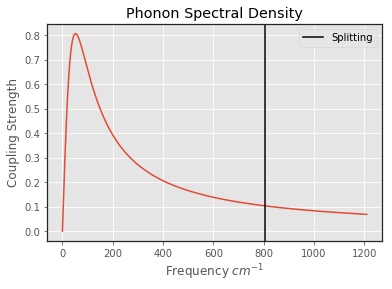

w_RC= 1621.1655  TLS splitting = 806.55 RC-res. coupling= 4.9618558249  N= 15 TLS-RC coupling= 64.0920644283 Gamma_RC=  50541.8765075 alpha_ph= 1.6131 beta= 0.00479616306954
Initial state is |g;0><g;0|
[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
Calculating non-RWA Liouvilliian took 0.835433006287 seconds.
It took  0.775439023972  seconds to build the Non-secular RWA Liouvillian
It took  0.744897842407  seconds to build the vibronic Lindblad Liouvillian
It took  0.00272989273071  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 19.4534740448 seconds.
Completed dynamics calculation 2 in 23.8026108742 seconds.
Completed dynamics calculation 3 in 20.2155308723 seconds.
Completed dynamics calculation 4 in 21.3876321316 seconds.


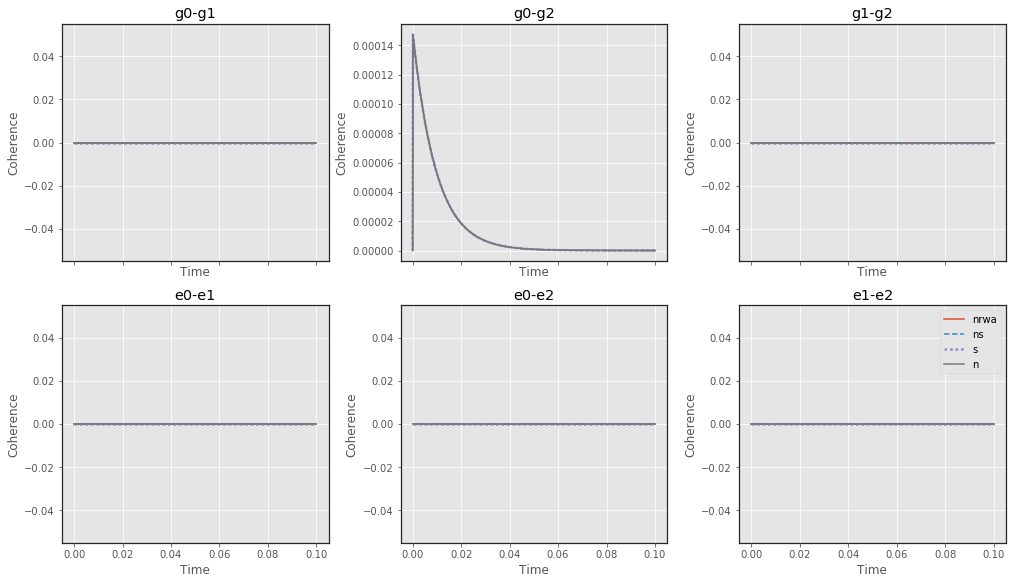

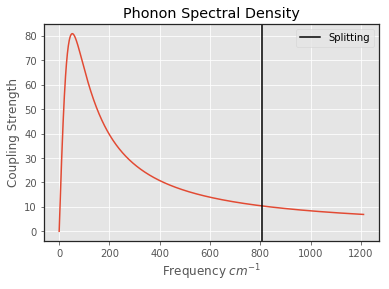

w_RC= 814.6155  TLS splitting = 806.55 RC-res. coupling= 2.49327083739  N= 15 TLS-RC coupling= 454.325296588 Gamma_RC=  12761.5079392 alpha_ph= 161.31 beta= 0.00479616306954
Initial state is |g;0><g;0|
[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 22, 24, 26, 28, 29]
Calculating non-RWA Liouvilliian took 1.42722606659 seconds.
It took  1.20795083046  seconds to build the Non-secular RWA Liouvillian
It took  1.79234290123  seconds to build the vibronic Lindblad Liouvillian
It took  0.00273108482361  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 6.24956297874 seconds.
Completed dynamics calculation 2 in 6.37934613228 seconds.
Completed dynamics calculation 3 in 6.87506198883 seconds.
Completed dynamics calculation 4 in 6.83104515076 seconds.


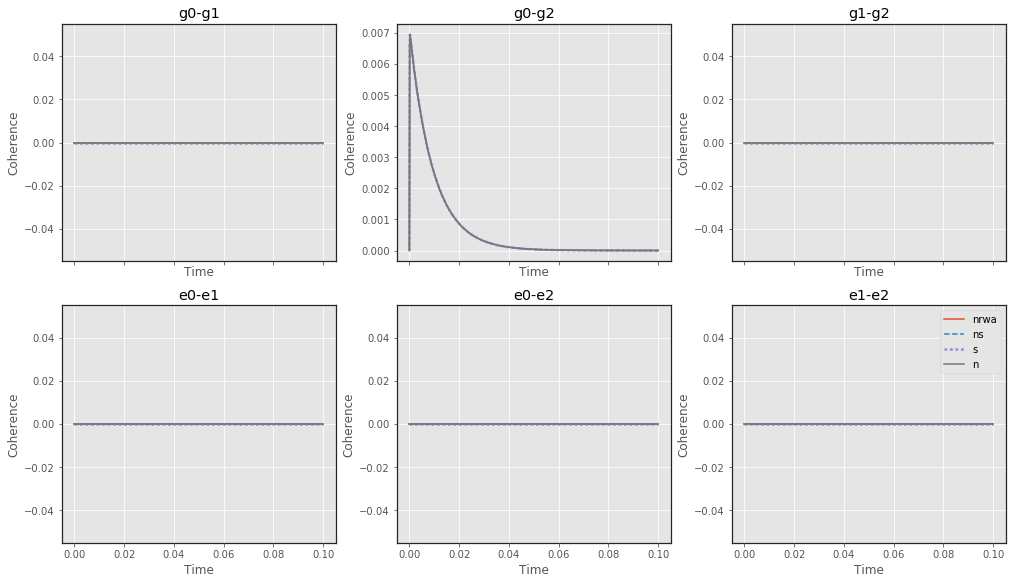

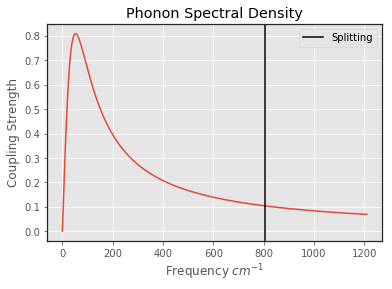

w_RC= 814.6155  TLS splitting = 806.55 RC-res. coupling= 2.49327083739  N= 15 TLS-RC coupling= 45.4325296588 Gamma_RC=  12761.5079392 alpha_ph= 1.6131 beta= 0.00479616306954
Initial state is |g;0><g;0|
[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
Calculating non-RWA Liouvilliian took 0.811454057693 seconds.
It took  0.809220790863  seconds to build the Non-secular RWA Liouvillian
It took  0.788633108139  seconds to build the vibronic Lindblad Liouvillian
It took  0.00270295143127  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 5.79306292534 seconds.
Completed dynamics calculation 2 in 5.76564311981 seconds.
Completed dynamics calculation 3 in 5.7232298851 seconds.
Completed dynamics calculation 4 in 5.7301440239 seconds.


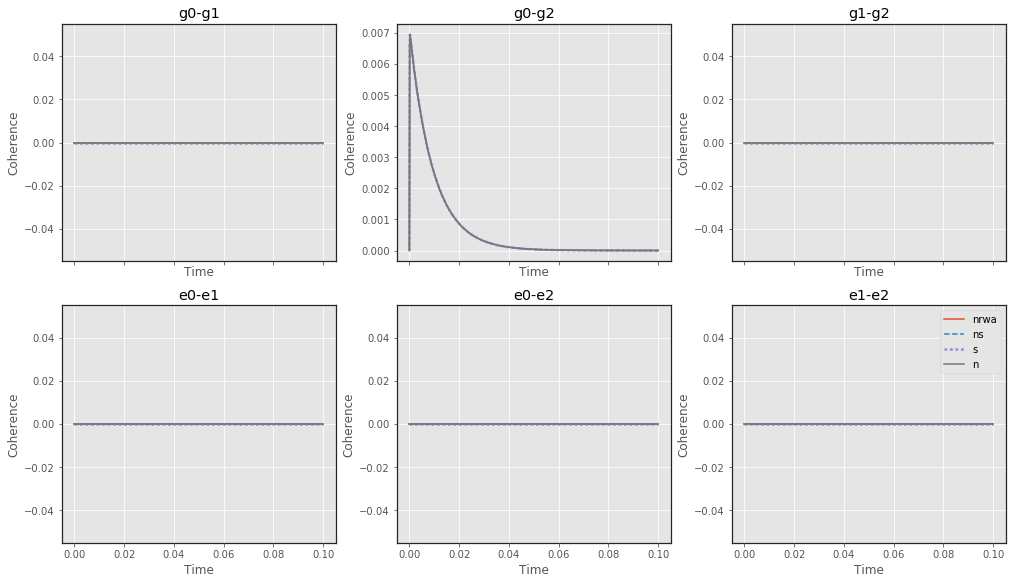

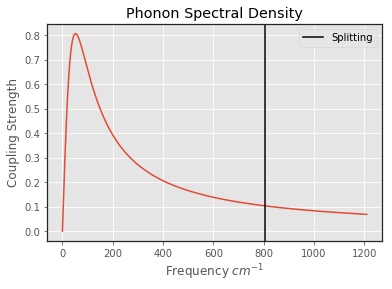

w_RC= 1621.1655  TLS splitting = 806.55 RC-res. coupling= 4.9618558249  N= 15 TLS-RC coupling= 64.0920644283 Gamma_RC=  50541.8765075 alpha_ph= 1.6131 beta= 0.00479616306954
Initial state is |e;0><e;0|
[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
Calculating non-RWA Liouvilliian took 0.605870962143 seconds.
It took  0.847105026245  seconds to build the Non-secular RWA Liouvillian
It took  0.722474098206  seconds to build the vibronic Lindblad Liouvillian
It took  0.00267815589905  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 37.9405760765 seconds.
Completed dynamics calculation 2 in 48.8334810734 seconds.
Completed dynamics calculation 3 in 59.2203121185 seconds.
Completed dynamics calculation 4 in 43.2085108757 seconds.


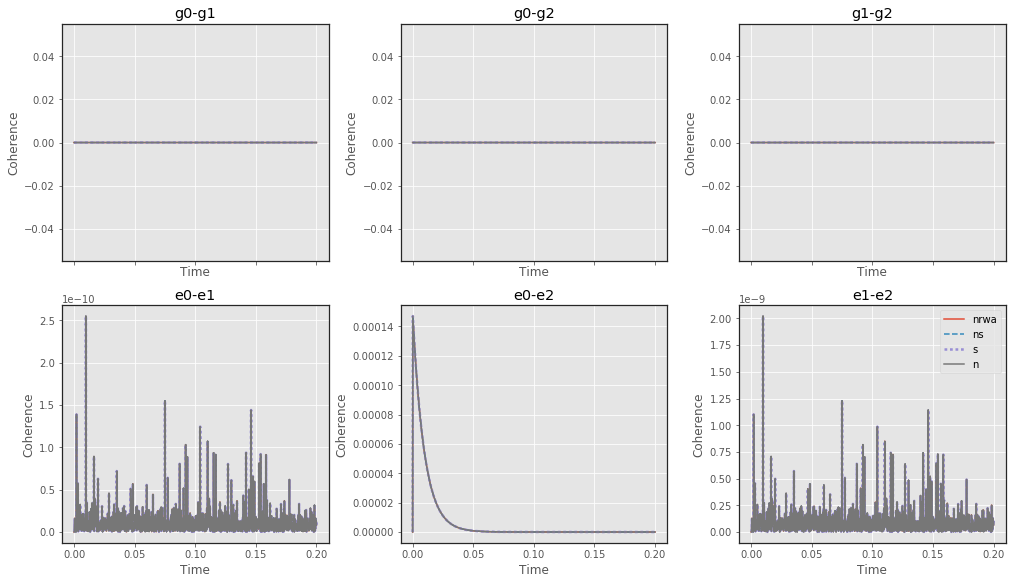

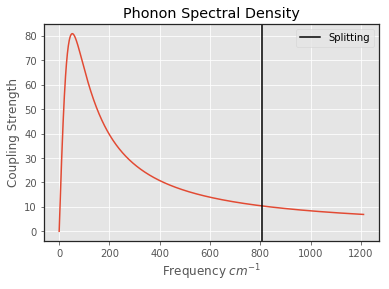

w_RC= 814.6155  TLS splitting = 806.55 RC-res. coupling= 2.49327083739  N= 15 TLS-RC coupling= 454.325296588 Gamma_RC=  12761.5079392 alpha_ph= 161.31 beta= 0.00479616306954
Initial state is |e;0><e;0|
[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 22, 24, 26, 28, 29]
Calculating non-RWA Liouvilliian took 0.584719181061 seconds.
It took  0.753610134125  seconds to build the Non-secular RWA Liouvillian
It took  1.05443811417  seconds to build the vibronic Lindblad Liouvillian
It took  0.00274300575256  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 21.7340979576 seconds.
Completed dynamics calculation 2 in 18.5297210217 seconds.
Completed dynamics calculation 3 in 17.924118042 seconds.
Completed dynamics calculation 4 in 15.2613270283 seconds.


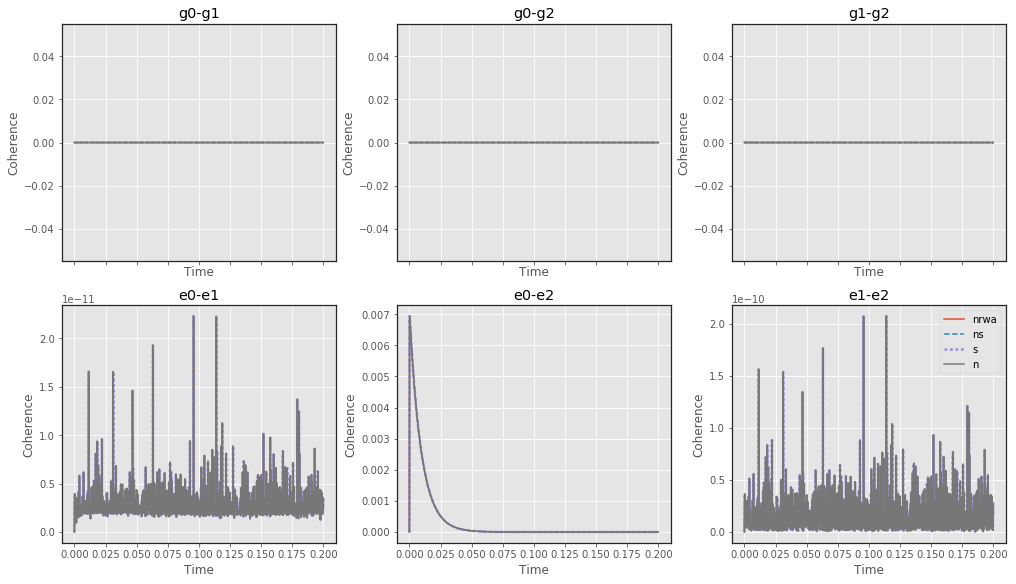

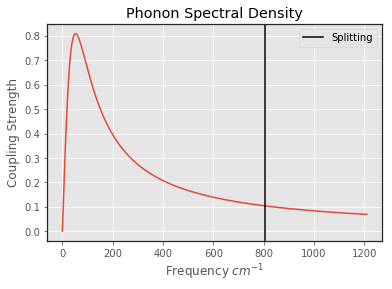

w_RC= 814.6155  TLS splitting = 806.55 RC-res. coupling= 2.49327083739  N= 15 TLS-RC coupling= 45.4325296588 Gamma_RC=  12761.5079392 alpha_ph= 1.6131 beta= 0.00479616306954
Initial state is |e;0><e;0|
[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
Calculating non-RWA Liouvilliian took 0.527643203735 seconds.
It took  0.681944847107  seconds to build the Non-secular RWA Liouvillian
It took  0.764406204224  seconds to build the vibronic Lindblad Liouvillian
It took  0.00272393226624  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 11.2032220364 seconds.
Completed dynamics calculation 2 in 11.5546159744 seconds.
Completed dynamics calculation 3 in 12.306538105 seconds.
Completed dynamics calculation 4 in 11.379090786 seconds.


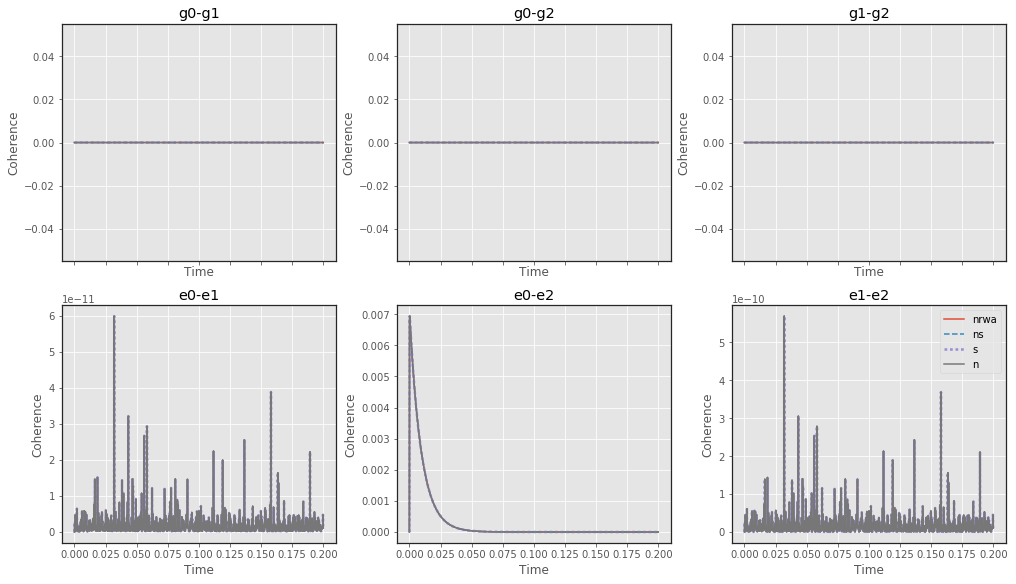

'\nvibronic_coherence_dynamics(10, 2, 0.2, eps, 10., 0, T_ph=300., T_EM=0., \n                                    Gamma_EM=Gamma_EM, overdamped=True, optical_off=True)\n\nvibronic_coherence_dynamics(0, 1, 0.2, eps, 10., 0, T_ph=300., T_EM=6000., \n                                    Gamma_EM=Gamma_EM, overdamped=True, optical_off=True)\nvibronic_coherence_dynamics(0, 2, 0.2, eps, 10., 0, T_ph=300., T_EM=6000., \n                                    Gamma_EM=Gamma_EM, overdamped=True, optical_off=True)\n\nvibronic_coherence_dynamics(1, 1, 0.2, eps, 10., 0, T_ph=300., T_EM=0., \n                                    Gamma_EM=Gamma_EM, overdamped=True, optical_off=True)\nvibronic_coherence_dynamics(1, 2, 0.2, eps, 10., 0, T_ph=300., T_EM=0., \n                                    Gamma_EM=Gamma_EM, overdamped=True, optical_off=True)\n'

In [74]:
vibronic_coherence_dynamics(0, 0, 0.002, eps, 10., 0, T_ph=300., T_EM=6000., 
                                    Gamma_EM=Gamma_EM, overdamped=True, 
                                    optical_off=True, end_time_scaler=0.1, w0_prop=2.01)
vibronic_coherence_dynamics(0, 0, 0.2, eps, 10., 0, T_ph=300., T_EM=6000., 
                                    Gamma_EM=Gamma_EM, overdamped=True, 
                                    optical_off=True, end_time_scaler=0.1)
vibronic_coherence_dynamics(0, 0, 0.002, eps, 10., 0, T_ph=300., T_EM=6000., 
                                    Gamma_EM=Gamma_EM, overdamped=True, 
                                    optical_off=True, end_time_scaler=0.1)

vibronic_coherence_dynamics(1, 0, 0.002, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True, 
                                    optical_off=True, end_time_scaler=0.1, w0_prop=2.01)

vibronic_coherence_dynamics(1, 0, 0.2, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True, 
                                    optical_off=True, end_time_scaler=0.1)

vibronic_coherence_dynamics(1, 0, 0.002, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True, 
                                    optical_off=True, end_time_scaler=0.1)

"""
vibronic_coherence_dynamics(10, 2, 0.2, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True, optical_off=True)

vibronic_coherence_dynamics(0, 1, 0.2, eps, 10., 0, T_ph=300., T_EM=6000., 
                                    Gamma_EM=Gamma_EM, overdamped=True, optical_off=True)
vibronic_coherence_dynamics(0, 2, 0.2, eps, 10., 0, T_ph=300., T_EM=6000., 
                                    Gamma_EM=Gamma_EM, overdamped=True, optical_off=True)

vibronic_coherence_dynamics(1, 1, 0.2, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True, optical_off=True)
vibronic_coherence_dynamics(1, 2, 0.2, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True, optical_off=True)
"""

**Coherence dynamics with no optical field:** we see very short time coherence generation on the same manifold that the excitation is localised on.

### Turn off RC-residual-bath coupling

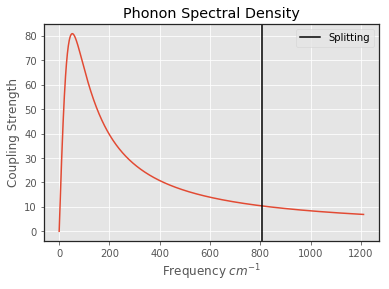

w_RC= 814.6155  TLS splitting = 806.55 RC-res. coupling= 0  N= 15 TLS-RC coupling= 454.325296588 Gamma_RC=  12761.5079392 alpha_ph= 161.31 beta= 0.00479616306954
[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 22, 24, 26, 28, 29]
Calculating non-RWA Liouvilliian took 0.72950387001 seconds.
It took  0.993618011475  seconds to build the Non-secular RWA Liouvillian
It took  1.65993213654  seconds to build the vibronic Lindblad Liouvillian
It took  0.00513482093811  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 12.484732151 seconds.
Completed dynamics calculation 2 in 9.74342894554 seconds.
Completed dynamics calculation 3 in 1.39954996109 seconds.
Completed dynamics calculation 4 in 3.97451019287 seconds.


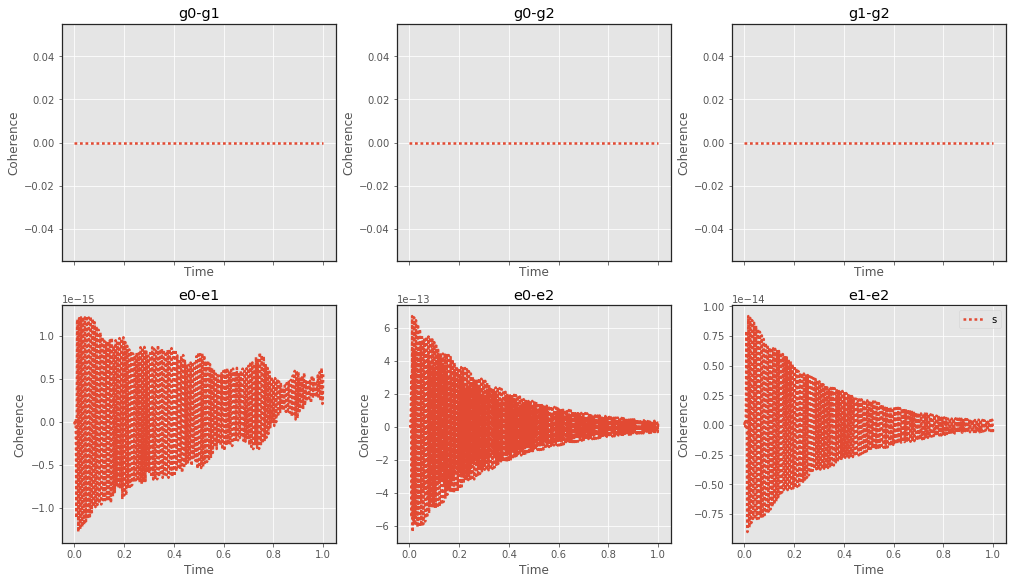

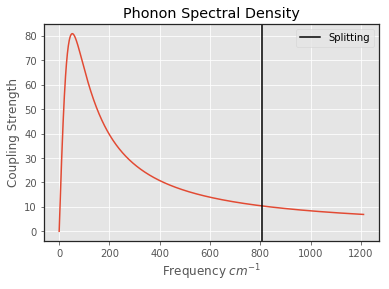

w_RC= 814.6155  TLS splitting = 806.55 RC-res. coupling= 0  N= 15 TLS-RC coupling= 454.325296588 Gamma_RC=  12761.5079392 alpha_ph= 161.31 beta= 0.00479616306954
[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 22, 24, 26, 28, 29]
Calculating non-RWA Liouvilliian took 0.55383515358 seconds.
It took  0.825709819794  seconds to build the Non-secular RWA Liouvillian
It took  1.325330019  seconds to build the vibronic Lindblad Liouvillian
It took  0.00459384918213  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 32.9775030613 seconds.
Completed dynamics calculation 2 in 15.8311998844 seconds.
Completed dynamics calculation 3 in 2.34233307838 seconds.
Completed dynamics calculation 4 in 10.0105669498 seconds.


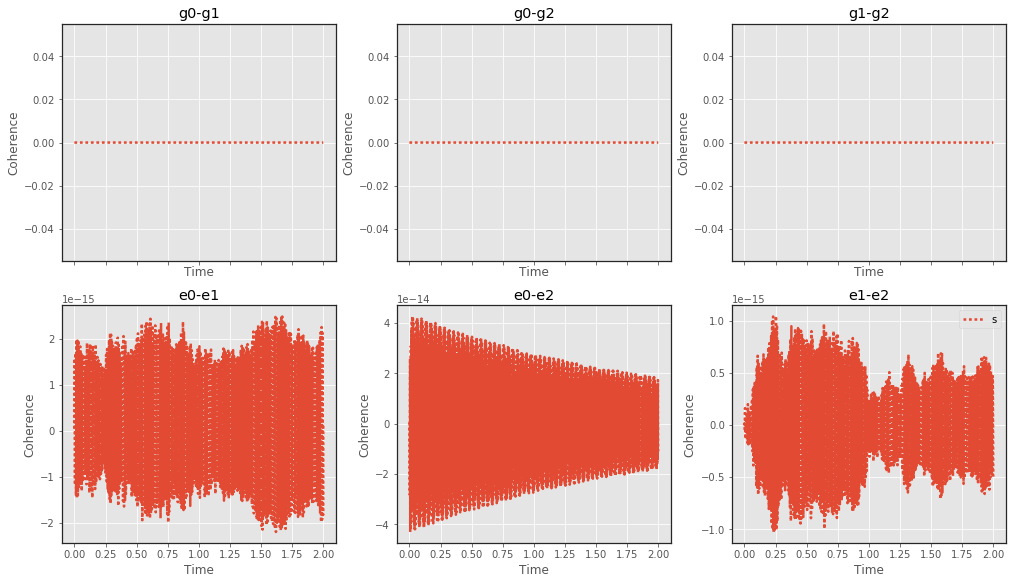

In [54]:
vibronic_coherence_dynamics(0, 0, 0.2, eps, 10., 0, T_ph=300., T_EM=6000., 
                                    Gamma_EM=Gamma_EM, overdamped=True, residual_off=True)
vibronic_coherence_dynamics(1, 0, 0.2, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True, residual_off=True)

** Turn off RC-residual-bath coupling:** no (O(numerical error)) coherences are generated by the secular theory with the optical driving field alone. This is in line with what we would expect.

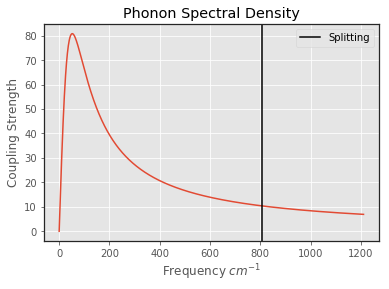

w_RC= 1209.825  TLS splitting = 806.55 RC-res. coupling= 3.70287748127  N= 15 TLS-RC coupling= 553.6711079 Gamma_RC=  28147.6255889 alpha_ph= 161.31 beta= 0.00479616306954
Initial state is |e;0><e;0|
[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 28, 29]
Calculating non-RWA Liouvilliian took 0.704199790955 seconds.
It took  0.961817979813  seconds to build the Non-secular RWA Liouvillian
It took  1.14218211174  seconds to build the vibronic Lindblad Liouvillian
It took  0.00277400016785  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 361.414096832 seconds.
Completed dynamics calculation 2 in 269.124100924 seconds.


/home/henry/anaconda2/envs/qutip/lib/python2.7/site-packages/scipy/integrate/_ode.py:869: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  'Unexpected istate=%s' % istate))


Exception: ODE integration error: Try to increase the allowed number of substeps by increasing the nsteps parameter in the Options class.

In [61]:
vibronic_coherence_dynamics(1, 0, 0.2, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True, w0_prop=1.5)
vibronic_coherence_dynamics(1, 0, 0.2, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True, w0_prop=2.0)
vibronic_coherence_dynamics(1, 0, 0.2, eps, 10., 0, T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True, w0_prop=2.5)

The above calculations show very similar coherence dynamics in the excited manifold for non-sec and non-RWA in short times. I've calculated the same figures but without the optical part to see if it's phonon generated. On very short timescales there are spikes of vibronic coherences generated within the manifold that the excitation is initially localised on. These spikes tend to occur between the zeroth and second vibrational excitation states. Could check to see if this occurs still if the system is prepared in $|g; 1\rangle$ etc.

The final thing is that coherences are only generated between vibronic states on the same manifold and not between manifolds. This is very strange, as the optical field cannot cause transitions between states on the same manifold. Why is it that the optical environment can cause superpositions between say e-0 and e-1, but not between e-0 and g-1?

So above, we can see that there is rapid coherence generation on short timescales, on the manifold(s) which the systems is started on. It seems like coherence is generated on the excited manifold more readily, possibly because the bath is only coupled to the excited state. Another thing is that the coherence dynamics don't seem to depend strongly on *which* vibrational state the system starts in - it is always the e0-e2 and g0-g2 transitions which are 
How about when the system does not have a non-equilibrium steady state?

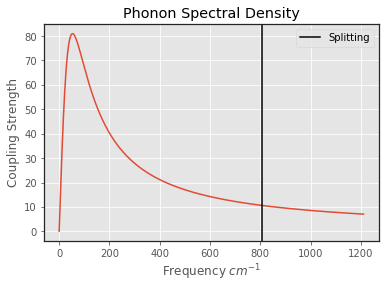

w_RC= 814.6155  TLS splitting = 806.55 RC-res. coupling= 2.4462279914  N= 9 TLS-RC coupling= 454.325296588 Gamma_RC=  12520.7247706 alpha_ph= 161.31 beta= 0.00479616306954
[1, 3, 5, 7, 9, 12, 14, 16, 17]
Calculating non-RWA Liouvilliian took 0.278502941132 seconds.
It took  0.269783973694  seconds to build the Non-secular RWA Liouvillian
It took  0.292906999588  seconds to build the vibronic Lindblad Liouvillian
It took  0.00262904167175  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 26.3432619572 seconds.
Completed dynamics calculation 2 in 22.6368229389 seconds.
Completed dynamics calculation 3 in 19.0049338341 seconds.
Completed dynamics calculation 4 in 17.656845808 seconds.


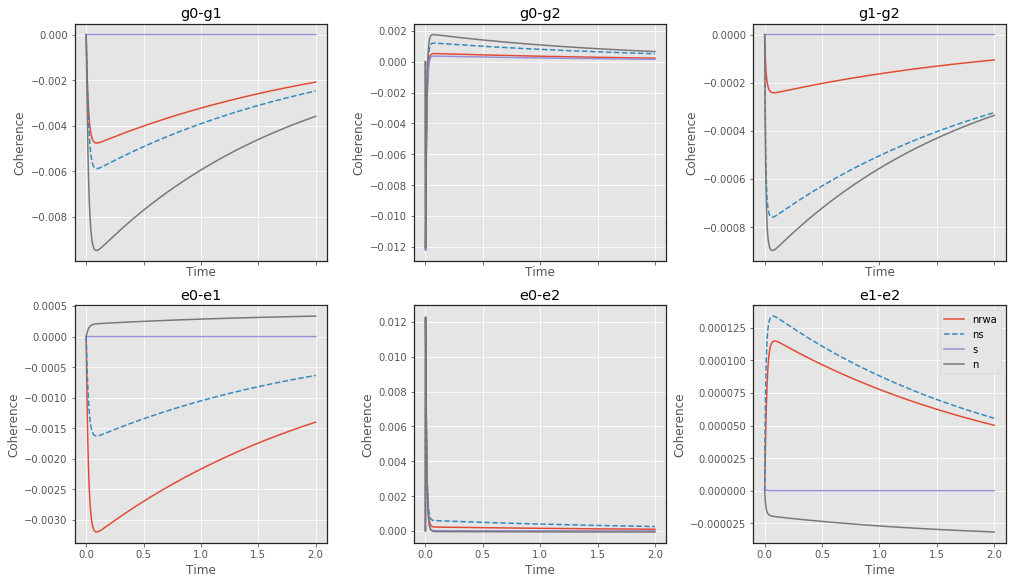

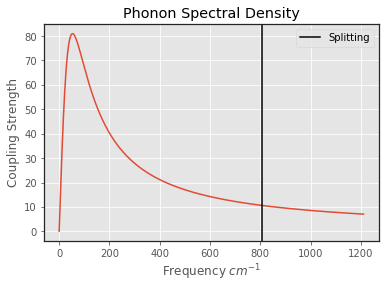

w_RC= 814.6155  TLS splitting = 806.55 RC-res. coupling= 2.4462279914  N= 9 TLS-RC coupling= 454.325296588 Gamma_RC=  12520.7247706 alpha_ph= 161.31 beta= 0.00479616306954
[1, 3, 5, 7, 9, 12, 14, 16, 17]
Calculating non-RWA Liouvilliian took 0.196196079254 seconds.
It took  0.271471977234  seconds to build the Non-secular RWA Liouvillian
It took  0.289206981659  seconds to build the vibronic Lindblad Liouvillian
It took  0.00257682800293  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 30.0746099949 seconds.
Completed dynamics calculation 2 in 21.9902780056 seconds.
Completed dynamics calculation 3 in 18.6435739994 seconds.
Completed dynamics calculation 4 in 17.2919101715 seconds.


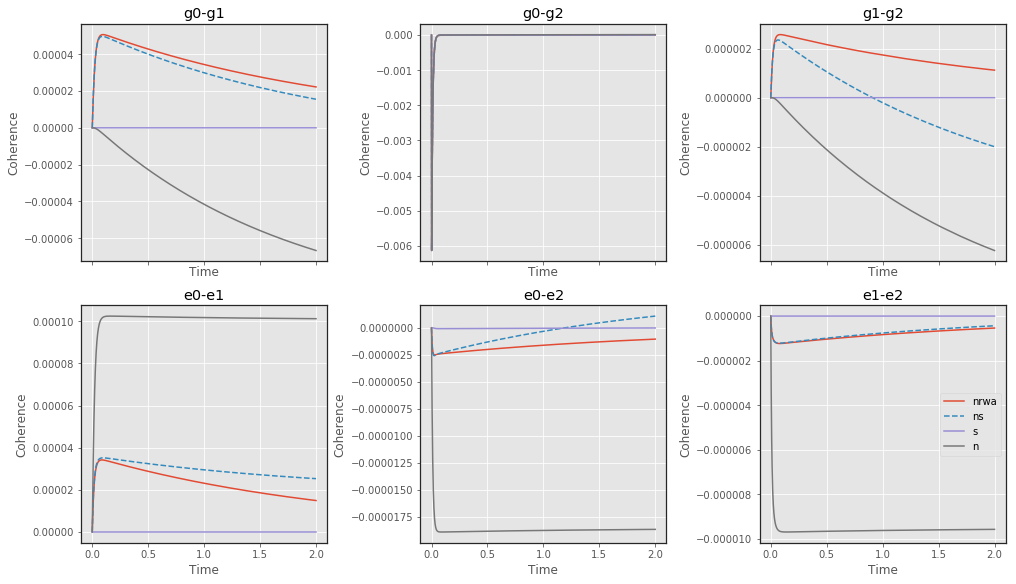

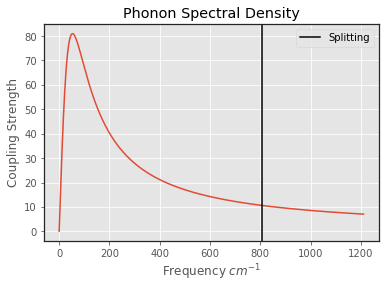

w_RC= 814.6155  TLS splitting = 806.55 RC-res. coupling= 2.4462279914  N= 9 TLS-RC coupling= 454.325296588 Gamma_RC=  12520.7247706 alpha_ph= 161.31 beta= 0.00479616306954
[1, 3, 5, 7, 9, 12, 14, 16, 17]
Calculating non-RWA Liouvilliian took 0.18791103363 seconds.
It took  0.266973018646  seconds to build the Non-secular RWA Liouvillian
It took  0.288666009903  seconds to build the vibronic Lindblad Liouvillian
It took  0.00256586074829  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 25.1113920212 seconds.
Completed dynamics calculation 2 in 21.974807024 seconds.
Completed dynamics calculation 3 in 18.3770329952 seconds.
Completed dynamics calculation 4 in 17.0023181438 seconds.


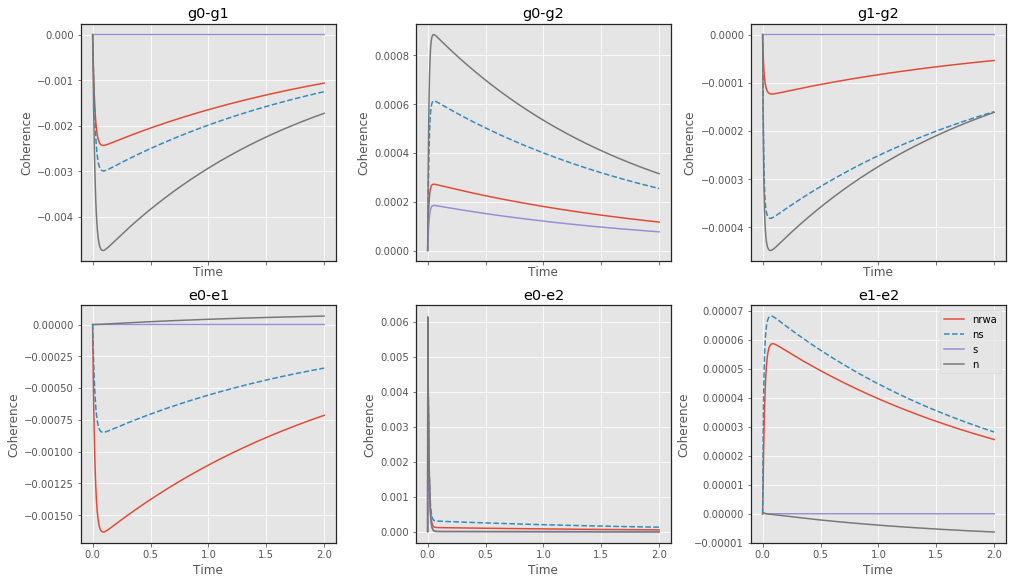

In [9]:
vibronic_coherence_dynamics(10, 0, 0.2, eps, 10., 0, T_ph=300., T_EM=300., 
                                    Gamma_EM=Gamma_EM, overdamped=True)
vibronic_coherence_dynamics(0, 0, 0.2, eps, 10., 0, T_ph=300., T_EM=300., 
                                    Gamma_EM=Gamma_EM, overdamped=True)
vibronic_coherence_dynamics(1, 0, 0.2, eps, 10., 0, T_ph=300., T_EM=300., 
                                    Gamma_EM=Gamma_EM, overdamped=True)

FROM note-bank:
To see whether it was the non-equilibrium nature of the problem which was causing the coherences in the secular case, I made the baths the same temperature. When starting this system in the ground state (this is more like the steady state, also the ground manifold is not coupled to the vibrational bath so likely to), the only coherences which are generated are the ones which also exist for no optical bath (spiking in g0-g2). Starting in excited state: g0-g2 still generates coherences as before, but e0-e2 spikes like the no optical bath case. This could be due to the fact that initially e0 is far from the steadystate of the system. This phenomenologically (potenitally) explains the dynamics, but I don't understand WHY the non-equilibrium properties would be causing this.

## Off-diagonal decay rates: $\alpha_{ph}$ dependence

In [136]:
from qutip import qeye, tensor
from qutip import vector_to_operator, operator_to_vector, basis

def off_diag_decay_rate_alpha(init_sys, init_RC, eps, T_ph,
                              w0_prop=3.1, overdamped=True, 
                              T_EM=0., populations=False,
                              N=9, n_xpoints=30):
    alpha_props = np.linspace(0.001,1.5,n_xpoints)
    alpha_ph = alpha_props*eps
    w0 = w0_prop*eps
    if overdamped:
        Gamma_ = w0**2/wc
    else:
        Gamma_ = 30.
    decay_wrt_alpha = [[],[],[],[]]
    count = 1
    for alpha_ in alpha_ph:
        
        L_RC, H, A_EM, A_nrwa, wRC, kappa, Gamma_1 = RC.RC_function_UD(sigma, eps, T_ph, 
                                                                       Gamma_, w0, alpha_, 
                                                                       N, silent=True)
    # given some Liouvillian, find the instantaneous decay rates
    # from e-0 to the ground manifold eigenstates, for several
    # oscillator displacements
    # - need to find the first eigenstate in the excited manifold
        evals, states = H.eigenstates()
        ground_list = []
        excited_list = []
        concat_list = [ground_list, excited_list]
        for i in range(len(evals)): #
            is_ground = sum(states[i])[0][0].real == 1.
            if is_ground:
                ground_list.append(i)
            else:
                excited_list.append(i)
        excited_ket = states[excited_list[0]]
        if type(init_sys) == tuple:
        #coherence state
            if type(init_RC) == tuple:
                # take in a 2-tuple to initialise in coherence state.
                rho_left = states[concat_list[init_sys[0]][init_RC[0]]]
                rho_right = states[concat_list[init_sys[1]][init_RC[1]]].dag()
                init_rho = rho_left*rho_right
                
            else:
                raise ValueError
        elif init_sys == 0:
            # population state
            init_rho = states[ground_list[init_RC]]*states[ground_list[init_RC]].dag()
        elif init_sys==1:
            init_rho = states[excited_list[init_RC]]*states[excited_list[init_RC]].dag()
        else:
            # if in neither ground or excited
            # for the minute, do nothing. This'll be fixed below.
            pass
        ground = [states[j] for j in ground_list]
        excited = [states[j] for j in excited_list]
        expects_vib = []
        if not populations:
            labels = ['g0-g1',  'g0-g2', 'g1-g2'] # coherences
            expects_vib = [ground[0]*ground[1].dag(), ground[0]*ground[2].dag(),
                           ground[1]*ground[2].dag()]
            labels += ['g1-g0',  'g2-g0', 'g2-g1'] # other interesting coherences
            expects_vib += [ground[1]*ground[0].dag(), ground[2]*ground[0].dag(),
                           ground[2]*ground[1].dag()]
            labels += ['e0-e1', 'e0-e2', 'e1-e2']
            expects_vib += [excited[0]*excited[1].dag(), excited[0]*excited[2].dag(),
                           excited[1]*excited[2].dag()]
            labels += ['e1-e0', 'e2-e0', 'e2-e1']
            expects_vib += [excited[1]*excited[0].dag(), excited[2]*excited[0].dag(),
                           excited[2]*excited[1].dag()]
            
        else:
            labels = ['g0', 'g1', 'g2'] # populations
            expects_vib += [ground[0]*ground[0].dag(), ground[1]*ground[1].dag(),
                                                        ground[2]*ground[2].dag()]
            labels += ['g1-e0', 'e0-g1', 'ground'] # populations
            expects_vib += [ground[0]*excited[1].dag(), excited[0]*ground[1].dag(),
                                                        tensor(G*G.dag(), qeye(N))]
            labels += ['e0', 'e1', 'excited'] # populations
            expects_vib += [excited[0]*excited[0].dag(), 
                            excited[1]*excited[1].dag(),tensor(E*E.dag(), qeye(N))]
        L= [EM.L_non_rwa(H, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM, silent=True), 
            EM.L_nonsecular(H, A_EM, eps, Gamma_EM, T_EM, J=J_EM, silent=True),
            EM.L_vib_lindblad(H, A_EM, eps, Gamma_EM, T_EM, J=J_EM, silent=True),
            EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J_EM, silent=True)]
        for i_, L_EM in enumerate(L):
            decay_rates = []
            L_rho0_prod = vector_to_operator(L_EM*operator_to_vector(init_rho))
            for j in range(len(expects_vib)): 
                rate = (expects_vib[j]*L_rho0_prod).tr()
                decay_rates.append(abs(rate))
            decay_wrt_alpha[i_].append(decay_rates)
        if count ==1 or count%5==0:
            print "{:0.2f}% finished".format((float(count)/len(alpha_ph))*100)
        count+=1
    print "Initial state is"+state_string(init_sys, init_RC)
    #f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', figsize=(14,8))
    if not populations:
        f, ((ax1, ax2, ax3), (ax4, ax5, ax6), 
            (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3, sharex='col', figsize=(14,16))
    else:
        f, ((ax1, ax2, ax3), (ax4, ax5, ax6), 
            (ax7, ax8, ax9)) = plt.subplots(3, 3, sharex='col', figsize=(14,12))
    axes = [eval("ax{}".format(i)) for i in range(1,len(expects_vib)+1)]
    for i in range(len(expects_vib)): # each level of interest
        axes[i].set_title(labels[i])
        axes[i].plot(alpha_props,np.array(decay_wrt_alpha[0]).T[i], label='non-RWA')
        axes[i].plot(alpha_props,np.array(decay_wrt_alpha[1]).T[i], label='non-sec', linestyle='dashed')
        axes[i].plot(alpha_props,np.array(decay_wrt_alpha[2]).T[i], label='sec', linestyle='dotted', linewidth=2.5)
        axes[i].plot(alpha_props,np.array(decay_wrt_alpha[3]).T[i], label='naive')
        axes[i].set(xlabel=r"Coupling strength (units of $\epsilon$)", 
               ylabel="Decay rate")
    plt.tight_layout(pad=0.3, w_pad=0.3, h_pad=1.0)
    plt.legend()
    plt.show()
    #return alpha_ph, decay_wrt_alpha

g0-g1 T=6000.
3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished
Initial state is|g;0><g;1|


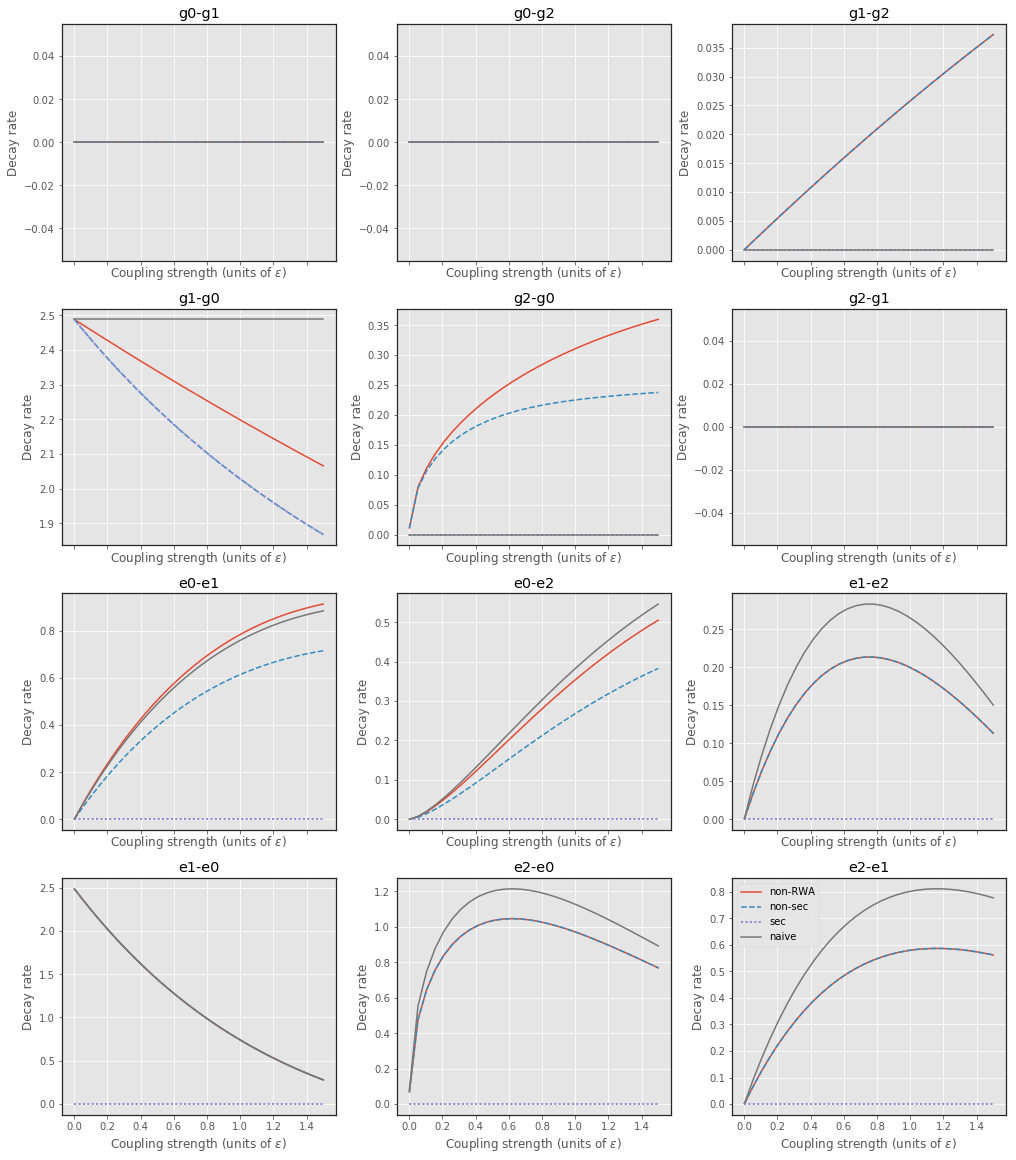

g1-g0 T=6000.
3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished
Initial state is|g;1><g;0|


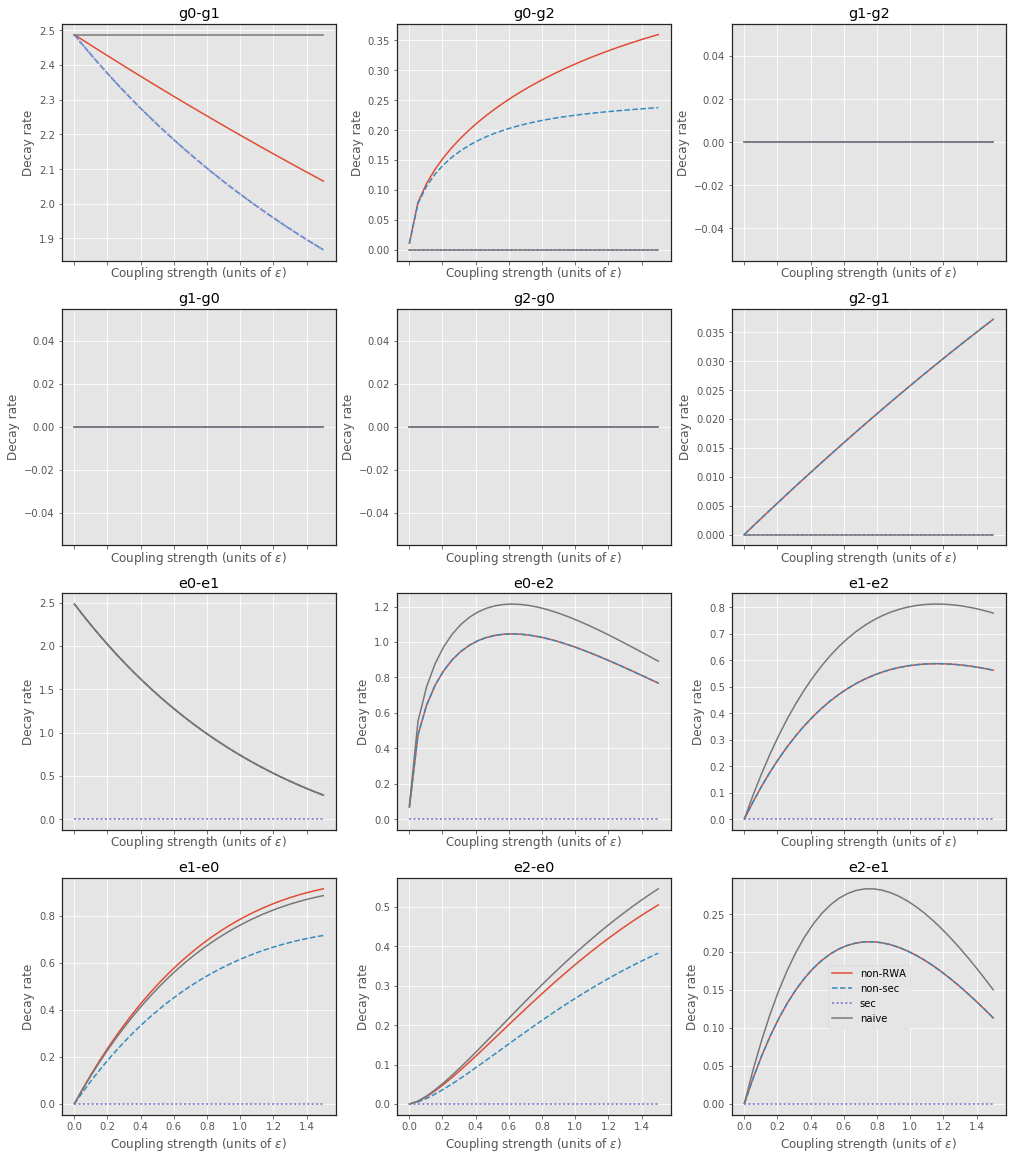

g0-g2 T=6000.
3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished
Initial state is|g;0><g;2|


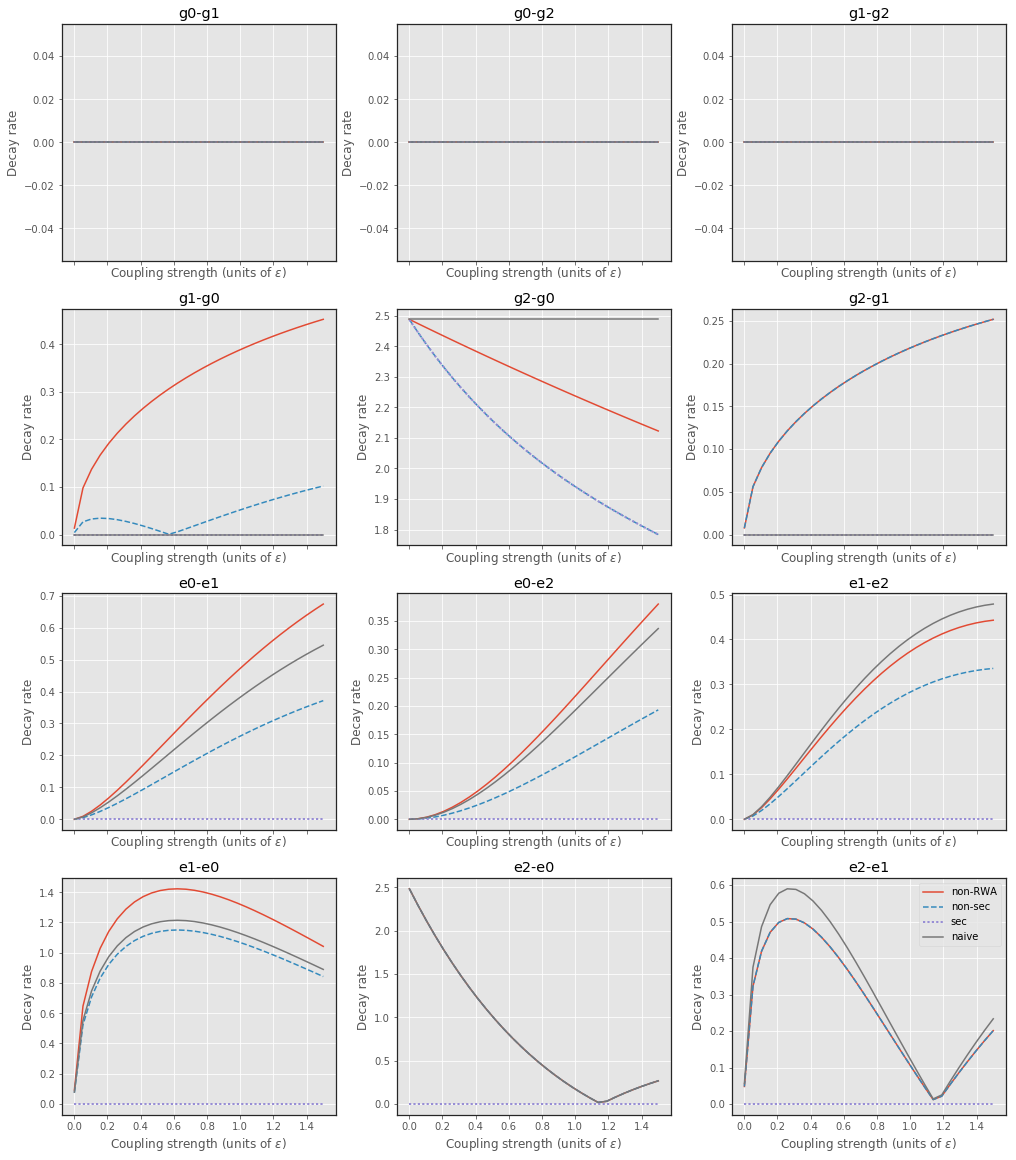

g2-g0 T=6000.
3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished
Initial state is|g;2><g;0|


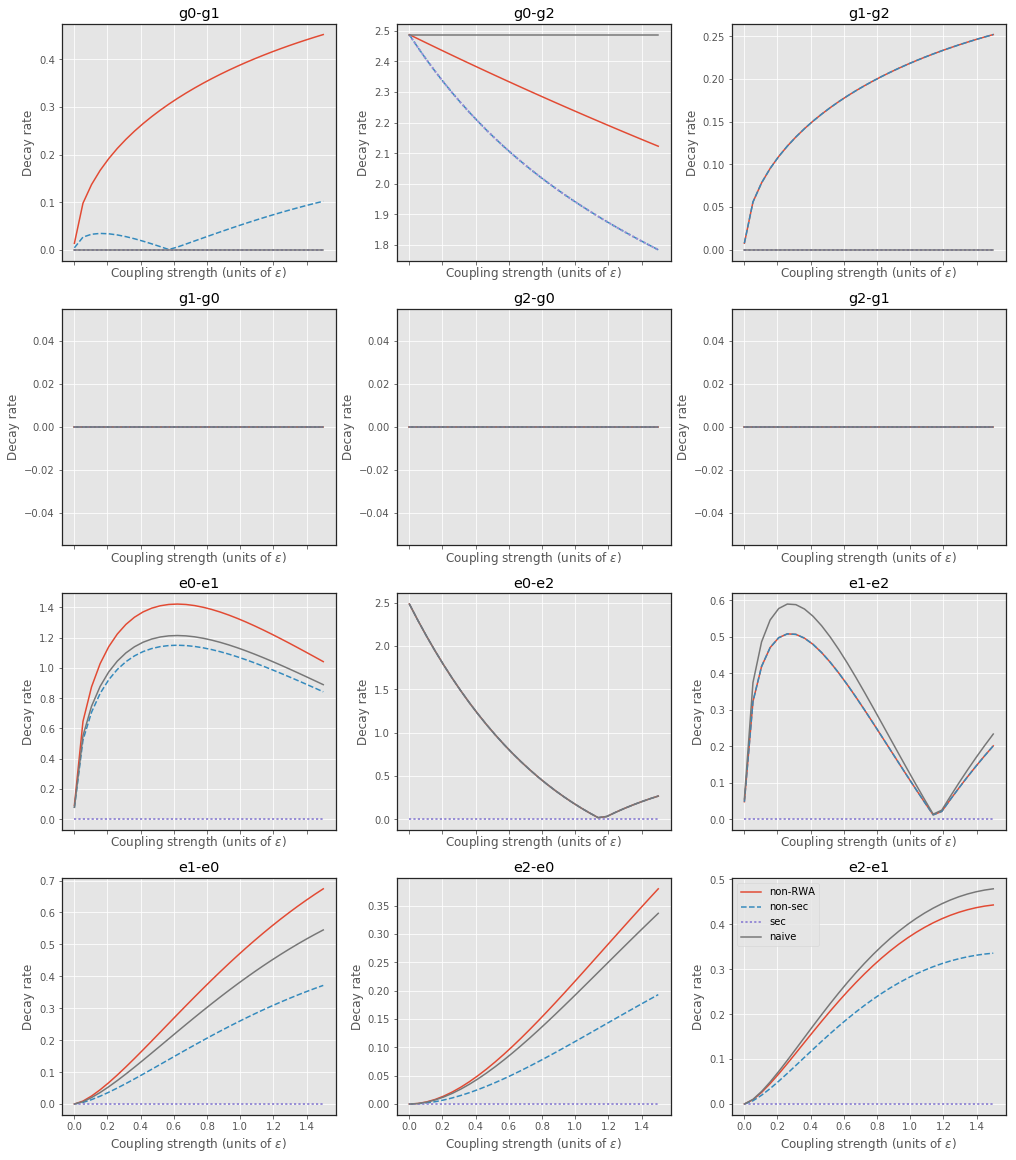

e0-e1 T=0.
3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished
Initial state is|e;0><e;1|


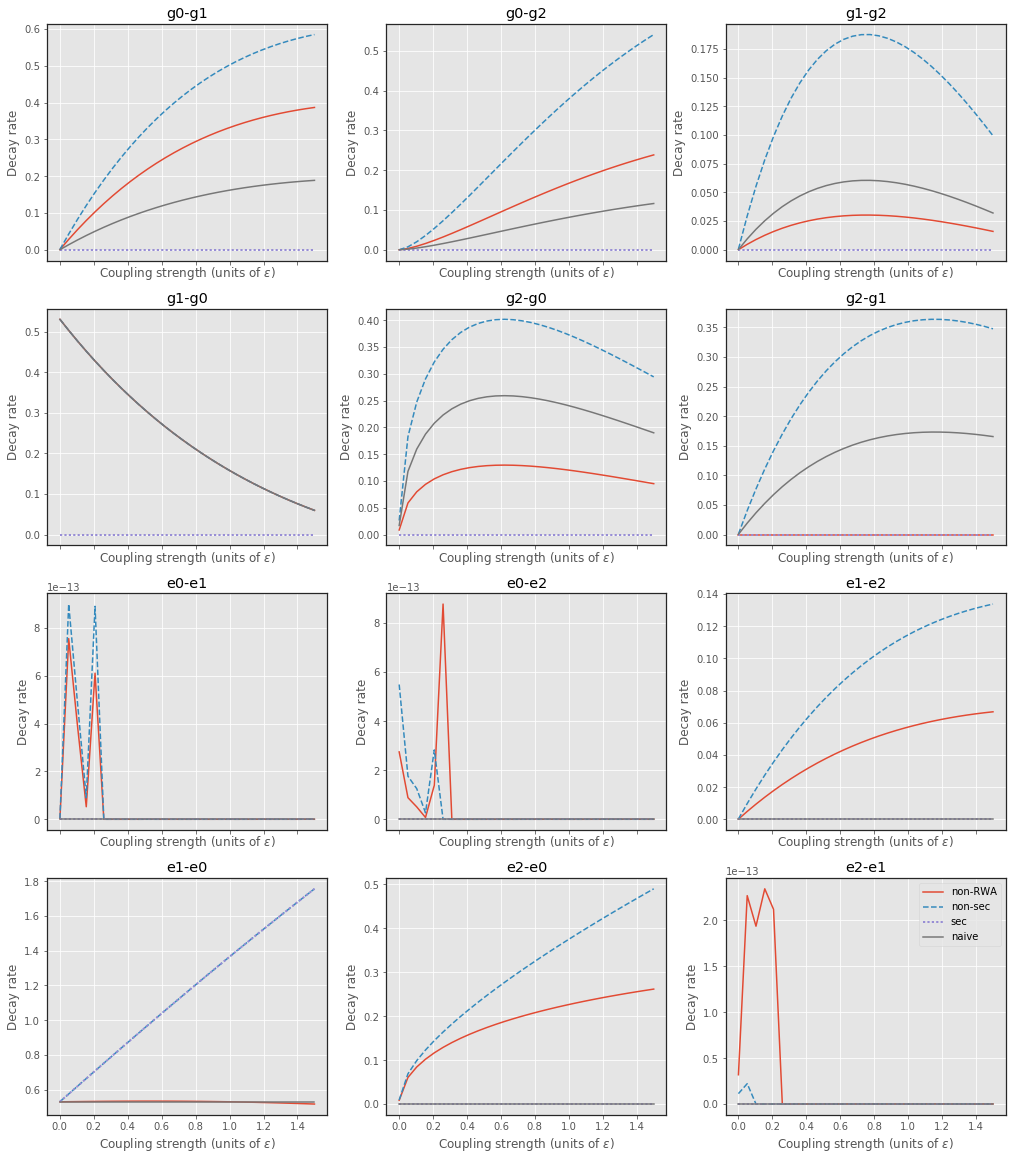

e1-e0 T=0.
3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished
Initial state is|e;1><e;0|


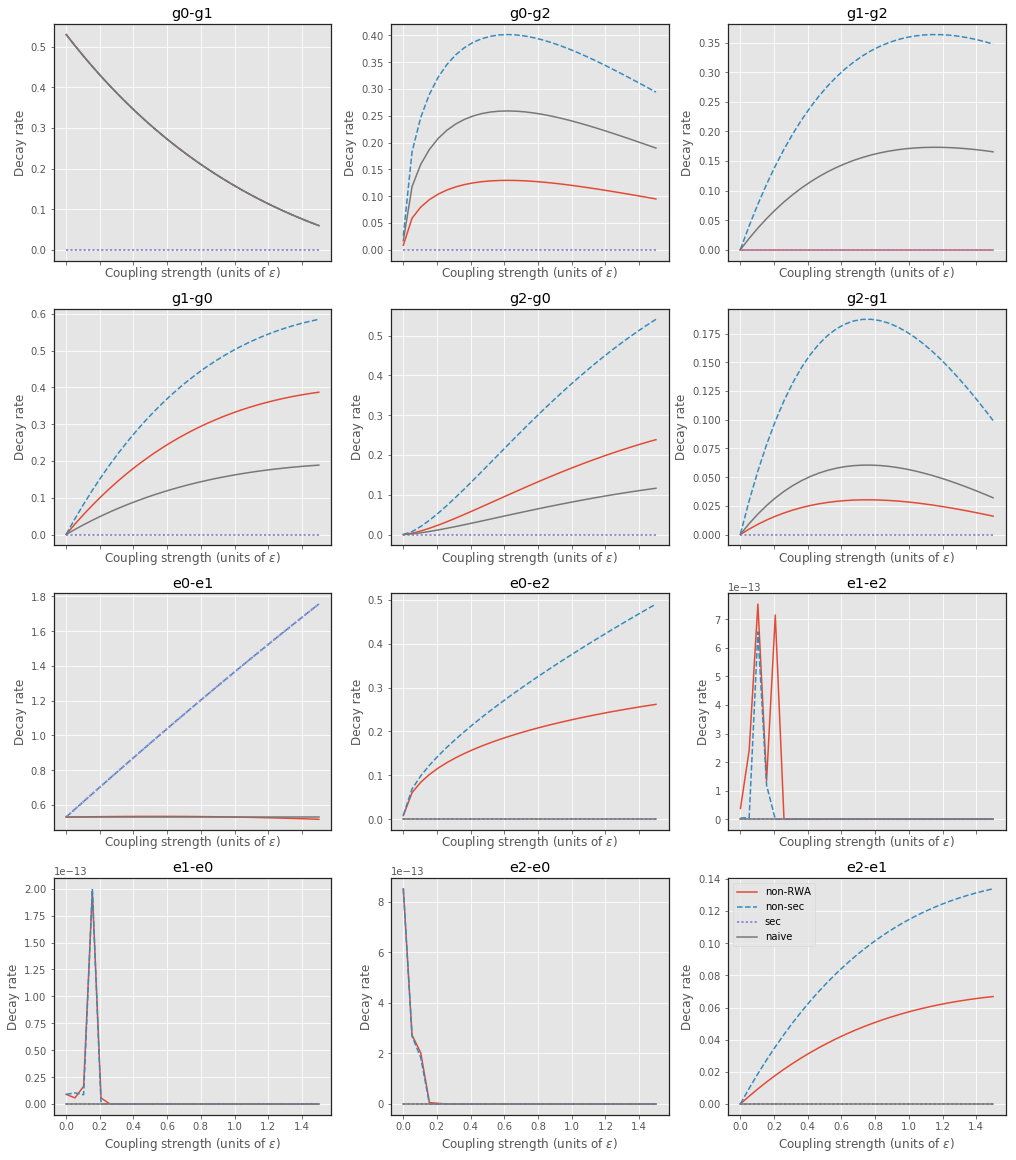

In [134]:
print "g0-g1 T=6000."
off_diag_decay_rate_alpha((0,0), (0,1), eps, T_ph, overdamped=True, T_EM=6000.)
print "g1-g0 T=6000."
off_diag_decay_rate_alpha((0,0), (1,0), eps, T_ph, overdamped=True, T_EM=6000.)
print "g0-g2 T=6000."
off_diag_decay_rate_alpha((0,0), (0,2), eps, T_ph, overdamped=True, T_EM=6000.)
print "g2-g0 T=6000."
off_diag_decay_rate_alpha((0,0), (2,0), eps, T_ph, overdamped=True, T_EM=6000.)
print "e0-e1 T=0."
off_diag_decay_rate_alpha((1,1), (0,1), eps, T_ph,  overdamped=True,  T_EM=0.)
print "e1-e0 T=0."
off_diag_decay_rate_alpha((1,1), (1,0), eps, T_ph,  overdamped=True,  T_EM=0.)

The above check shows that starting the system in Hermitian conjugate coherence states $|g;1\rangle\langle g;0|$ and $|g;0\rangle\langle g;1|$ do not yield the same decay rates, as illustrated below. When swapped for conjugate state, all the rates to all the coherences swap too. This also shows that the naive theory assumes completely zero couplings between coherences on the same manifold - because 

In [135]:
S = qt.Qobj(np.random.rand(6,6))
v1 = qt.Qobj(np.random.rand(6))
v2 = qt.Qobj(np.random.rand(6))
print "< v_2|S|v1>\t< v_2|S|v1>"
print S.matrix_element(v2.dag(),v1).real, ' ',S.matrix_element(v1.dag(),v2).real
print ((v1*v2.dag())*S).tr().real, ' ',((v2*v1.dag())*S).tr().real

< v_2|S|v1>	< v_2|S|v1>
4.18511604497   3.41795803265
4.18511604497   3.41795803265


**Decay from coherences into populations**

g0-g1 T=6000.
3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished
Initial state is|g;0><g;1|


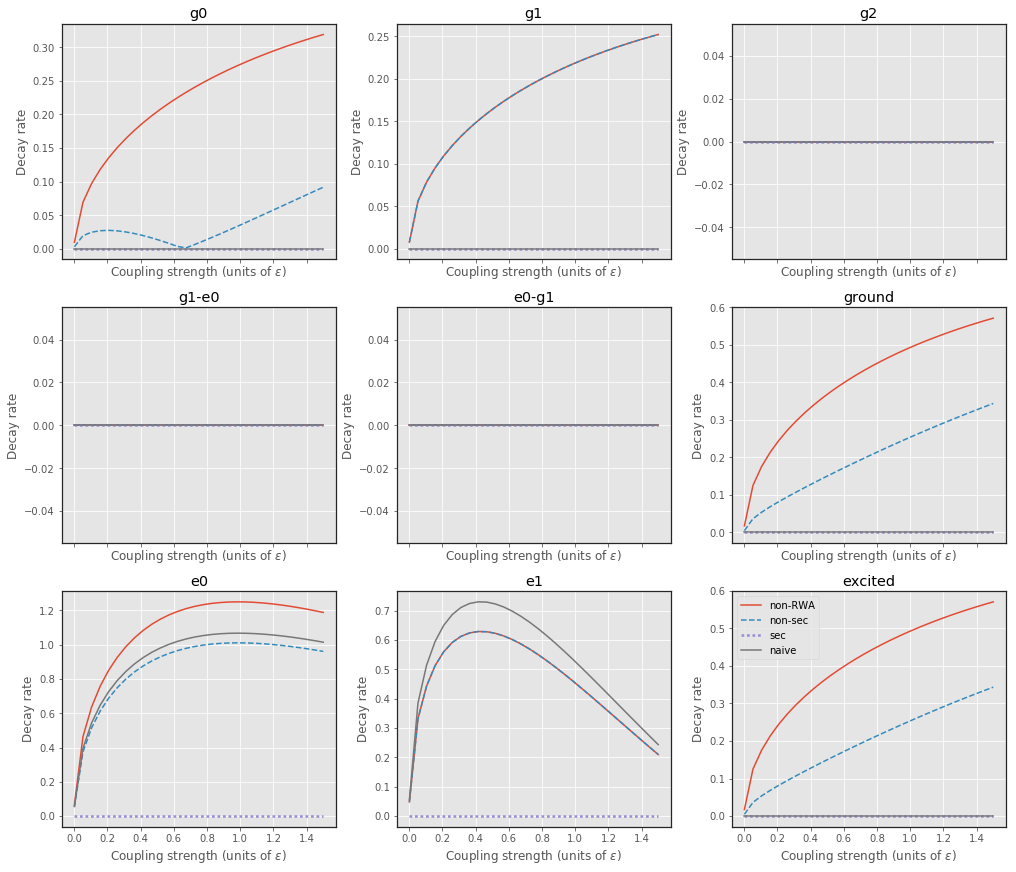

e0-e1 T=0.
3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished
Initial state is|e;0><e;1|


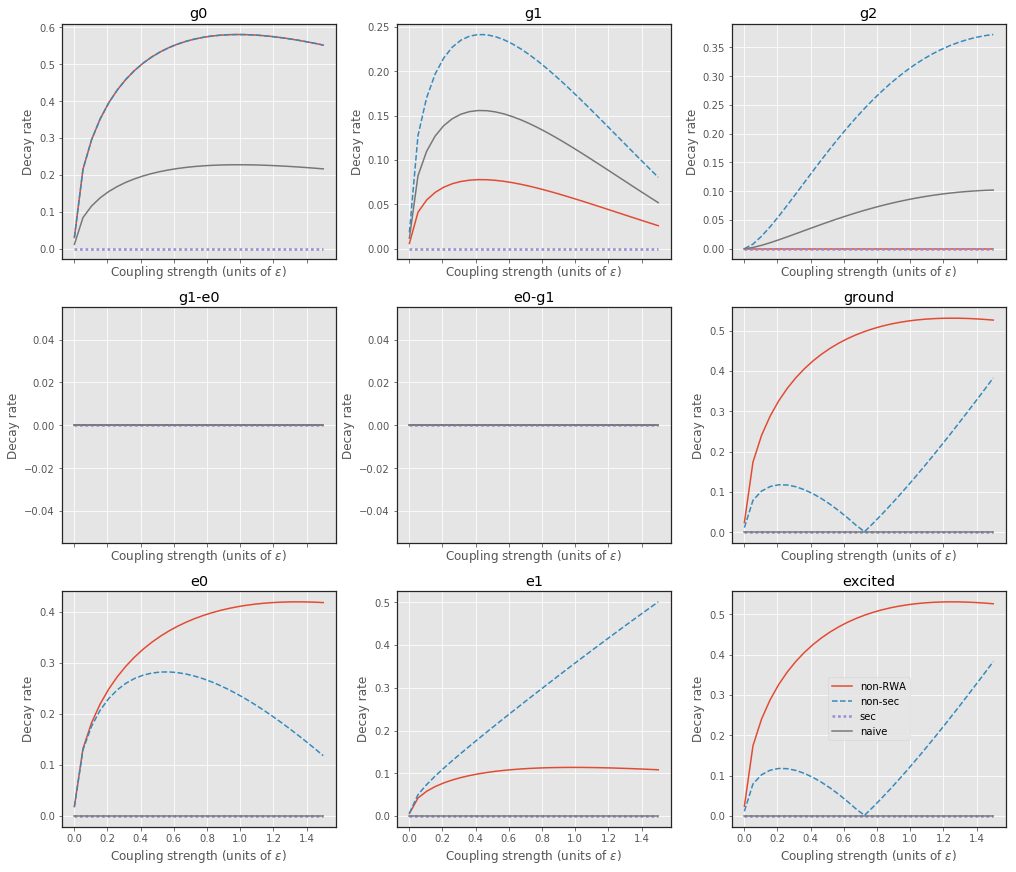

In [138]:
print "g0-g1 T=6000."
off_diag_decay_rate_alpha((0,0), (0,1), eps, T_ph, overdamped=True, T_EM=6000., populations=True)


print "e0-e1 T=0."
off_diag_decay_rate_alpha((1,1), (0,1), eps, T_ph,  overdamped=True,  T_EM=0., populations=True)



Next: prepare system in $|e;1\rangle\langle g;0|$

3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished
Initial state is|e;0><g;1|


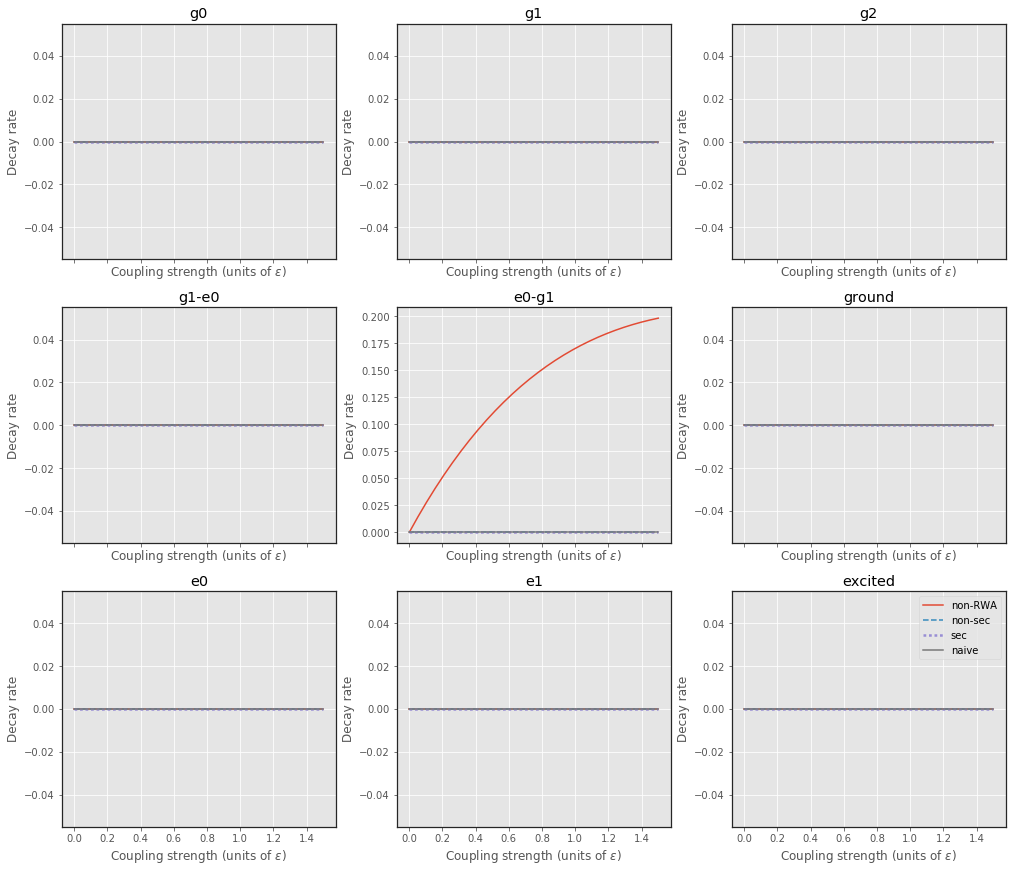

3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished
Initial state is|g;1><e;0|


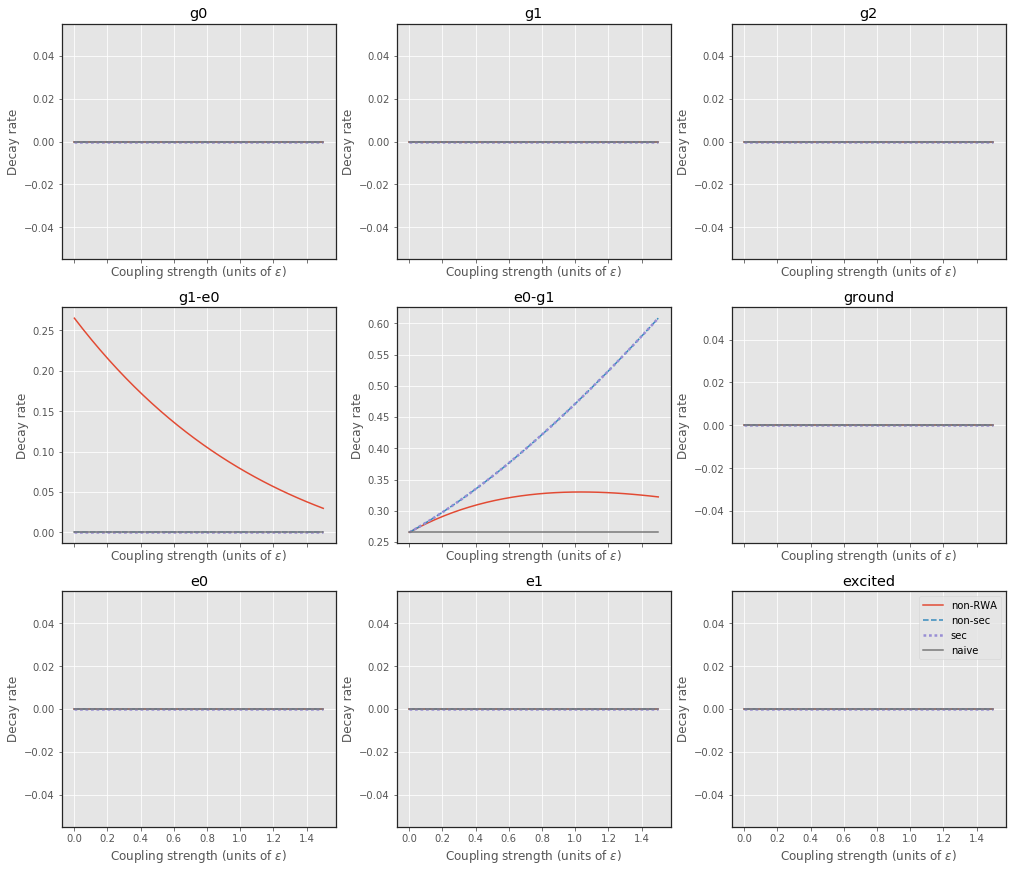

In [142]:
#off_diag_decay_rate_alpha((1,0), (0,1), eps, T_ph, overdamped=True, T_EM=0.)
#off_diag_decay_rate_alpha((0,1), (1,0), eps, T_ph, overdamped=True, T_EM=0.)
off_diag_decay_rate_alpha((1,0), (0,1), eps, T_ph, overdamped=True, T_EM=0., populations=True)
off_diag_decay_rate_alpha((0,1), (1,0), eps, T_ph, overdamped=True, T_EM=0., populations=True)

This behaves strangely. State decays only into itself and its conjugate. At zero T, the transition $\langle e; 0|L|e;0\rangle\langle g;1|g;1\rangle$ is zero due to it being thermally disallowed (?)

The decay from coherences to populations are identical for conjugate initial states. We can also see that the secular theory never couples populations and coherences.


e0, T=0.
3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished
Initial state is|e;0><e;0|


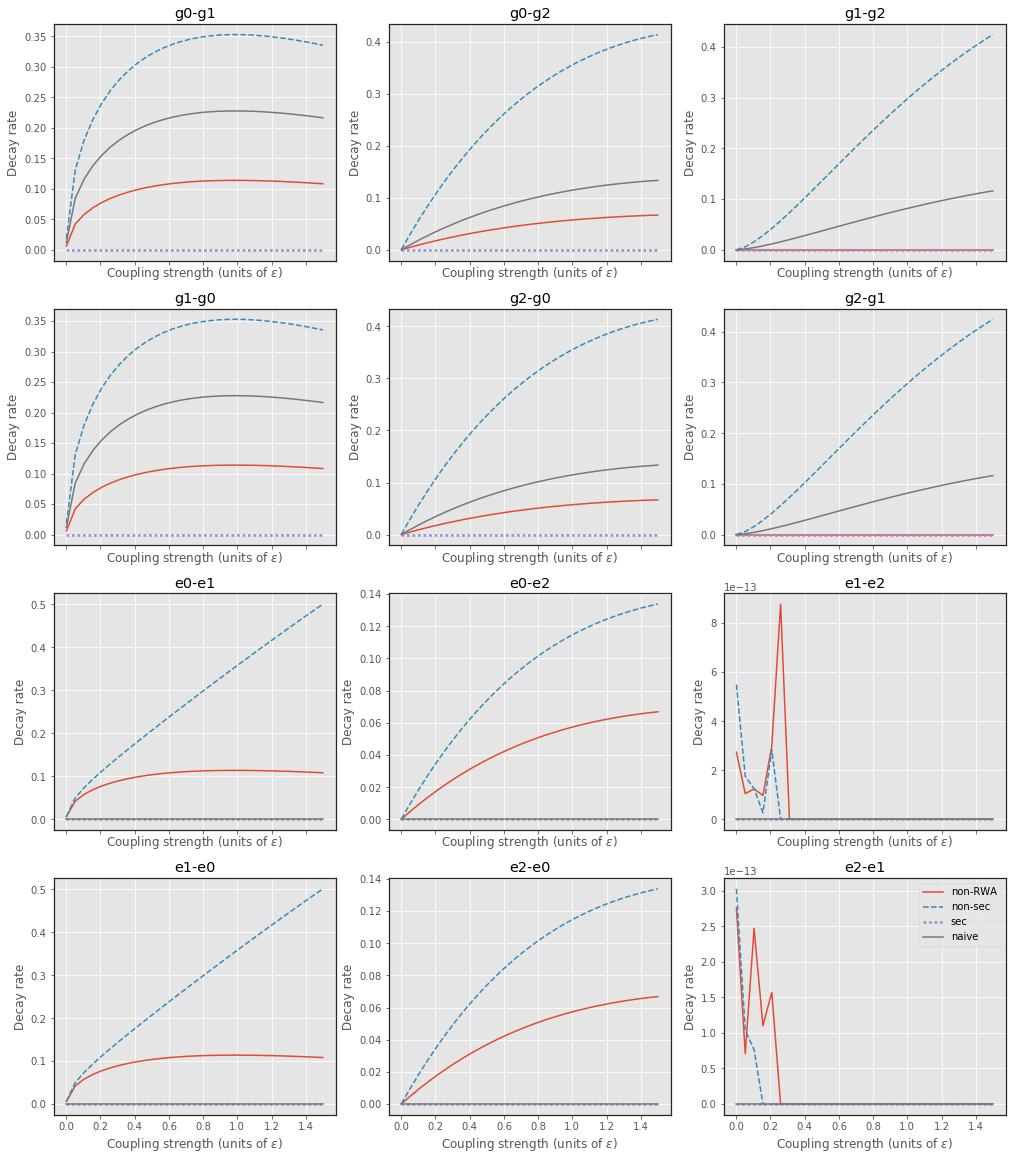

g0 T=6000
3.33% finished
16.67% finished
33.33% finished
50.00% finished
66.67% finished
83.33% finished
100.00% finished
Initial state is|g;0><g;0|


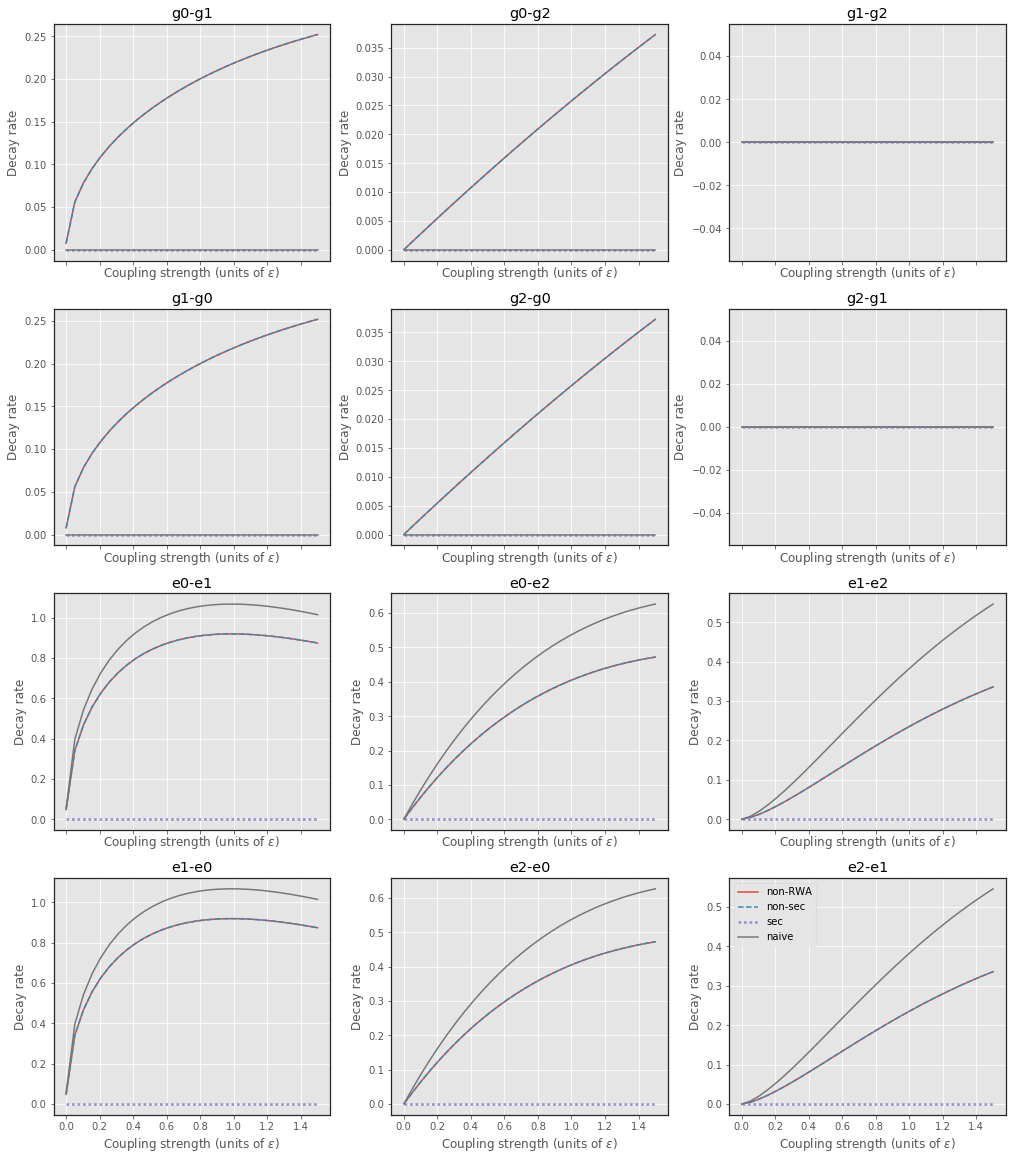

In [143]:
print "e0, T=0."
T_ph = 300.
off_diag_decay_rate_alpha((1,1), (0,0), eps, T_ph,  overdamped=True, T_EM=0.)
print "g0 T=6000"
off_diag_decay_rate_alpha((0,0), (0,0), eps, T_ph,  overdamped=True,  T_EM=6000.)


More evidence that the population states behave as they should. Also, when starting in $|g; 0\rangle\langle g; 0|$ the non-secular and non-RWA give the same results for decay rates to other ground and excited coherences.

The naive theory predicts that transitions are disallowed due to the fact that the field cannot cause transitions between states on the same manifold (?), i.e. e0-e0 can never transition to e1-e0 or anything else, however these non-secular processes must happen only on the level of vibronic states.

In [ ]:
print "e1, T=0."
off_diag_decay_rate_alpha((1,1), (1,1), eps, T_ph, overdamped=True, T_EM=0.)
print "g1, T=6000."
off_diag_decay_rate_alpha((0,0), (1,1), eps, T_ph, overdamped=True, T_EM=6000.)

Although the non-secular and non-RWA predicted the same for the g-0 transition rates, it does not for the g-1.


2.00% finished
10.00% finished
20.00% finished
30.00% finished
40.00% finished
50.00% finished
60.00% finished
70.00% finished
80.00% finished
90.00% finished
100.00% finished
Initial state is|e;0><e;0|


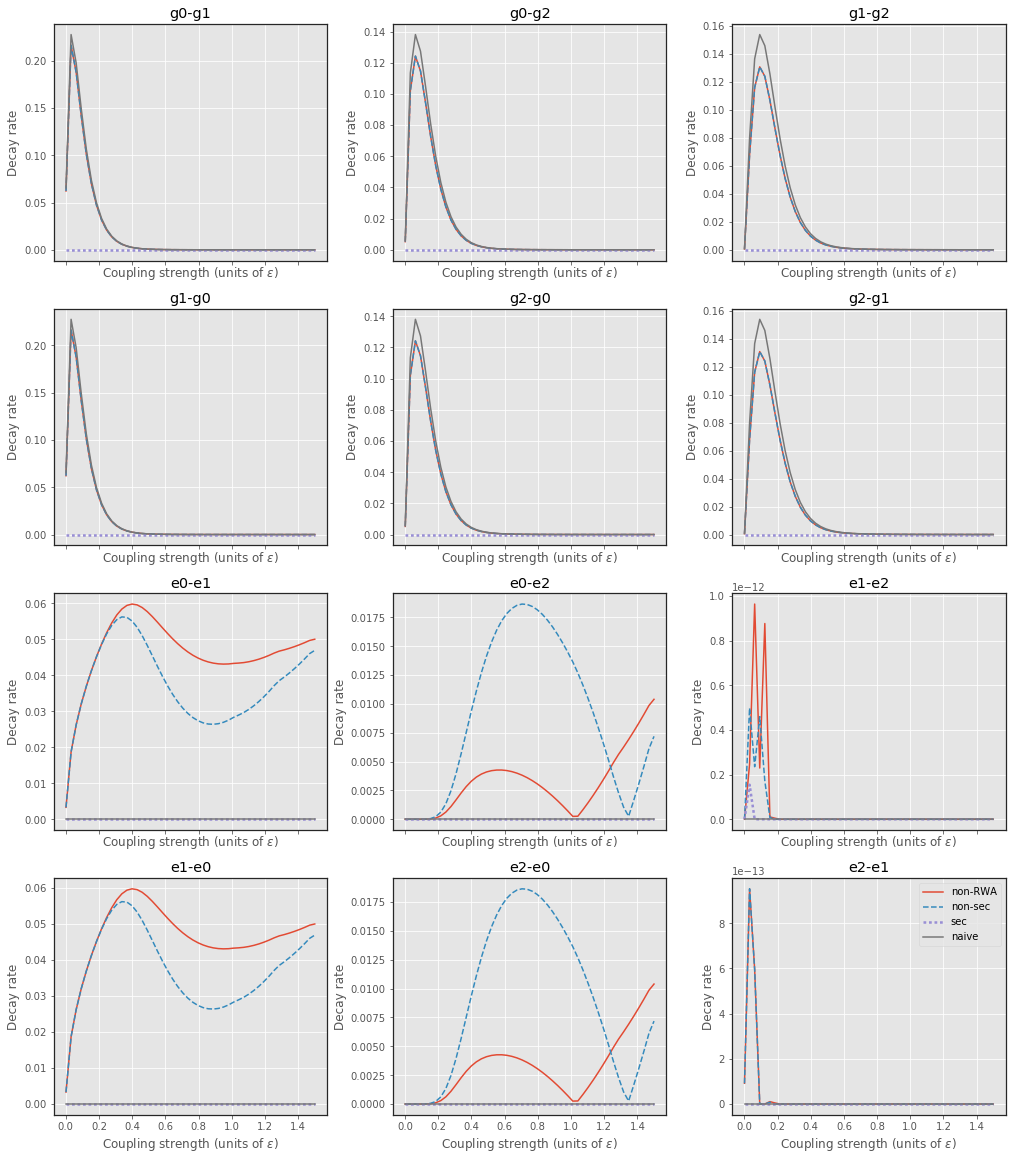

2.00% finished
10.00% finished
20.00% finished
30.00% finished
40.00% finished
50.00% finished
60.00% finished
70.00% finished
80.00% finished
90.00% finished
100.00% finished
Initial state is|e;0><e;1|


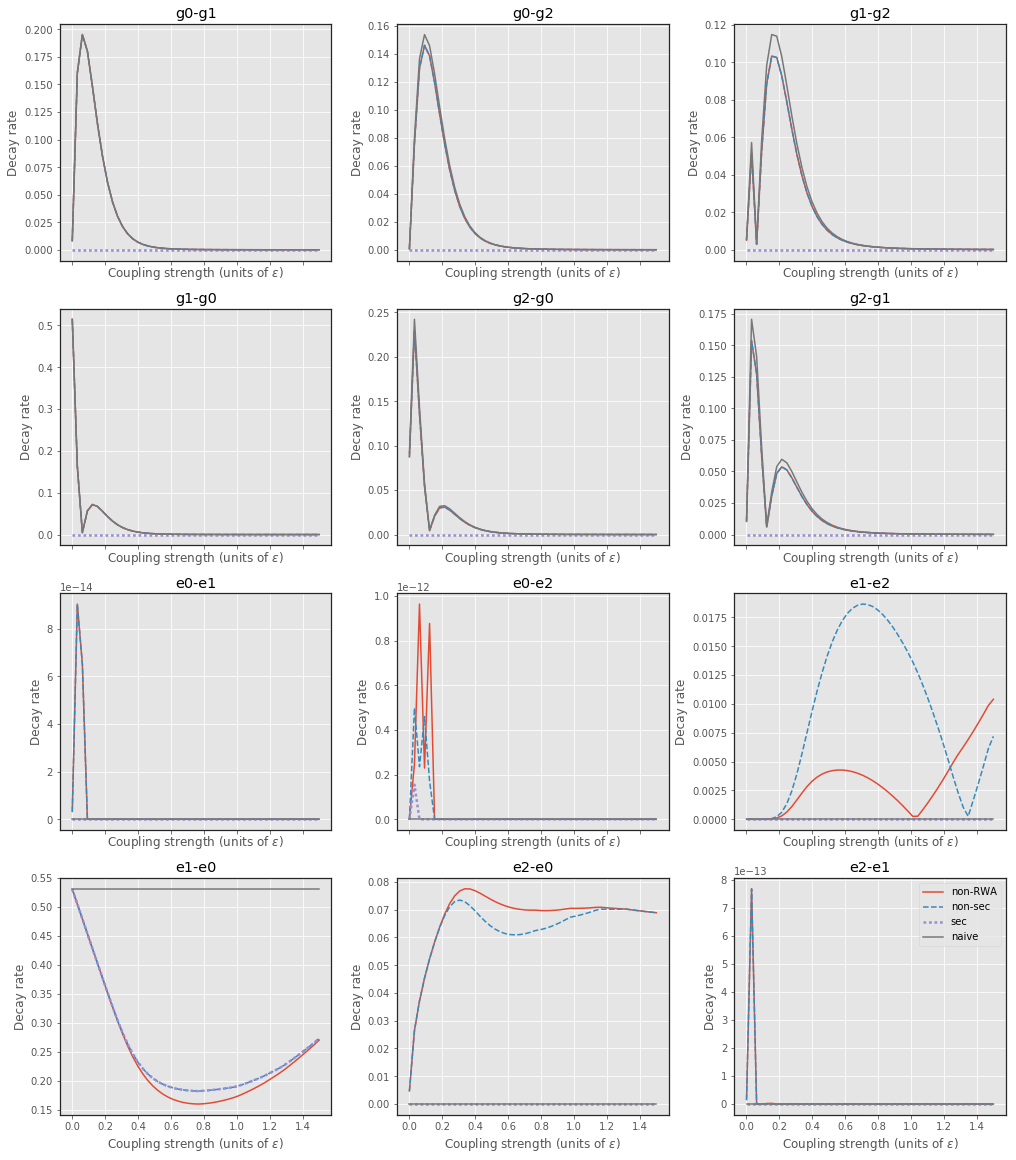

In [145]:
off_diag_decay_rate_alpha((1,1), (0,0), eps, T_ph, w0_prop=0.1, overdamped=True, T_EM=0., n_xpoints=50, N=16)
off_diag_decay_rate_alpha((1,1), (0,1), eps, T_ph, w0_prop=0.1, overdamped=True, T_EM=0., n_xpoints=50, N=16)


2.00% finished
10.00% finished
20.00% finished
30.00% finished
40.00% finished
50.00% finished
60.00% finished
70.00% finished
80.00% finished
90.00% finished
100.00% finished
Initial state is|e;0><e;1|


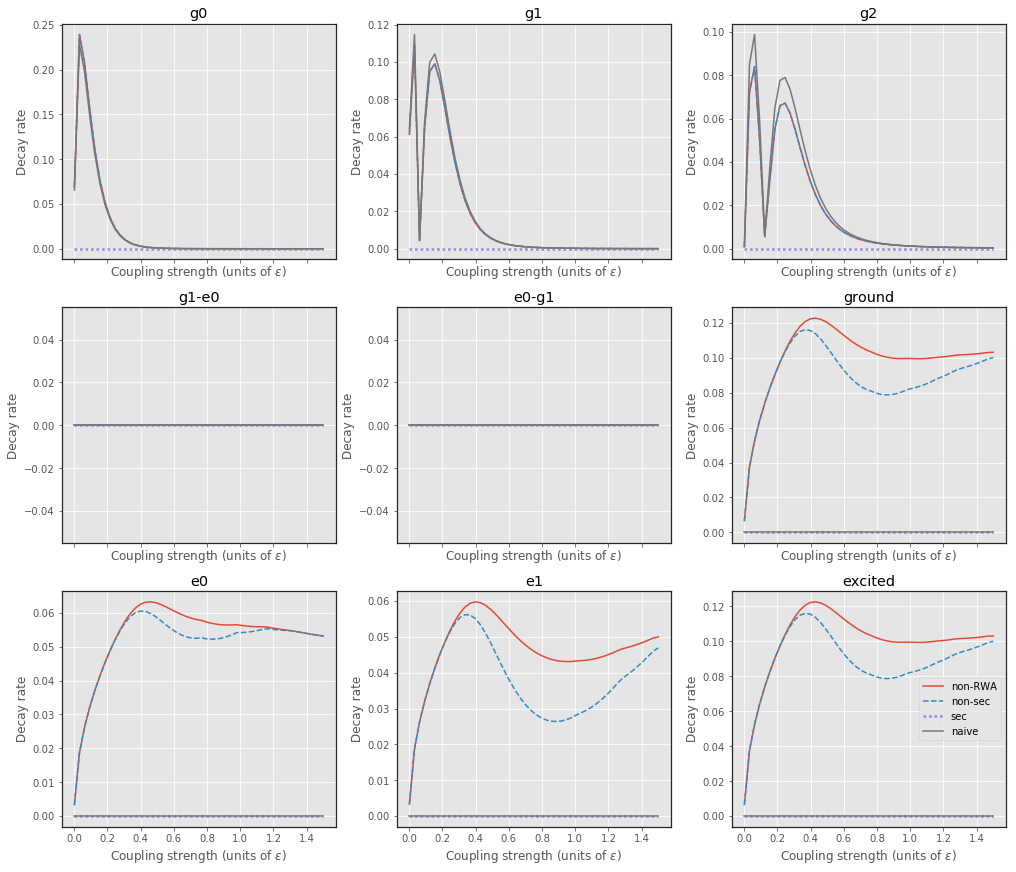

In [146]:
#off_diag_decay_rate_alpha((1,1), (0,0), eps, T_ph, w0_prop=0.1, overdamped=True, T_EM=0., n_xpoints=50, N=16)
off_diag_decay_rate_alpha((1,1), (0,1), eps, T_ph, w0_prop=0.1, overdamped=True, 
                                  T_EM=0., n_xpoints=50, N=16, populations=True)

For underdamped-like SDs, the secular and non-secular decay rates agree very well for populations decaying into coherences and for coherences decaying into populations and other coherences.

## population-coherence couplings for underdamped spectral densities

In [40]:
off_diag_decay_rate_alpha((0,0), (0,0), eps, T_ph, w0_prop=0.1, overdamped=True, 
                                                  T_EM=6000., n_xpoints=50, N=19)
off_diag_decay_rate_alpha((0,0), (0,1), eps, T_ph, w0_prop=0.1, overdamped=True, 
                                                  T_EM=6000., n_xpoints=50, N=19)
off_diag_decay_rate_alpha((0,0), (0,1), eps, T_ph, w0_prop=0.1, overdamped=True,
                                              T_EM=6000., n_xpoints=50, N=19, populations=True)

NameError: name 'off_diag_decay_rate_alpha' is not defined

# Emission spectra

In [4]:

reload(RC)
def emission_spectra(init_sys, init_RC, prop_coupling, eps, Gamma, w0_prop=2.1, T_ph=300., T_EM=0., 
                                    Gamma_EM=1., overdamped=True, naive_use_sigmax=False, 
                                     both_use_sigmam=False, N=9):
    # Start system+RC in adiabatic eigenstate and then time-evolve
    plt.close('all')
    alpha_ph = prop_coupling*eps/pi
    w0 = eps*w0_prop
    if overdamped:
        Gamma = (w0**2)/wc
    else:
        #N=20
        pass
    w = np.linspace(0., eps*1.5, 1000)
    plt.figure()
    plt.plot(w, J_underdamped(w, alpha_ph, Gamma, w0))
    plt.axvline(eps, label='Splitting',color='k')
    plt.ylabel("Coupling Strength")
    plt.xlabel(r"Frequency $cm^{-1}$")
    plt.title("Phonon Spectral Density")
    plt.legend()
    plt.show()
    G = ket([0])
    E = ket([1])
    sigma = G*E.dag() # Definition of a sigma_- operator.
    J = J_multipolar
    count = 1
    I_RC = qt.qeye(N)
    # This is true for specific Hamiltonian parameters
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dyn_DATA = []
    L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma= RC.RC_function_UD(sigma, eps, 
                                                                   T_ph, Gamma, 
                                                                   w0, alpha_ph, N, rotating=False)
    evals, states = H_RC.eigenstates()
    ground_list, excited_list = ground_and_excited_states(states)
    # work out how to initialise system rho
    init_rho = initialise_TLS(init_sys, init_RC, states, w0, T_ph)
    label = ['Naive', 'Full']
    #print len(excited_list), 'excited'
    # electromagnetic bath liouvillians
    final_t = 8/Gamma_EM
    timelist = np.linspace(0,final_t,int(380*final_t))
    options = qt.Options(nsteps=6000, store_states=True)
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,10))
    E_op = tensor(E*E.dag(), I_RC)
    for i, L_EM in enumerate([EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J, silent=True), 
                        EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J, silent=True)]):
        #L_EM = EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J)
        #L_s = EM.L_vib_lindblad(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J, silent=True)
        ti = time.time()
        sigma_RC = tensor(sigma, I_RC)

        if label[i]=='Full':
            sigma_RC = tensor(sigma+sigma.dag(), I_RC)
            ls = 'solid'
        else:
            ls = 'dashed'
        P = mesolve(H_RC, init_rho, timelist, [L_RC+L_EM], progress_bar=None,options=options).states
        
        ax1.plot(timelist, [((E_op*p).tr()).real for p in P], label=label[i], linestyle=ls)
        if overdamped:
            steps_per_tau, tau_f = 1500,  1.
        else:
            if abs((w0-eps)/eps)<0.1:
                steps_per_tau, tau_f = 2000, 2.
            else:
                steps_per_tau, tau_f = 2000, 1.
        #norm = np.array([(sigma_RC.dag()*sigma_RC*rho_t).tr() for rho_t in P])[0:tau_f*steps_per_tau]
        R= sum(P)
        print "Completed initial dynamics calculations for {} in {} seconds.".format(label[i], time.time()-ti)
        ti = time.time()
        Lambda_0 = sigma_RC*R
        del P
        
        taulist = np.linspace(0, tau_f, int(tau_f*steps_per_tau))
        Lambda_t = mesolve(H_RC, Lambda_0, taulist, [L_RC+L_EM],options=options)
        #sigma_t = mesolve(H_RC, init_rho, taulist, [L_RC+L_EM], 
        #                  [sigma_RC.dag()*sigma_RC], options=options).expect[0]
        g_1 = np.array([(sigma_RC.dag()*l).tr() for l in Lambda_t.states])
        g_1/=abs(g_1[0])
        #else:
        #    g_1/=np.sqrt(norm*norm[0])
        
        #if label[i] == 'Full':
        #    g_1=g_1.conjugate()
        
        ax3.plot(taulist, g_1.real, label=label[i], linestyle=ls)
        ax4.plot(taulist, g_1.imag, label=label[i], linestyle=ls)
        freq, spec = qt.spectrum_correlation_fft(taulist, g_1)
        spec-= min(spec)
        spec = spec/sum(spec)
        ax2.plot(freq, spec.real, label=label[i], linestyle=ls)
        print "Completed correlation function calculations for {} in {} seconds.".format(label[i], time.time()-ti)
    ax1.set_xlim(0,15)
    ax3.set_xlim(0,taulist[int((len(taulist)-1)/5.)])
    ax4.set_xlim(0,taulist[int((len(taulist)-1)/5.)])
    ax1.set_xlabel(r"Time")
    ax2.set_xlabel(r"Frequency $cm^{-1}$")
    ax2.axvline(eps, linestyle='dashed',color='k')
    ax2.set_xlim(0,2*eps)
    
    ax1.set_ylabel(r"Excited state population")
    ax2.set_ylabel(r"Fluorescence intensity (arb. units)")
    ax3.set_ylabel(r"$Re[g_1(\tau)]$") # coherence
    ax4.set_ylabel(r"$Im[g_1(\tau)]$") # coherence
    ax3.set_xlabel(r"$\tau$")
    ax4.set_xlabel(r"$\tau$")
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    plt.show()
    return freq, spec

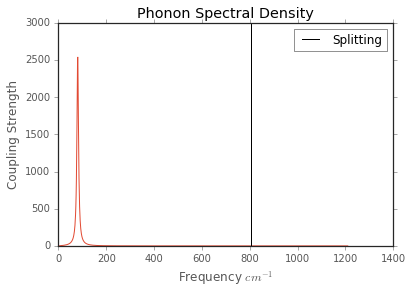

w_RC=80.655 | TLS splitting = 806.55 | RC-res. coupling=0.02 | TLS-RC coupling=180.35 | Gamma_RC=8.00 | alpha_ph=256.73 | N=30 |
Completed initial dynamics calculations for Naive in 126.468307018 seconds.
Completed correlation function calculations for Naive in 13.9598920345 seconds.
Completed initial dynamics calculations for Full in 179.320014 seconds.
Completed correlation function calculations for Full in 36.6667740345 seconds.


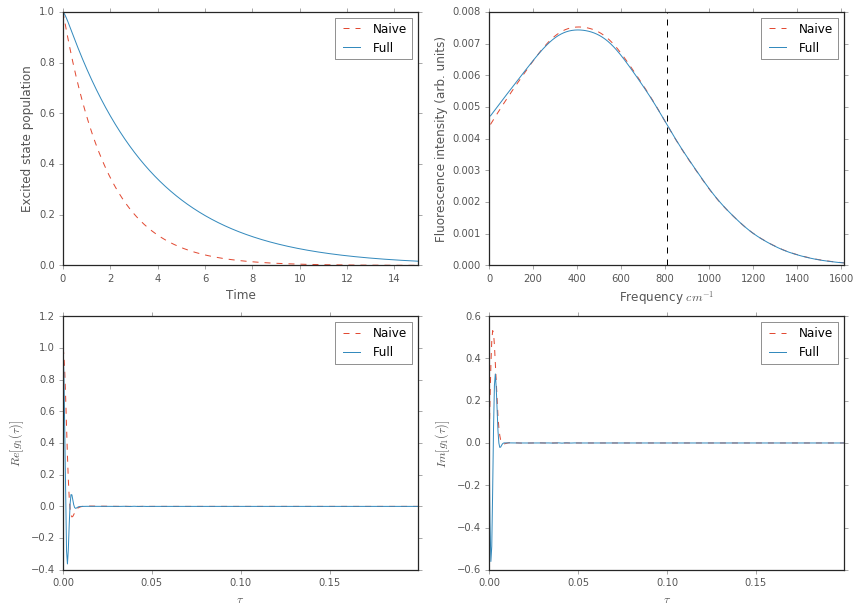

'\nfreq, spec = emission_spectra(1, 0, 0.02, eps, 8, w0_prop=0.99, \n                              overdamped=False, T_ph=300., \n                              Gamma_EM=Gamma_EM, N=13)\n\n\nfreq, spec = emission_spectra(1, 0, 0.02, eps, 8, w0_prop=0.05, \n                              overdamped=False, T_ph=T_ph, \n                              Gamma_EM=Gamma_EM, N=20)\nfreq, spec = emission_spectra(1, 0, 0.02, eps, 8, w0_prop=0.05, \n                              overdamped=False, T_ph=78., \n                              Gamma_EM=Gamma_EM, N=20)\n\nfreq, spec = emission_spectra(1, 0, 0.1, eps, 8, w0_prop=0.15, \n                              overdamped=False, T_ph=T_ph, \n                              Gamma_EM=Gamma_EM, N=17)\n'

In [9]:
"""UNDERDAMPED MODES"""

freq, spec = emission_spectra(1, 0, 1., eps, 8, w0_prop=0.1, 
                              overdamped=False, T_ph=T_ph, 
                              Gamma_EM=Gamma_EM, N=30)
"""
freq, spec = emission_spectra(1, 0, 0.02, eps, 8, w0_prop=0.99, 
                              overdamped=False, T_ph=300., 
                              Gamma_EM=Gamma_EM, N=13)


freq, spec = emission_spectra(1, 0, 0.02, eps, 8, w0_prop=0.05, 
                              overdamped=False, T_ph=T_ph, 
                              Gamma_EM=Gamma_EM, N=20)
freq, spec = emission_spectra(1, 0, 0.02, eps, 8, w0_prop=0.05, 
                              overdamped=False, T_ph=78., 
                              Gamma_EM=Gamma_EM, N=20)

freq, spec = emission_spectra(1, 0, 0.1, eps, 8, w0_prop=0.15, 
                              overdamped=False, T_ph=T_ph, 
                              Gamma_EM=Gamma_EM, N=17)
"""



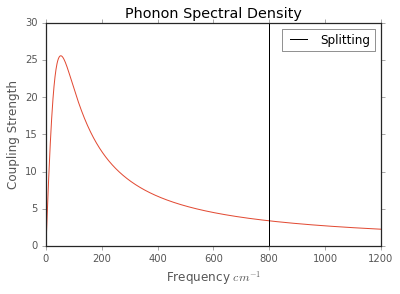

w_RC=880.0 | TLS splitting = 800.0 | RC-res. coupling=2.64 | TLS-RC coupling=265.33 | Gamma_RC=14611.32 | alpha_ph=50.93 | N=7 |
Completed initial dynamics calculations for Naive in 107.330831051 seconds.
Completed correlation function calculations for Naive in 9.55593395233 seconds.
Completed initial dynamics calculations for Full in 131.761600971 seconds.
Completed correlation function calculations for Full in 16.1827809811 seconds.


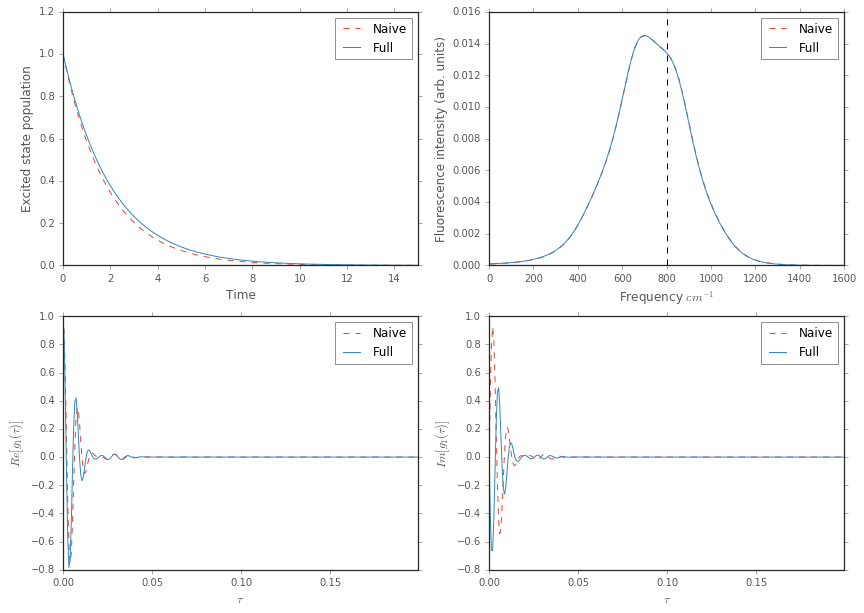

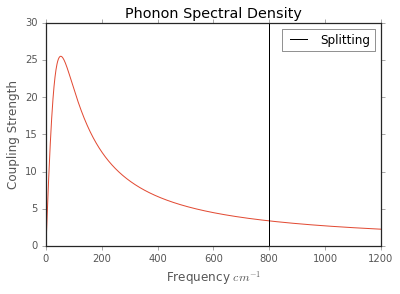

w_RC=1680.0 | TLS splitting = 800.0 | RC-res. coupling=5.04 | TLS-RC coupling=366.61 | Gamma_RC=53252.83 | alpha_ph=50.93 | N=7 |
Completed initial dynamics calculations for Naive in 344.184136868 seconds.
Completed correlation function calculations for Naive in 97.6957120895 seconds.
Completed initial dynamics calculations for Full in 440.588120937 seconds.
Completed correlation function calculations for Full in 28.7132248878 seconds.


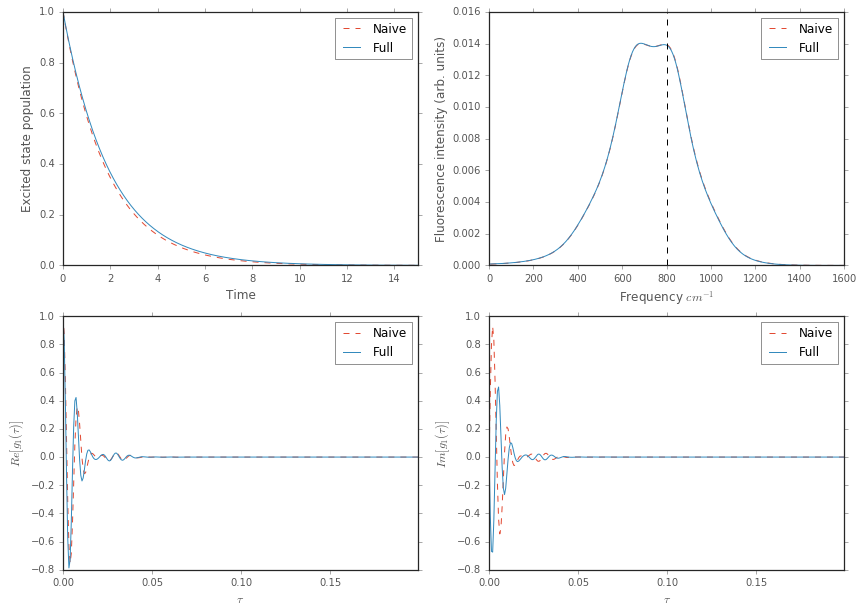

In [18]:
eps = 0.1*8000
T_ph=300.
Gamma_EM = 0.1*5.309
"""Overdamped SD"""
'''freq, spec = emission_spectra(1, 0, 0.01, eps, 0, 0, 
                              overdamped=True, T_ph=T_ph, 
                              Gamma_EM=Gamma_EM, N=5)'''
'''
freq, spec = emission_spectra(1, 0, 0.1, eps, 0, 0, 
                              overdamped=True, T_ph=T_ph, 
                              Gamma_EM=Gamma_EM, N=8)'''
freq, spec = emission_spectra(1, 0, 0.2, eps, 0, w0_prop=1.1, 
                              overdamped=True, T_ph=T_ph, 
                              Gamma_EM=Gamma_EM, N=7)
freq, spec = emission_spectra(1, 0, 0.2, eps, 0, w0_prop=2.1, 
                              overdamped=True, T_ph=T_ph, 
                              Gamma_EM=Gamma_EM, N=7)



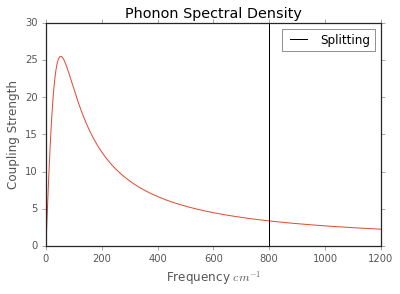

w_RC=2400.0 | TLS splitting = 800.0 | RC-res. coupling=7.21 | TLS-RC coupling=438.18 | Gamma_RC=108679.25 | alpha_ph=50.93 | N=7 |


KeyboardInterrupt: 

In [19]:
freq, spec = emission_spectra(1, 0, 0.2, eps, 0, w0_prop=3.0, 
                              overdamped=True, T_ph=T_ph, 
                              Gamma_EM=Gamma_EM, N=7)

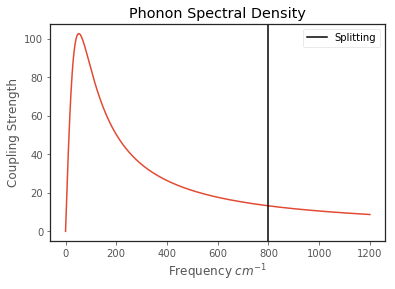

w_RC=640.0 | TLS splitting = 800.0 | RC-res. coupling=1.96 | TLS-RC coupling=452.55 | Gamma_RC=7876.92 | alpha_ph=203.72 | N=12 |
Completed initial dynamics calculations for Naive in 272.223494053 seconds.
Completed correlation function calculations for Naive in 18.0915939808 seconds.
Completed initial dynamics calculations for Full in 528.618335962 seconds.
Completed correlation function calculations for Full in 29.1909458637 seconds.


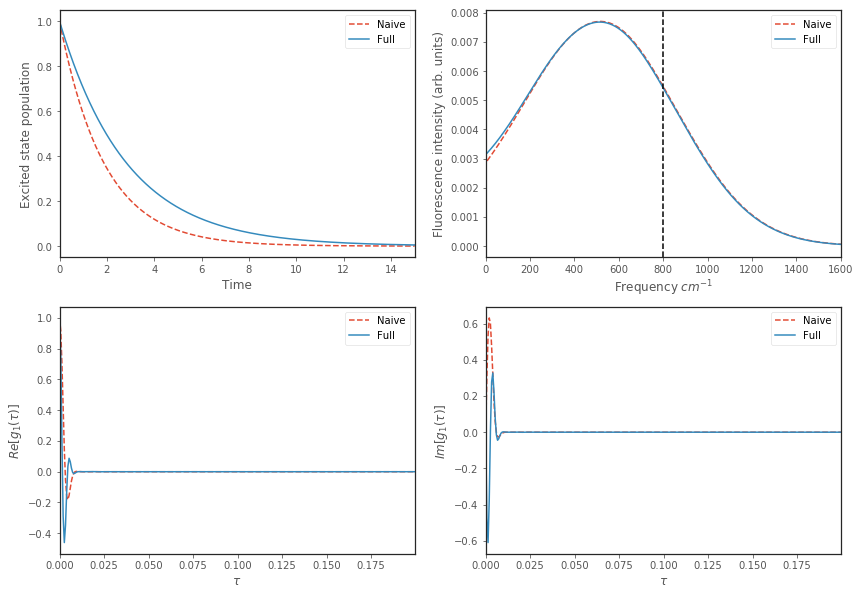

In [282]:
freq, spec = emission_spectra(1, 0, 0.8, eps, 0, 0, 
                              overdamped=True, T_ph=T_ph, 
                              Gamma_EM=Gamma_EM, N=12)

# Jake's NV center Parameters

In [200]:

reload(RC)
def emission_spectra_NV(init_sys, init_RC, prop_coupling, eps, Gamma, w0, T_ph=300., T_EM=0., 
                                    Gamma_EM=1., overdamped=True, naive_use_sigmax=False, 
                                     both_use_sigmam=False, N=9):
    # Start system+RC in adiabatic eigenstate and then time-evolve
    plt.close('all')
    alpha_ph = prop_coupling*eps# /pi
    
    if overdamped:
        w0 = eps*1.01
        Gamma = (w0**2)/wc
    else:
        #N=20
        pass
    w = np.linspace(0., eps*1.5, 1000)
    plt.figure()
    plt.plot(w, J_underdamped(w, alpha_ph, Gamma, w0))
    plt.axvline(eps, label='Splitting',color='k')
    plt.ylabel("Coupling Strength")
    plt.xlabel(r"Frequency $cm^{-1}$")
    plt.title("Phonon Spectral Density")
    plt.legend()
    plt.show()
    G = ket([0])
    E = ket([1])
    sigma = G*E.dag() # Definition of a sigma_- operator.
    J = J_multipolar
    count = 1
    I_RC = qt.qeye(N)
    # This is true for specific Hamiltonian parameters
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dyn_DATA = []
    L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma= RC.RC_function_UD(sigma, eps, 
                                                                   T_ph, Gamma, 
                                                                   w0, alpha_ph, N, rotating=True)
    _, H_RC_opt, A_EM_opt, A_nrwa_opt, wRC, kappa, Gamma= RC.RC_function_UD(sigma, eps, 
                                                                   T_ph, Gamma, 
                                                                   w0, alpha_ph, N, rotating=False)
    evals, states = H_RC.eigenstates()
    ground_list, excited_list = ground_and_excited_states(states)
    # work out how to initialise system rho
    init_rho = initialise_TLS(init_sys, init_RC, states, w0, T_ph)
    label = ['Naive', 'Full']
    #print len(excited_list), 'excited'
    # electromagnetic bath liouvillians
    final_t = 10/Gamma_EM
    timelist = np.linspace(0,final_t,int(700*final_t))
    options = qt.Options(nsteps=6000, store_states=True)
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,12))
    E_op = tensor(E*E.dag(), I_RC)
    for i, L_EM in enumerate([EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J, silent=True), 
                        EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J, silent=True)]):
        #L_EM = EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J)
        #L_s = EM.L_vib_lindblad(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J, silent=True)
        ti = time.time()
        sigma_RC = tensor(sigma, I_RC)

        if label[i]=='Full':
            sigma_RC = tensor(sigma+sigma.dag(), I_RC)
        P = mesolve(H_RC, init_rho, timelist, [L_RC+L_EM], progress_bar=None,options=options).states
        
        ax1.plot(timelist, [((E_op*p).tr()).real for p in P])
        if overdamped:
            steps_per_tau, tau_f = 15000, 1/Gamma_EM# 0.25
        else:
            steps_per_tau, tau_f = 20000, 1/Gamma_EM
        
        #norm = np.array([(sigma_RC.dag()*sigma_RC*rho_t).tr() for rho_t in P])[0:tau_f*steps_per_tau]
        R= sum(P)
        print "Completed initial dynamics calculations for {} in {} seconds.".format(label[i], time.time()-ti)
        ti = time.time()
        Lambda_0 = sigma_RC*R
        del P
        
        taulist = np.linspace(0, tau_f, int(tau_f*steps_per_tau))
        Lambda_t = mesolve(H_RC, Lambda_0, taulist, [L_RC+L_EM],options=options)
        #sigma_t = mesolve(H_RC, init_rho, taulist, [L_RC+L_EM], 
        #                  [sigma_RC.dag()*sigma_RC], options=options).expect[0]
        g_1 = np.array([(sigma_RC.dag()*l).tr() for l in Lambda_t.states])
        g_1/=g_1[0]
        #else:
        #    g_1/=np.sqrt(norm*norm[0])
        
        #if label[i] == 'Full':
        #    g_1=g_1.conjugate()
        
        ax2.plot(taulist, g_1.real, label=label[i]+' real', linestyle='dashed')
        ax2.plot(taulist, g_1.imag, label=label[i]+' imag')
        #ax2.set_xscale('log')
        freq, spec = qt.spectrum_correlation_fft(taulist, g_1)
        spec-= min(spec)
        spec = spec/sum(spec)
        ax3.plot(freq, spec.real, label=label[i])
        print "Completed correlation function calculations for {} in {} seconds.".format(label[i], time.time()-ti)
    #ax1.set_xlim(0,timelist[-1])
    #ax2.set_xlim(0,taulist[int((len(taulist)-1)/2.)])
    ax1.legend()
    ax2.legend()
    ax3.axvline(eps, linestyle='dashed',color='k')
    ax3.set_xlim(0,int(2*eps))
    ax3.legend()
    plt.show()
    return freq, spec


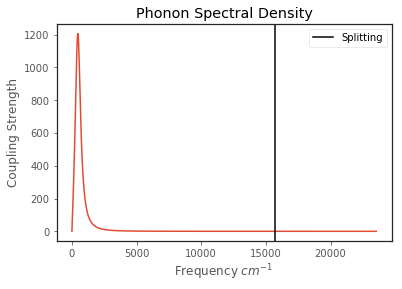

w_RC=524.2575 | TLS splitting = 15687.3975 | RC-res. coupling=0.16 | TLS-RC coupling=967.74 | Gamma_RC=526.68 | alpha_ph=1137.24 | N=8 |
w_RC=524.2575 | TLS splitting = 15687.3975 | RC-res. coupling=0.16 | TLS-RC coupling=967.74 | Gamma_RC=526.68 | alpha_ph=1137.24 | N=8 |
Completed initial dynamics calculations for Naive in 1.6181678772 seconds.
Completed correlation function calculations for Naive in 1.05804586411 seconds.
Completed initial dynamics calculations for Full in 1.43221306801 seconds.
Completed correlation function calculations for Full in 1.2632329464 seconds.


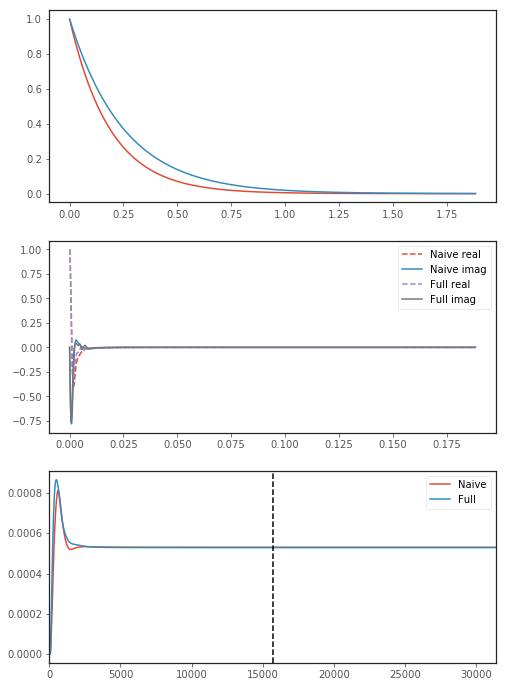

In [187]:
conv = ev_to_inv_cm*1e-3
Gamma_EM = 0.6582*conv
alpha = 141.*conv # meV
Gamma = 65.3*conv
epsilon = 1.945e3*conv
omega_0 = 65.*conv
freq, spec = emission_spectra_NV(1, 0, alpha/epsilon, epsilon, Gamma, omega_0, 
                              overdamped=False, T_ph=50.,
                              Gamma_EM=Gamma_EM, N=8)


## Absorption spectra

In [129]:

reload(RC)
def absorption_spectra(prop_coupling, eps, Gamma, w0, T_ph=300., T_EM=0., 
                                    Gamma_EM=1., overdamped=True, N=3):
    # Start system+RC in adiabatic eigenstate and then time-evolve
    plt.close('all')
    alpha_ph = prop_coupling*eps/np.pi
    
    if overdamped:
        w0 = eps*1.01
        Gamma = (w0**2)/wc
    else:
        #N=20
        pass
    w = np.linspace(0., eps*1.5, 1000)
    plt.figure()
    plt.plot(w, J_underdamped(w, alpha_ph, Gamma, w0))
    plt.axvline(eps, label='Splitting',color='k')
    plt.ylabel("Coupling Strength")
    plt.xlabel(r"Frequency $cm^{-1}$")
    plt.title("Phonon Spectral Density")
    plt.legend()
    plt.show()
    G = ket([0])
    E = ket([1])
    
    J = J_multipolar
    I_RC = qt.qeye(N)
    # This is true for specific Hamiltonian parameters
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dyn_DATA = []
    
    L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma= RC.RC_function_UD(sigma, eps, 
                                                                   T_ph, Gamma, 
                                                                   w0, alpha_ph, N)
    
    evals, states = H_RC.eigenstates()
    ground_list, excited_list = ground_and_excited_states(states)
    # work out how to initialise system rho
    mu = tensor(G*E.dag()+E*G.dag(), I_RC) # Definition of a sigma_- operator.
    init_rho = initialise_TLS(0, 0, states, w0, T_ph)
    init_rho = mu*init_rho-init_rho*mu
    label = ['Naive', 'Full']
    #print len(excited_list), 'excited'
    # electromagnetic bath liouvillians
    final_t = 2
    timelist = np.linspace(0,final_t,450*final_t)
    options = qt.Options(nsteps=1500)
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,12))
    E_op = tensor(E*E.dag(), I_RC)
    
    for i, L_EM in enumerate([EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J, silent=True), 
                        EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J, silent=True)]):
        #L_EM = EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J)
        #L_s = EM.L_vib_lindblad(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J, silent=True)
        ti = time.time()
        S1 = mesolve(H_RC, init_rho, timelist,  [L_RC+L_EM], [mu],
                             progress_bar=None,options=options).expect[0]
        ax1.plot(timelist, S1.real, label=label[i]+' real')
        ax2.plot(timelist, S1.imag, label=label[i]+' imag')
        #norm = np.array([(sigma_RC.dag()*sigma_RC*rho_t).tr() for rho_t in P])[0:tau_f*steps_per_tau]
        print "Completed response function calculations for {} in {} seconds.".format(label[i], time.time()-ti)
        
        freq, spec = qt.spectrum_correlation_fft(timelist, S1)
        #spec-= min(spec)
        spec = spec/sum(spec)
        ax3.plot(freq, spec, label=label[i])
    ax1.set_xlim(0,timelist[int((len(timelist)-1)/2.)])
    ax2.set_xlim(0,timelist[int((len(timelist)-1)/2.)])
    ax1.legend()
    ax3.axvline(eps, linestyle='dashed',color='k')
    #ax3.set_xlim(0,2000)
    ax2.legend()
    ax3.legend()
    plt.show()
    return freq, spec

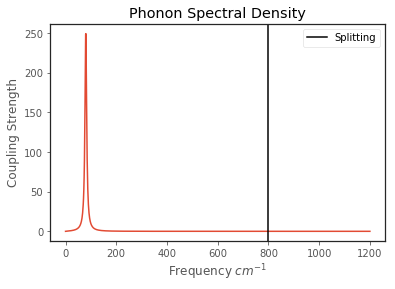

w_RC=80.0 | TLS splitting = 800.0 | RC-res. coupling=0.02 | TLS-RC coupling=56.57 | Gamma_RC=8.00 | alpha_ph=25.46 | N=14 |
Completed response function calculations for Naive in 1.217856884 seconds.
Completed response function calculations for Full in 1.45950388908 seconds.


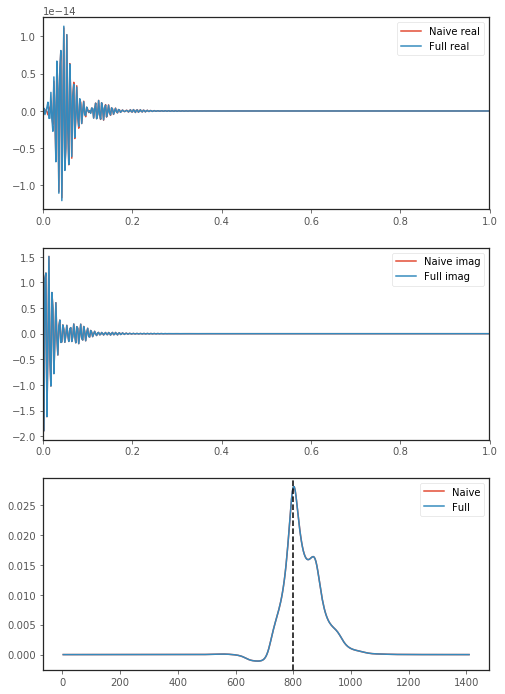

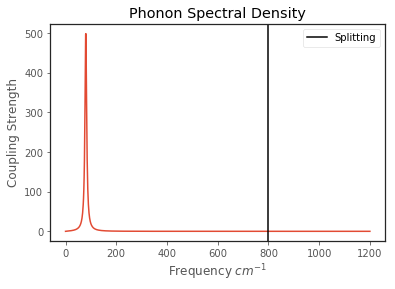

w_RC=80.0 | TLS splitting = 800.0 | RC-res. coupling=0.02 | TLS-RC coupling=80.00 | Gamma_RC=8.00 | alpha_ph=50.93 | N=14 |
Completed response function calculations for Naive in 1.67911601067 seconds.
Completed response function calculations for Full in 1.92139482498 seconds.


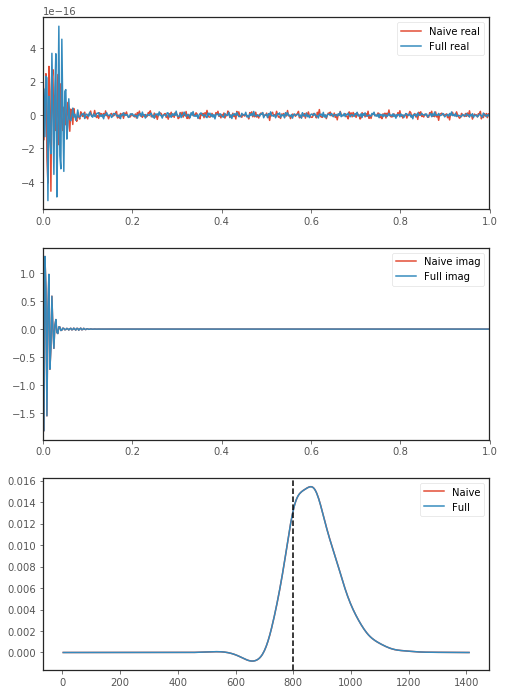

In [201]:
freq, spec = absorption_spectra(0.1, eps, 8., 80., Gamma_EM=Gamma_EM, overdamped=False, N=14)
freq, spec = absorption_spectra(0.2, eps, 8., 80., Gamma_EM=Gamma_EM, overdamped=False, N=14)
freq, spec = absorption_spectra(0.2, eps, 8., 80., Gamma_EM=Gamma_EM, overdamped=False, N=14)
#freq, spec = absorption_spectra(0.1, eps, 8., 200., Gamma_EM=Gamma_EM, overdamped=False, N=14)
#freq, spec = absorption_spectra(0.1, eps, 8., 80., Gamma_EM=Gamma_EM, overdamped=True, N=9)

## Liouvillian Compression

w_RC=80.655 | TLS splitting = 806.55 | RC-res. coupling=0.10 | TLS-RC coupling=101.09 | Gamma_RC=53.00 | alpha_ph=80.66 | N=25 |
0
8.0% of terms removed.
Compression took 25.6667749882 seconds.
10.0%. Run time:   0.85s. Est. time left: 00:00:00:07
20.0%. Run time:   1.74s. Est. time left: 00:00:00:06
30.0%. Run time:   2.56s. Est. time left: 00:00:00:05
40.0%. Run time:   3.87s. Est. time left: 00:00:00:05
50.0%. Run time:   5.50s. Est. time left: 00:00:00:05
60.0%. Run time:   7.10s. Est. time left: 00:00:00:04
70.0%. Run time:   8.30s. Est. time left: 00:00:00:03
80.0%. Run time:   9.38s. Est. time left: 00:00:00:02
90.0%. Run time:  10.52s. Est. time left: 00:00:00:01
Total run time:  11.33s
10.0%. Run time:   0.12s. Est. time left: 00:00:00:01
20.0%. Run time:   0.43s. Est. time left: 00:00:00:01
30.0%. Run time:   0.70s. Est. time left: 00:00:00:01
40.0%. Run time:   0.84s. Est. time left: 00:00:00:01
50.0%. Run time:   1.01s. Est. time left: 00:00:00:01
60.0%. Run time:   1.25s. 

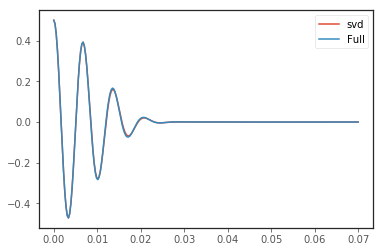

In [23]:
N = 25
initial_sys = 0.5*(E+G)*(E+G).dag()

rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
#print (rho_0*tensor(qeye(2), destroy(N).dag()*destroy(N))).tr()

# Expectation values and time increments needed to calculate the dynamics
expects_wc = [G*G.dag(), E*G.dag()]
expects = [tensor(G*G.dag(), qeye(N)), tensor(E*G.dag(), qeye(N)), 
           tensor(E*E.dag(), qeye(N)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
           tensor(qeye(2), destroy(N).dag()+destroy(N))]
nTimeSteps = 250
timelist = np.linspace(0, 0.07, nTimeSteps)

alpha_ph = 0.1*eps

opts = qt.Options(nsteps=5000)
w0 = eps*0.1
Gamma = wc
L_RC, H_RC, A_EM_, A_nrwa_, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0,
                                                                      alpha_ph, N)


from numpy.linalg import svd

def compress_L(L, threshold=50.):
    
    ti = time.time()
    u, s, vh = svd(L.full())
    
    approx_s = [sv if abs(sv)>threshold else 0 for sv in s]
    print min(approx_s)
    print "{}% of terms removed.".format(100*(sum([0. if abs(sv)>threshold else 1. for sv in s])/len(approx_s)))
    approx_s_mat = np.zeros((u.shape[1], vh.shape[0]), dtype=complex)
    approx_s_mat[:len(s), :len(s)] = np.diag(approx_s)
    L_approx = qt.Qobj(np.dot(u, np.dot(approx_s_mat, vh)), dims = L.dims).tidyup(atol=1e-7)
    print "Compression took {} seconds.".format(time.time()-ti)
    return L_approx
L_approx = compress_L(L_RC)
#print L_RC
#print L_approx

DATA_sc_approx =  np.array(mesolve(H_RC, rho_0, timelist, [L_approx], expects, progress_bar=True).expect[1])
plt.plot(timelist, DATA_sc_approx.real, label='svd')
DATA_sc =  np.array(mesolve(H_RC, rho_0, timelist, [L_RC], expects, progress_bar=True).expect[1])
plt.plot(timelist, DATA_sc.real, label='Full')
plt.legend()
plt.show()

In [27]:
u, s, vt =  svd(rho_0.full())
print s

[  9.83561900e-01   1.61678887e-02   2.65769369e-04   4.36874342e-06
   7.18138406e-08   1.18048308e-09   1.94048988e-11   6.94927405e-17
   6.94927405e-17   6.94927405e-17   6.94927405e-17   6.94927405e-17
   6.94927405e-17   6.94927405e-17   6.94927405e-17   6.94927405e-17
   6.94927405e-17   6.94927405e-17   6.94927405e-17   6.94927405e-17
   6.94927405e-17   6.94927405e-17   6.94927405e-17   6.94927405e-17
   6.94927405e-17   6.94927405e-17   6.94927405e-17   6.94927405e-17
   6.94927405e-17   6.94927405e-17   6.94927405e-17   6.94927405e-17
   6.94927405e-17   6.94927405e-17   6.94927405e-17   6.94927405e-17
   6.94927405e-17   6.94927405e-17   6.94927405e-17   6.94927405e-17
   6.94927405e-17   6.94927405e-17   6.94927405e-17   6.86793649e-17
   4.91387880e-17   4.91387880e-17   4.91387880e-17   4.91387880e-17
   4.91387880e-17   4.91387880e-17]


In [18]:
L_approx.shape[0]*0.04

100.0

In [17]:
help(L_RC)

Help on Qobj in module qutip.qobj object:

class Qobj(__builtin__.object)
 |  A class for representing quantum objects, such as quantum operators
 |  and states.
 |  
 |  The Qobj class is the QuTiP representation of quantum operators and state
 |  vectors. This class also implements math operations +,-,* between Qobj
 |  instances (and / by a C-number), as well as a collection of common
 |  operator/state operations.  The Qobj constructor optionally takes a
 |  dimension ``list`` and/or shape ``list`` as arguments.
 |  
 |  Parameters
 |  ----------
 |  inpt : array_like
 |      Data for vector/matrix representation of the quantum object.
 |  dims : list
 |      Dimensions of object used for tensor products.
 |  shape : list
 |      Shape of underlying data structure (matrix shape).
 |  copy : bool
 |      Flag specifying whether Qobj should get a copy of the
 |      input data, or use the original.
 |  fast : bool
 |      Flag for fast qobj creation when running ode solvers.
 |      